In [1]:
# -*- coding: utf-8 -*-
"""
Subset selection for MaFaulDa dataset
- 6 super-classes: Normal, Imbalance, Horizontal/Vertical Misalignment, Overhang, Underhang
- Picks every STEP_N-th CSV per folder (numeric filename sort)
- BUT for the 'Normal' class we use a denser sampling (smaller step = STEP_N // OVERSAMPLE_NORMAL_X)
- Extracts metadata and writes a fresh manifest (no file copying).
"""

import os
import re
import csv
from pathlib import Path

# ========================
# CONFIG (EDIT THESE)
# ========================
ROOT_DIR      = r"E:\ali\PY Projects\MaFaulDa Dataset Full 12GB"
OUT_MANIFEST  = r"E:\ali\PY Projects\MaFaulDa 1\MaFaulDa_subset_manifest.csv"

STEP_N = 12                # default stride
OVERSAMPLE_NORMAL_X = 3     # e.g., 3 => Normal uses step = max(1, STEP_N // 3)
INCLUDE_ENDPOINTS = True
VALID_EXTS = {".csv"}

CLASS_BY_PICTURE = {
    "normal": "Normal",
    "imbalance": "Imbalance",
    "horizontal-misalignment": "Horizontal Misalignment",
    "vertical-misalignment": "Vertical Misalignment",
    "overhang": "Overhang",
    "underhang": "Underhang",
}

RE_SEVERITY = re.compile(r"(?i)^\s*(\d+(?:\.\d+)?)(\s*(g|mm))\s*$")

# ========================
# HELPERS
# ========================
def numeric_sorted_csvs(folder: Path):
    files = [folder / f for f in os.listdir(folder)
             if (folder / f).is_file() and f.lower().endswith(".csv")]
    def keyfunc(p: Path):
        try:
            return float(p.stem)
        except ValueError:
            return float("inf")
    return sorted(files, key=keyfunc)

def select_every_n(files, n: int, include_endpoints=True):
    if not files:
        return []
    chosen = []
    if include_endpoints:
        chosen.append(files[0])
    chosen.extend(files[::max(1, n)])
    if include_endpoints and files[-1] not in chosen:
        chosen.append(files[-1])
    # unique while preserving order
    seen, out = set(), []
    for f in files:
        if f in chosen and f not in seen:
            out.append(f); seen.add(f)
    return out

def map_super_class(path_like: Path, root: Path) -> str:
    """Map a file/folder path to one of the 6 super-classes based on any part of its relative path."""
    rel_parts = [p.lower() for p in path_like.relative_to(root).parts]
    for frag, cls in CLASS_BY_PICTURE.items():
        if frag in rel_parts:
            return cls
    return "Unknown"

def extract_subtype_and_severity(file_path: Path, root: Path):
    rel_parts = file_path.parent.relative_to(root).parts
    subtype = ""
    sev_val, sev_unit = None, ""
    for p in rel_parts:
        pl = p.lower().replace("-", "_")
        if pl in {"ball_fault", "cage_fault", "outer_race"}:
            subtype = pl
    for p in rel_parts:
        m = RE_SEVERITY.match(p)
        if m:
            sev_val = float(m.group(1))
            sev_unit = (m.group(3) or "").lower()
            break
    return subtype, sev_val, sev_unit

def iter_csv_dirs(root: Path):
    for dirpath, _, filenames in os.walk(root):
        folder = Path(dirpath)
        csvs = [folder / f for f in filenames if f.lower().endswith(".csv")]
        if csvs:
            yield folder, numeric_sorted_csvs(folder)

# ========================
# MAIN
# ========================
def main():
    root = Path(ROOT_DIR)
    assert root.exists(), f"Dataset root not found: {root}"

    manifest_path = Path(OUT_MANIFEST)
    manifest_path.parent.mkdir(parents=True, exist_ok=True)

    # Cleanup previous manifest
    if manifest_path.exists():
        print(f"[cleanup] Removing old manifest: {manifest_path}")
        manifest_path.unlink()

    selected = []
    folder_cnt = 0
    picked_cnt = 0
    normal_step_effective = max(1, STEP_N // max(1, OVERSAMPLE_NORMAL_X))

    for folder, csvs in iter_csv_dirs(root):
        folder_cnt += 1
        folder_super = map_super_class(folder, root)
        step = normal_step_effective if folder_super == "Normal" else STEP_N
        picks = select_every_n(csvs, step, INCLUDE_ENDPOINTS)
        picked_cnt += len(picks)

        for fp in picks:
            super_cls = map_super_class(fp, root)  # for file rows
            subtype, sev_val, sev_unit = extract_subtype_and_severity(fp, root)
            try:
                speed = float(fp.stem)
            except ValueError:
                speed = None

            selected.append({
                "super_class": super_cls,
                "subtype": subtype,
                "severity_value": sev_val,
                "severity_unit": sev_unit,
                "folder_rel": str(fp.parent.relative_to(root)).replace("\\", "/"),
                "filename": fp.name,
                "filepath": str(fp),     # absolute path used later by prep scripts
                "speed": speed
            })

    # Save manifest
    with open(manifest_path, "w", newline="", encoding="utf-8") as f:
        writer = csv.DictWriter(
            f,
            fieldnames=[
                "super_class", "subtype", "severity_value", "severity_unit",
                "folder_rel", "filename", "filepath", "speed"
            ]
        )
        writer.writeheader()
        writer.writerows(selected)

    print(f"\n[ok] Scanned {folder_cnt} folders with CSVs")
    print(f"[ok] Picked {picked_cnt} files total")
    print(f"[ok] Manifest saved to: {manifest_path}")
    print(f"[info] STEP_N={STEP_N}, Normal effective step={normal_step_effective}")

if __name__ == "__main__":
    main()


[cleanup] Removing old manifest: E:\ali\PY Projects\MaFaulDa 1\MaFaulDa_subset_manifest.csv

[ok] Scanned 42 folders with CSVs
[ok] Picked 221 files total
[ok] Manifest saved to: E:\ali\PY Projects\MaFaulDa 1\MaFaulDa_subset_manifest.csv
[info] STEP_N=12, Normal effective step=4


In [2]:
# -*- coding: utf-8 -*-
"""
MaFaulDa — Multi-view feature extraction + quick LightGBM baselines (super-class)
- Reads your subset manifest (uses absolute 'filepath').
- Windows each CSV into 6-channel vibration segments: WIN_LEN=5000, HOP=2500.
- Extracts three feature sets per window:
    * Time domain (~23/ch)     -> prefix 't_'
    * Frequency domain (~26/ch)-> prefix 'f_' (fixed frequency axis helpers)
    * Time–Frequency (~10/ch)   -> prefix 'tf_'
- Saves: features/time_features.csv, freq_features.csv, tf_features.csv
- Trains LightGBM per view (super-class only), prints metrics,
  and writes feature importances + top-K feature lists (Selection by Importance).

Requirements: numpy, pandas, scipy, scikit-learn, lightgbm
Optional: librosa (for MFCCs) – script will auto-disable MFCCs if not present.
"""

import os, math, gc, warnings
from pathlib import Path
import numpy as np
import pandas as pd
from scipy import signal
from scipy.stats import skew, kurtosis, entropy, iqr
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, f1_score, classification_report

# =========================
# CONFIG (edit these)
# =========================
MANIFEST_CSV = r"E:\ali\PY Projects\MaFaulDa 1\MaFaulDa_subset_manifest.csv"
OUT_DIR      = r"E:\ali\PY Projects\MaFaulDa 1\features"

FS           = 50_000      # Hz
WIN_LEN      = 5000        # samples (~0.1 s)
HOP          = 2500        # 50% overlap
MAX_WINS_PER_FILE = 128    # None for all windows

RANDOM_STATE = 42

# LightGBM + SI (Selection by Importance)
TOP_K_TIME = 60
TOP_K_FREQ = 80
TOP_K_TF   = 48
TEST_SIZE  = 0.2   # 20% test
VAL_SIZE   = 0.1   # (taken from the remaining 80%)

USE_MFCC   = True  # requires librosa; will auto-disable if not found
N_MFCC     = 3
N_MEL      = 32

# =========================
# Optional deps
# =========================
try:
    import lightgbm as lgb
except Exception:
    raise RuntimeError("LightGBM is required. Install with: pip install lightgbm")

if USE_MFCC:
    try:
        import librosa
    except Exception:
        warnings.warn("librosa not available -> MFCCs will be skipped.")
        USE_MFCC = False

# =========================
# Label space (super only here)
# =========================
SUPER_CLASSES = ["Normal","Imbalance","Horizontal Misalignment","Vertical Misalignment","Overhang","Underhang"]
super2id = {c:i for i,c in enumerate(SUPER_CLASSES)}

# =========================
# Windowing & normalization
# =========================
def windows_from_multichan(X, L=WIN_LEN, hop=HOP, limit=MAX_WINS_PER_FILE):
    """
    X: (N,6) array of 6 vibration channels (already selected cols 2..7 of CSV)
    Returns: list of z-scored windows (L,6).
    """
    n = X.shape[0]
    starts = np.arange(0, max(1, n - L + 1), hop)
    if limit is not None and len(starts) > limit:
        idx = np.linspace(0, len(starts)-1, num=limit, dtype=int)
        starts = starts[idx]
    out = []
    for s in starts:
        w = X[s:s+L]
        if w.shape[0] == L:
            m = w.mean(axis=0, keepdims=True)
            sdev = w.std(axis=0, keepdims=True)
            out.append(((w - m) / (sdev + 1e-8)).astype(np.float32))
    return out

# =========================
# Time-domain feature helpers (per 1D array)
# =========================
def zero_crossing_rate(x): return float(np.mean(np.abs(np.diff(np.signbit(x)))))/2.0

def crest_factor(x):
    rms = np.sqrt(np.mean(x**2) + 1e-12)
    return float(np.max(np.abs(x)) / (rms + 1e-12))

def shape_factor(x):
    rms = np.sqrt(np.mean(x**2) + 1e-12)
    mu  = np.mean(np.abs(x)) + 1e-12
    return float(rms / mu)

def smoothness_factor(x):
    zcr = zero_crossing_rate(x)
    return float(1.0 / (1.0 + zcr))

def variance_of_derivative(x):
    dx = np.diff(x)
    return float(np.var(dx))

def hjorth_params(x):
    dx = np.diff(x); ddx = np.diff(dx)
    var_x = np.var(x) + 1e-12
    var_dx = np.var(dx) + 1e-12
    var_ddx = np.var(ddx) + 1e-12
    mobility   = math.sqrt(var_dx/var_x)
    complexity = math.sqrt(var_ddx/var_dx) / (mobility + 1e-12)
    return float(mobility), float(complexity)

def count_peaks(x): return int(signal.find_peaks(x, distance=5)[0].shape[0])
def mean_of_peaks(x):
    idx, _ = signal.find_peaks(x, distance=5)
    return float(np.mean(x[idx])) if idx.size else 0.0
def max_abs_dev(x):
    mu = np.mean(x)
    return float(np.max(np.abs(x - mu)))

def time_features_one(x):
    feats = []
    feats += [float(np.mean(x)),
              float(np.std(x, ddof=1) if x.size>1 else 0.0),
              float(np.sqrt(np.mean(x**2)))]
    feats += [float(kurtosis(x, fisher=False, bias=False)) if x.size>3 else 3.0]
    feats += [float(np.median(x)), float(np.min(x)), float(np.max(x)),
              float(np.max(x)-np.min(x))]
    feats += [float(skew(x, bias=False)) if x.size>2 else 0.0]
    feats += [crest_factor(x), shape_factor(x), smoothness_factor(x)]
    ax = np.abs(x); ax = ax/(ax.sum()+1e-12)
    feats += [float(-np.sum(ax*np.log(ax+1e-12)))]     # entropy
    feats += [zero_crossing_rate(x)]
    feats += [float(np.mean(np.abs(x - np.mean(x)))), float(iqr(x)) if x.size>0 else 0.0]
    mu = float(np.mean(x)); sigma = float(np.std(x)+1e-12)
    feats += [float(mu/sigma)]                         # coefficient of variation
    feats += [variance_of_derivative(x)]
    feats += [count_peaks(x)]
    feats += [max_abs_dev(x)]
    feats += [mean_of_peaks(x)]
    m, c = hjorth_params(x); feats += [m, c]
    return feats  # ~23

# =========================
# Frequency-domain helpers (FIXED frequency axis)
# =========================
def rfft_mag(x): return np.abs(np.fft.rfft(x)) + 1e-12

def _freq_axis_like(P, fs=FS):
    """Return a frequency vector that matches len(P) exactly (0..fs/2)."""
    return np.linspace(0.0, fs/2.0, num=len(P), endpoint=True)

def spectral_centroid_mag(P, fs=FS):
    f = _freq_axis_like(P, fs)
    num = (f * P).sum()
    den = P.sum() + 1e-12
    return float(num / den)

def spectral_bandwidth_mag(P, fs=FS):
    f = _freq_axis_like(P, fs)
    c = spectral_centroid_mag(P, fs)
    den = P.sum() + 1e-12
    return float(np.sqrt(((f - c) ** 2 * P).sum() / den))

def spectral_rolloff_mag(P, roll=0.85):
    cum = np.cumsum(P)
    th = roll * cum[-1]
    return int(np.searchsorted(cum, th))

def spectral_flatness(P):
    geo = np.exp(np.mean(np.log(P + 1e-12)))
    ar  = np.mean(P + 1e-12)
    return float(geo / ar)

def spectral_contrast(P, n_bands=6):
    L = len(P)
    edges = np.linspace(0, L, n_bands+1, dtype=int)
    vals = []
    for i in range(n_bands):
        seg = P[edges[i]:edges[i+1]]
        vals.append(float(np.max(seg) - np.min(seg)) if seg.size else 0.0)
    return float(np.mean(vals))

def spectral_flux(P_prev, P_curr):
    a = P_prev / (P_prev.sum()+1e-12)
    b = P_curr / (P_curr.sum()+1e-12)
    return float(np.sqrt(((a-b)**2).sum()))

def spectral_slope(P):
    x = np.arange(P.size); x = x - x.mean()
    y = P - P.mean()
    den = (x**2).sum() + 1e-12
    return float((x*y).sum()/den)

def dominant_freq(P, fs=FS):
    f = _freq_axis_like(P, fs)
    idx = int(np.argmax(P))
    return float(f[idx]), float(P[idx])

def band_energies(P, fs=FS):
    f = _freq_axis_like(P, fs)
    low  = P[(f>=0) & (f<2000)].sum()
    mid  = P[(f>=2000) & (f<6000)].sum()
    high = P[(f>=6000)].sum()
    tot  = P.sum() + 1e-12
    return float(low/tot), float(mid/tot), float(high/tot)

def mfcc_features(x, fs=FS, n_mfcc=3, n_mels=32):
    if not USE_MFCC:
        return []
    M = librosa.feature.mfcc(y=x.astype(np.float32), sr=fs, n_mfcc=n_mfcc, n_mels=n_mels)
    return [float(M.mean(axis=1)[i]) for i in range(n_mfcc)]

def freq_features_one(x):
    P = rfft_mag(x)
    feats = []
    # 1–5 harmonic amplitudes (bins after DC)
    for i in range(1, 6):
        feats += [float(P[i]) if i < P.size else 0.0]
    feats += [float(P.max())]           # max amplitude
    feats += [float(np.var(P))]         # variance
    Pn = P / P.sum()
    feats += [float(-np.sum(Pn*np.log(Pn+1e-12)))]    # spectral entropy
    feats += [spectral_centroid_mag(P), spectral_bandwidth_mag(P),
              float(spectral_rolloff_mag(P))]
    df, dmag = dominant_freq(P)
    feats += [df, dmag]
    feats += [float(len(P)/(np.sum(1.0/(P+1e-12))+1e-12))]  # harmonic mean magnitude
    feats += [spectral_flatness(P)]
    feats += [spectral_contrast(P)]
    feats += [float(skew(P)), float(kurtosis(P, fisher=False))]
    L, M, Hh = band_energies(P)
    feats += [L, M, Hh]
    P_s = signal.medfilt(P, kernel_size=5)
    feats += [spectral_flux(P_s, P)]
    feats += [spectral_slope(P)]
    if USE_MFCC:
        feats += mfcc_features(x, fs=FS, n_mfcc=N_MFCC, n_mels=N_MEL)
    return feats  # ~26 (+N_MFCC)

# =========================
# Time–Frequency (spectrogram) compact stats
# =========================
def spectro_stats(x, fs=FS, nperseg=256, noverlap=128):
    f, t, Sxx = signal.spectrogram(x, fs=fs, nperseg=nperseg, noverlap=noverlap,
                                   scaling='spectrum', mode='magnitude')
    P = (Sxx**2).astype(np.float32)
    feats = []
    feats += [float(P.mean()), float(P.std()), float(P.max())]
    mid = P.shape[0]//2
    low  = float(P[:mid, :].sum())
    high = float(P[mid:, :].sum()) + 1e-12
    feats += [low/(high)]
    Pn = P/(P.sum()+1e-12)
    feats += [float(entropy(Pn.ravel()+1e-12))]
    feats += [float(P.sum(axis=0).std())]  # temporal energy variability
    feats += [float(P.mean(axis=1).std())] # spectral energy variability
    geo = np.exp(np.mean(np.log(P + 1e-12)))
    ar  = np.mean(P + 1e-12)
    feats += [float(geo/ar)]               # TF flatness
    y = P.mean(axis=0)
    x_ax = np.arange(y.size); x_ax = x_ax - x_ax.mean(); y = y - y.mean()
    feats += [float((x_ax*y).sum() / ((x_ax**2).sum()+1e-12))]  # temporal slope
    flat = P.ravel()
    topk = np.sort(flat)[-3:] if flat.size>=3 else flat
    feats += [float((topk/(flat.sum()+1e-12)).sum())]           # top-3 energy fraction
    return feats  # ~10

def tf_features_one(x): return spectro_stats(x)

# =========================
# Extract features for one file (all windows)
# =========================
def extract_views_from_file(filepath, super_class, subtype):
    try:
        # Only vibration columns: 2..7 (1-based) => 1:7 (0-based)
        X = pd.read_csv(filepath, header=None).iloc[:, 1:7].values.astype(np.float32)
    except Exception as e:
        print("skip:", filepath, "err:", e)
        return [], [], []
    YS = super2id[super_class]
    rows_t, rows_f, rows_tf = [], [], []
    for w in windows_from_multichan(X):
        # per channel compute & concatenate
        ft_t, ft_f, ft_tf = [], [], []
        for ch in range(w.shape[1]):
            x = w[:, ch]
            ft_t  += time_features_one(x)
            ft_f  += freq_features_one(x)
            ft_tf += tf_features_one(x)
        meta = dict(filepath=filepath, super_class=super_class, subtype=subtype)
        rows_t .append({**meta, **{f"t_{i:03d}":v  for i,v in enumerate(ft_t )}})
        rows_f .append({**meta, **{f"f_{i:03d}":v  for i,v in enumerate(ft_f )}})
        rows_tf.append({**meta, **{f"tf_{i:03d}":v for i,v in enumerate(ft_tf)}})
    return rows_t, rows_f, rows_tf

# =========================
# LightGBM baseline + SI
# =========================
def lgbm_train_eval(df, prefix, out_dir: Path, top_k: int):
    feat_cols = [c for c in df.columns if c.startswith(prefix)]
    X = df[feat_cols].values
    y = df["super_class"].map(super2id).values

    X_train, X_temp, y_train, y_temp = train_test_split(
        X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=y
    )
    X_val, X_test, y_val, y_test = train_test_split(
        X_temp, y_temp, test_size=0.5, random_state=RANDOM_STATE, stratify=y_temp
    )

    model = lgb.LGBMClassifier(
        n_estimators=700, learning_rate=0.05,
        max_depth=-1, num_leaves=64,
        colsample_bytree=0.8, subsample=0.9,
        random_state=RANDOM_STATE, n_jobs=-1
    )

    pipe = Pipeline([
        ("scaler", StandardScaler(with_mean=True, with_std=True)),
        ("lgbm", model),
    ])

    pipe.fit(X_train, y_train)
    yv = pipe.predict(X_val)
    yt = pipe.predict(X_test)

    acc_v, f1_v = accuracy_score(y_val,yv), f1_score(y_val,yv,average="macro")
    acc_t, f1_t = accuracy_score(y_test,yt), f1_score(y_test,yt,average="macro")
    print(f"\n[{prefix}] VAL  acc={acc_v:.3f}  f1={f1_v:.3f}")
    print(f"[{prefix}] TEST acc={acc_t:.3f}  f1={f1_t:.3f}")
    print(classification_report(y_test, yt, target_names=SUPER_CLASSES))

    booster = pipe.named_steps["lgbm"]
    imp = pd.DataFrame({"feature": feat_cols, "importance": booster.feature_importances_})
    imp = imp.sort_values("importance", ascending=False)
    imp.to_csv(out_dir / f"{prefix}_feature_importance.csv", index=False)

    top_feats = imp.head(top_k)["feature"].tolist()
    (out_dir / f"{prefix}_selected_features.txt").write_text("\n".join(top_feats), encoding="utf-8")

    return {"pipe":pipe, "val":(acc_v,f1_v), "test":(acc_t,f1_t),
            "importance":imp, "top_features":top_feats}

# =========================
# Main
# =========================
def main():
    out_dir = Path(OUT_DIR); out_dir.mkdir(parents=True, exist_ok=True)
    dfm = pd.read_csv(MANIFEST_CSV)
    dfm = dfm[dfm["super_class"].isin(SUPER_CLASSES)]
    files = dfm[["filepath","super_class","subtype"]].drop_duplicates().to_dict("records")

    all_time, all_freq, all_tf = [], [], []
    for r in files:
        t_rows, f_rows, tf_rows = extract_views_from_file(r["filepath"], r["super_class"], r["subtype"])
        all_time += t_rows; all_freq += f_rows; all_tf += tf_rows

    # Save features
    time_df = pd.DataFrame(all_time); freq_df = pd.DataFrame(all_freq); tf_df = pd.DataFrame(all_tf)
    (out_dir / "time_features.csv").write_text("") if False else None  # no-op to hint path creation
    time_df.to_csv(out_dir / "time_features.csv", index=False)
    freq_df.to_csv(out_dir / "freq_features.csv", index=False)
    tf_df  .to_csv(out_dir / "tf_features.csv",   index=False)
    print("\nSaved feature tables:")
    print(" -", out_dir / "time_features.csv")
    print(" -", out_dir / "freq_features.csv")
    print(" -", out_dir / "tf_features.csv")

    print("\n===== LightGBM baselines (super-class) =====")
    res_t  = lgbm_train_eval(time_df, "t_",  out_dir, TOP_K_TIME)
    res_f  = lgbm_train_eval(freq_df, "f_",  out_dir, TOP_K_FREQ)
    res_tf = lgbm_train_eval(tf_df,   "tf_", out_dir, TOP_K_TF)

    print("\nTop features (first 10):")
    print("Time:", res_t["top_features"][:10])
    print("Freq:", res_f["top_features"][:10])
    print("TF  :", res_tf["top_features"][:10])
    print("\nDone.")

if __name__ == "__main__":
    main()



Saved feature tables:
 - E:\ali\PY Projects\MaFaulDa 1\features\time_features.csv
 - E:\ali\PY Projects\MaFaulDa 1\features\freq_features.csv
 - E:\ali\PY Projects\MaFaulDa 1\features\tf_features.csv

===== LightGBM baselines (super-class) =====
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007492 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 31371
[LightGBM] [Info] Number of data points in the train set: 17503, number of used features: 138
[LightGBM] [Info] Start training from score -2.832813
[LightGBM] [Info] Start training from score -1.842803
[LightGBM] [Info] Start training from score -2.353749
[LightGBM] [Info] Start training from score -1.814702
[LightGBM] [Info] Start training from score -1.372845
[LightGBM] [Info] Start training from score -1.303807
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best

e:\Program Files\Codes\Spyder\env1\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
e:\Program Files\Codes\Spyder\env1\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(



[t_] VAL  acc=0.999  f1=0.999
[t_] TEST acc=0.999  f1=0.999
                         precision    recall  f1-score   support

                 Normal       1.00      1.00      1.00       128
              Imbalance       1.00      1.00      1.00       347
Horizontal Misalignment       1.00      0.99      1.00       208
  Vertical Misalignment       0.99      1.00      1.00       356
               Overhang       1.00      1.00      1.00       555
              Underhang       1.00      1.00      1.00       594

               accuracy                           1.00      2188
              macro avg       1.00      1.00      1.00      2188
           weighted avg       1.00      1.00      1.00      2188

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008223 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 38775
[LightGBM] [Info] Number of data points in the train set: 17503, number of used features:

e:\Program Files\Codes\Spyder\env1\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
e:\Program Files\Codes\Spyder\env1\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(



[f_] VAL  acc=1.000  f1=1.000
[f_] TEST acc=1.000  f1=1.000
                         precision    recall  f1-score   support

                 Normal       1.00      1.00      1.00       128
              Imbalance       1.00      1.00      1.00       347
Horizontal Misalignment       1.00      1.00      1.00       208
  Vertical Misalignment       1.00      1.00      1.00       356
               Overhang       1.00      1.00      1.00       555
              Underhang       1.00      1.00      1.00       594

               accuracy                           1.00      2188
              macro avg       1.00      1.00      1.00      2188
           weighted avg       1.00      1.00      1.00      2188

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002968 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 15300
[LightGBM] [Info] Number of data points in the train set: 17503, number of used features:

e:\Program Files\Codes\Spyder\env1\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
e:\Program Files\Codes\Spyder\env1\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(



[tf_] VAL  acc=1.000  f1=0.999
[tf_] TEST acc=1.000  f1=1.000
                         precision    recall  f1-score   support

                 Normal       1.00      1.00      1.00       128
              Imbalance       1.00      1.00      1.00       347
Horizontal Misalignment       1.00      1.00      1.00       208
  Vertical Misalignment       1.00      1.00      1.00       356
               Overhang       1.00      1.00      1.00       555
              Underhang       1.00      1.00      1.00       594

               accuracy                           1.00      2188
              macro avg       1.00      1.00      1.00      2188
           weighted avg       1.00      1.00      1.00      2188


Top features (first 10):
Time: ['t_064', 't_133', 't_066', 't_087', 't_018', 't_068', 't_135', 't_041', 't_137', 't_006']
Freq: ['f_154', 'f_148', 'f_071', 'f_155', 'f_076', 'f_041', 'f_066', 'f_149', 'f_103', 'f_075']
TF  : ['tf_053', 'tf_023', 'tf_013', 'tf_027', 'tf_057', 'tf_037

train -> X:(11264, 30000)  y:(11264,)
  val -> X:(1408, 30000)  y:(1408,)
 test -> X:(1472, 30000)  y:(1472,)

Input dim: 30000 (expected ~ 30000)
[RAW-MLP (Vibration 6ch) ep001] tr_loss=1.6288 tr_acc=0.421 | val_loss=1.8537 val_acc=0.411
[RAW-MLP (Vibration 6ch) ep002] tr_loss=0.8705 tr_acc=0.686 | val_loss=2.1148 val_acc=0.458
[RAW-MLP (Vibration 6ch) ep003] tr_loss=0.5823 tr_acc=0.790 | val_loss=2.2116 val_acc=0.467
[RAW-MLP (Vibration 6ch) ep004] tr_loss=0.4339 tr_acc=0.848 | val_loss=2.4717 val_acc=0.479
[RAW-MLP (Vibration 6ch) ep005] tr_loss=0.3336 tr_acc=0.883 | val_loss=2.4578 val_acc=0.458
[RAW-MLP (Vibration 6ch) ep006] tr_loss=0.1882 tr_acc=0.934 | val_loss=2.8325 val_acc=0.512
[RAW-MLP (Vibration 6ch) ep007] tr_loss=0.1400 tr_acc=0.952 | val_loss=2.8029 val_acc=0.499
[RAW-MLP (Vibration 6ch) ep008] tr_loss=0.1182 tr_acc=0.958 | val_loss=2.9128 val_acc=0.518
[RAW-MLP (Vibration 6ch) ep009] tr_loss=0.0993 tr_acc=0.967 | val_loss=3.1256 val_acc=0.499
Early stop at ep9, best e

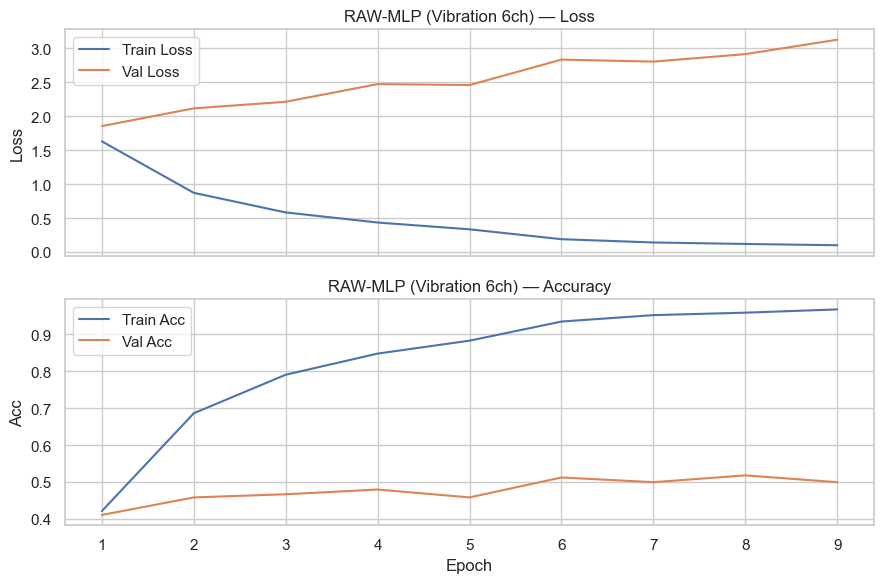


[RAW-MLP (Vibration 6ch)] TEST acc=0.5272  macro-F1=0.4240


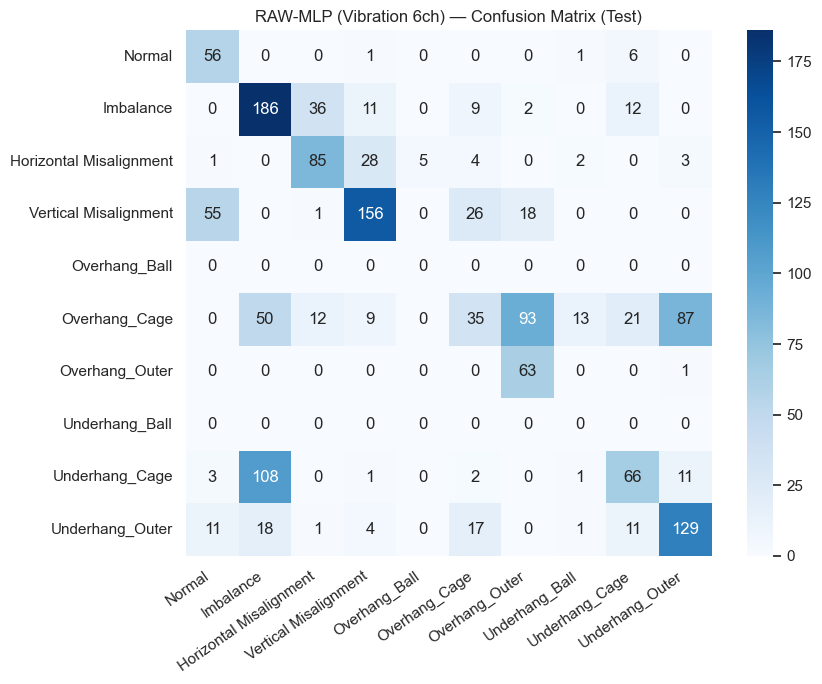

In [3]:
# -*- coding: utf-8 -*-
"""
Raw Vibration MLP (no handcrafted features):
- Reads filepaths & labels from MANIFEST_CSV
- Uses vibration columns 2..7 (1-based) => columns [1:7] (0-based)
- Windows each file into 5000-sample frames (50% overlap), z-score per window (per-channel)
- Flattens window (L,6) -> (L*6) and trains an MLP for 10 mega-classes
- Splits by FILE to avoid leakage (train/val/test)
- Plots train vs val curves and test confusion matrix
"""

import os, random
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from sklearn.utils import shuffle as sk_shuffle

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

# =========================
# CONFIG
# =========================
MANIFEST_CSV = r"E:\ali\PY Projects\MaFaulDa 1\MaFaulDa_subset_manifest.csv"

FS           = 50_000   # Hz (info)
WIN_LEN      = 5000
HOP          = 2500
MAX_WINS_PER_FILE = 64  # set None to use all windows per file

RANDOM_STATE = 42

# Training
BATCH    = 32
EPOCHS   = 60
LR       = 3e-4
WD       = 1e-4
PATIENCE = 8
DEVICE   = "cuda" if torch.cuda.is_available() else "cpu"
torch.backends.cudnn.benchmark = True

sns.set_theme(style="whitegrid", font_scale=1.0)
CMAP = "Blues"

# =========================
# LABELS (10-way)
# =========================
MEGA_CLASSES = [
    "Normal", "Imbalance", "Horizontal Misalignment", "Vertical Misalignment",
    "Overhang_Ball", "Overhang_Cage", "Overhang_Outer",
    "Underhang_Ball", "Underhang_Cage", "Underhang_Outer"
]
mega2id = {c:i for i,c in enumerate(MEGA_CLASSES)}
id2mega = {i:c for c,i in mega2id.items()}

def to_mega(super_class: str, subtype: str) -> str:
    if super_class == "Overhang":
        return {"ball_fault":"Overhang_Ball","cage_fault":"Overhang_Cage","outer_race":"Overhang_Outer"}[subtype]
    if super_class == "Underhang":
        return {"ball_fault":"Underhang_Ball","cage_fault":"Underhang_Cage","outer_race":"Underhang_Outer"}[subtype]
    return super_class

# =========================
# Helpers
# =========================
def windows_6ch(X, L=WIN_LEN, hop=HOP, limit=MAX_WINS_PER_FILE):
    """
    X: (N,6) float32
    Returns list of (L*6,) flattened windows, each z-scored per-window per-channel.
    """
    n = X.shape[0]
    starts = np.arange(0, max(1, n - L + 1), hop, dtype=int)
    if limit is not None and len(starts) > limit:
        idx = np.linspace(0, len(starts)-1, num=limit, dtype=int)
        starts = starts[idx]
    out = []
    for s in starts:
        w = X[s:s+L]
        if w.shape[0] == L:
            m  = w.mean(axis=0, keepdims=True)
            sd = w.std(axis=0, keepdims=True)
            wz = (w - m) / (sd + 1e-8)          # z-score per channel
            out.append(wz.reshape(-1))          # (L*6,)
    return out

def build_raw_vibration_dataset(manifest_csv: str):
    df = pd.read_csv(manifest_csv)
    df = df[df["super_class"].notna()].copy()
    files = df[["filepath","super_class","subtype"]].drop_duplicates()

    # Split by FILE (no leakage)
    tr_f, tmp_f = train_test_split(files, test_size=0.2, random_state=RANDOM_STATE,
                                   stratify=files["super_class"])
    va_f, te_f  = train_test_split(tmp_f, test_size=0.5, random_state=RANDOM_STATE,
                                   stratify=tmp_f["super_class"])
    splits = {"train": tr_f.reset_index(drop=True),
              "val":   va_f.reset_index(drop=True),
              "test":  te_f.reset_index(drop=True)}

    X_out, y_out = {}, {}
    for split, df_split in splits.items():
        Xs, ys = [], []
        for _, row in df_split.iterrows():
            try:
                arr = pd.read_csv(row["filepath"], header=None).values
                vib = arr[:, 1:7].astype(np.float32)   # columns 2..7 (1-based) => 1:7 (0-based)
            except Exception as e:
                print("skip:", row["filepath"], "err:", e)
                continue

            y = mega2id[to_mega(row["super_class"], row["subtype"])]
            for w in windows_6ch(vib):
                Xs.append(w)   # (L*6,)
                ys.append(y)

        X_out[split] = np.array(Xs, np.float32)
        y_out[split] = np.array(ys, np.int64)
        print(f"{split:>5} -> X:{X_out[split].shape}  y:{y_out[split].shape}")

    # Optional shuffle within each split
    for k in X_out.keys():
        X_out[k], y_out[k] = sk_shuffle(X_out[k], y_out[k], random_state=RANDOM_STATE)

    return X_out, y_out

# =========================
# MLP
# =========================
class MLP(nn.Module):
    def __init__(self, in_dim: int, n_classes: int):
        super().__init__()
        # Moderately sized MLP; adjust down if OOM
        self.net = nn.Sequential(
            nn.Linear(in_dim, 512), nn.ReLU(inplace=True), nn.Dropout(0.25),
            nn.Linear(512, 256),    nn.ReLU(inplace=True), nn.Dropout(0.25),
            nn.Linear(256, 128),    nn.ReLU(inplace=True), nn.Dropout(0.15),
            nn.Linear(128, n_classes)
        )
    def forward(self, x): return self.net(x)

def train_eval_raw_mlp(X, y, title="RAW-MLP (Vibration 6ch)"):
    Xtr, ytr = X["train"], y["train"]
    Xva, yva = X["val"],   y["val"]
    Xte, yte = X["test"],  y["test"]

    in_dim = Xtr.shape[1]
    print(f"\nInput dim: {in_dim} (expected ~ {WIN_LEN*6})")

    ds_tr = TensorDataset(torch.from_numpy(Xtr).float(), torch.from_numpy(ytr).long())
    ds_va = TensorDataset(torch.from_numpy(Xva).float(), torch.from_numpy(yva).long())
    ds_te = TensorDataset(torch.from_numpy(Xte).float(), torch.from_numpy(yte).long())
    dl_tr = DataLoader(ds_tr, batch_size=BATCH, shuffle=True)
    dl_va = DataLoader(ds_va, batch_size=max(1, BATCH*2), shuffle=False)
    dl_te = DataLoader(ds_te, batch_size=max(1, BATCH*2), shuffle=False)

    model = MLP(in_dim, n_classes=len(MEGA_CLASSES)).to(DEVICE)
    opt   = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=WD)
    sched = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, mode="min", factor=0.5, patience=3)
    crit  = nn.CrossEntropyLoss()

    best = {"loss": 1e9, "state": None, "epoch": -1}
    bad  = 0
    hist = {"tr_loss":[], "va_loss":[], "tr_acc":[], "va_acc":[]}

    for ep in range(1, EPOCHS+1):
        # Train
        model.train()
        tr_loss = tr_n = tr_ok = 0
        for xb, yb in dl_tr:
            xb, yb = xb.to(DEVICE), yb.to(DEVICE)
            opt.zero_grad(set_to_none=True)
            logits = model(xb)
            loss = crit(logits, yb)
            loss.backward(); opt.step()
            tr_loss += loss.item()*yb.size(0); tr_n += yb.size(0)
            tr_ok   += (logits.argmax(1)==yb).sum().item()
        tr_loss /= max(1, tr_n); tr_acc = tr_ok/max(1, tr_n)

        # Val
        model.eval()
        va_loss = va_n = va_ok = 0
        with torch.no_grad():
            for xb, yb in dl_va:
                xb, yb = xb.to(DEVICE), yb.to(DEVICE)
                logits = model(xb)
                loss = crit(logits, yb)
                va_loss += loss.item()*yb.size(0); va_n += yb.size(0)
                va_ok   += (logits.argmax(1)==yb).sum().item()
        va_loss /= max(1, va_n); va_acc = va_ok/max(1, va_n)
        hist["tr_loss"].append(tr_loss); hist["va_loss"].append(va_loss)
        hist["tr_acc"].append(tr_acc);   hist["va_acc"].append(va_acc)
        sched.step(va_loss)

        print(f"[{title} ep{ep:03d}] tr_loss={tr_loss:.4f} tr_acc={tr_acc:.3f} | val_loss={va_loss:.4f} val_acc={va_acc:.3f}")

        if va_loss < best["loss"]:
            best = {"loss": va_loss, "epoch": ep, "state": model.state_dict()}
            bad = 0
        else:
            bad += 1
            if bad >= PATIENCE:
                print(f"Early stop at ep{ep}, best ep{best['epoch']} val_loss={best['loss']:.4f}")
                break

    # Curves
    epochs = np.arange(1, len(hist["tr_loss"])+1)
    fig, axs = plt.subplots(2,1, figsize=(9,6), sharex=True)
    axs[0].plot(epochs, hist["tr_loss"], label="Train Loss")
    axs[0].plot(epochs, hist["va_loss"], label="Val Loss")
    axs[0].set_title(f"{title} — Loss"); axs[0].set_ylabel("Loss"); axs[0].legend()
    axs[1].plot(epochs, hist["tr_acc"], label="Train Acc")
    axs[1].plot(epochs, hist["va_acc"], label="Val Acc")
    axs[1].set_title(f"{title} — Accuracy"); axs[1].set_xlabel("Epoch"); axs[1].set_ylabel("Acc"); axs[1].legend()
    plt.tight_layout(); plt.show()

    # Test
    model.load_state_dict(best["state"]); model.eval()
    all_logits, all_y = [], []
    with torch.no_grad():
        for xb, yb in dl_te:
            xb = xb.to(DEVICE)
            logits = model(xb)
            all_logits.append(logits.cpu().numpy())
            all_y.append(yb.numpy())
    logits = np.vstack(all_logits)
    ytrue  = np.concatenate(all_y)
    yhat   = logits.argmax(1)
    acc = accuracy_score(ytrue, yhat)
    f1  = f1_score(ytrue, yhat, average="macro")
    print(f"\n[{title}] TEST acc={acc:.4f}  macro-F1={f1:.4f}")

    # Confusion matrix
    cm = confusion_matrix(ytrue, yhat, labels=np.arange(len(MEGA_CLASSES)))
    plt.figure(figsize=(9,7))
    sns.heatmap(cm, annot=True, fmt="d", cmap=CMAP,
                xticklabels=MEGA_CLASSES, yticklabels=MEGA_CLASSES,
                square=True, cbar=True)
    plt.xticks(rotation=35, ha="right"); plt.yticks(rotation=0)
    plt.title(f"{title} — Confusion Matrix (Test)")
    plt.tight_layout(); plt.show()

# =========================
# MAIN
# =========================
def main():
    random.seed(RANDOM_STATE); np.random.seed(RANDOM_STATE)
    X, y = build_raw_vibration_dataset(MANIFEST_CSV)
    train_eval_raw_mlp(X, y, title="RAW-MLP (Vibration 6ch)")

if __name__ == "__main__":
    main()


C:\Users\ali\AppData\Local\Temp\ipykernel_127052\352516249.py:87: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(feature_dir/csv_name)
C:\Users\ali\AppData\Local\Temp\ipykernel_127052\352516249.py:87: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(feature_dir/csv_name)



========== [TIME] SUPER-CLASS MLP ==========
[ep001] tr_loss=1.2249 tr_acc=0.523 | val_loss=0.8409 val_acc=0.690
[ep002] tr_loss=0.8219 tr_acc=0.683 | val_loss=0.6552 val_acc=0.748
[ep003] tr_loss=0.6684 tr_acc=0.745 | val_loss=0.5283 val_acc=0.802
[ep004] tr_loss=0.5912 tr_acc=0.774 | val_loss=0.4537 val_acc=0.825
[ep005] tr_loss=0.5301 tr_acc=0.796 | val_loss=0.4278 val_acc=0.830
[ep006] tr_loss=0.4901 tr_acc=0.809 | val_loss=0.3804 val_acc=0.857
[ep007] tr_loss=0.4583 tr_acc=0.820 | val_loss=0.3598 val_acc=0.861
[ep008] tr_loss=0.4395 tr_acc=0.829 | val_loss=0.3589 val_acc=0.862
[ep009] tr_loss=0.4210 tr_acc=0.838 | val_loss=0.3390 val_acc=0.870
[ep010] tr_loss=0.4137 tr_acc=0.838 | val_loss=0.3329 val_acc=0.868
[ep011] tr_loss=0.3948 tr_acc=0.844 | val_loss=0.3265 val_acc=0.872
[ep012] tr_loss=0.3833 tr_acc=0.853 | val_loss=0.3158 val_acc=0.876
[ep013] tr_loss=0.3797 tr_acc=0.851 | val_loss=0.3209 val_acc=0.865
[ep014] tr_loss=0.3725 tr_acc=0.855 | val_loss=0.3086 val_acc=0.874
[e

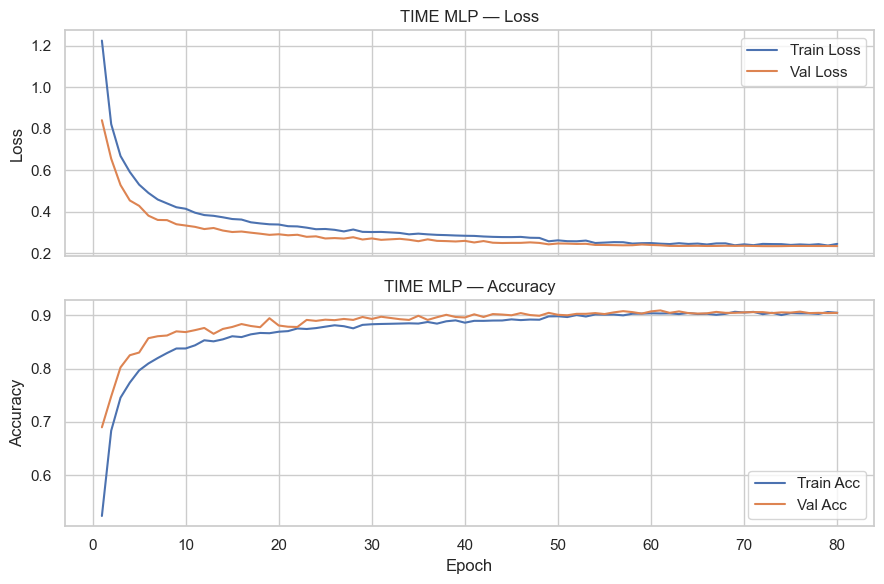

[TIME SUPER] TEST acc=0.919  f1=0.917


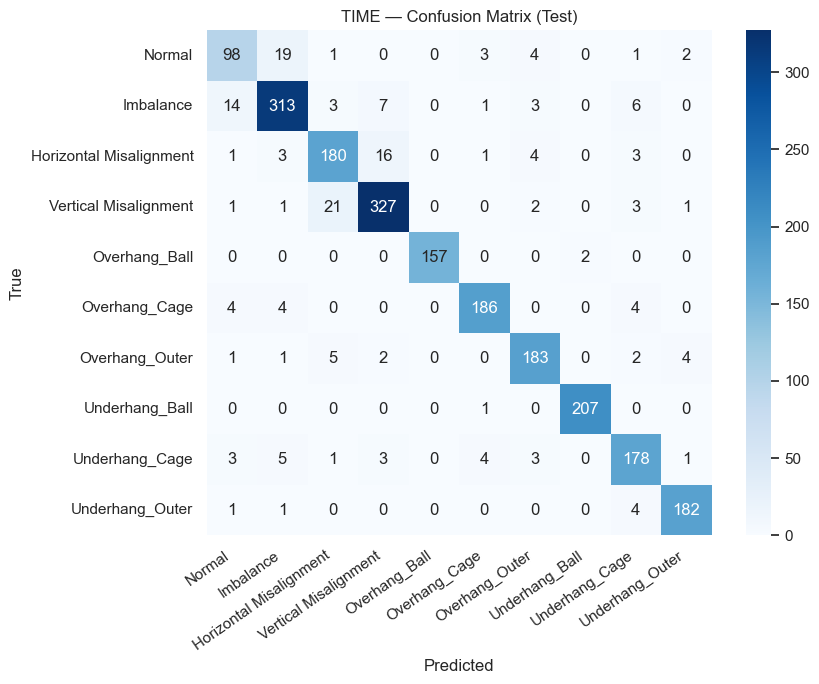


========== [FREQ] SUPER-CLASS MLP ==========
[ep001] tr_loss=0.9290 tr_acc=0.679 | val_loss=0.5255 val_acc=0.806
[ep002] tr_loss=0.5290 tr_acc=0.798 | val_loss=0.3735 val_acc=0.865
[ep003] tr_loss=0.4275 tr_acc=0.838 | val_loss=0.3066 val_acc=0.894
[ep004] tr_loss=0.3727 tr_acc=0.857 | val_loss=0.2756 val_acc=0.906
[ep005] tr_loss=0.3342 tr_acc=0.868 | val_loss=0.2429 val_acc=0.909
[ep006] tr_loss=0.3072 tr_acc=0.879 | val_loss=0.2308 val_acc=0.915
[ep007] tr_loss=0.2907 tr_acc=0.888 | val_loss=0.2152 val_acc=0.917
[ep008] tr_loss=0.2790 tr_acc=0.892 | val_loss=0.2027 val_acc=0.928
[ep009] tr_loss=0.2687 tr_acc=0.895 | val_loss=0.1986 val_acc=0.930
[ep010] tr_loss=0.2605 tr_acc=0.900 | val_loss=0.1880 val_acc=0.931
[ep011] tr_loss=0.2496 tr_acc=0.903 | val_loss=0.1822 val_acc=0.935
[ep012] tr_loss=0.2375 tr_acc=0.908 | val_loss=0.1788 val_acc=0.929
[ep013] tr_loss=0.2291 tr_acc=0.913 | val_loss=0.1756 val_acc=0.933
[ep014] tr_loss=0.2209 tr_acc=0.915 | val_loss=0.1695 val_acc=0.940
[e

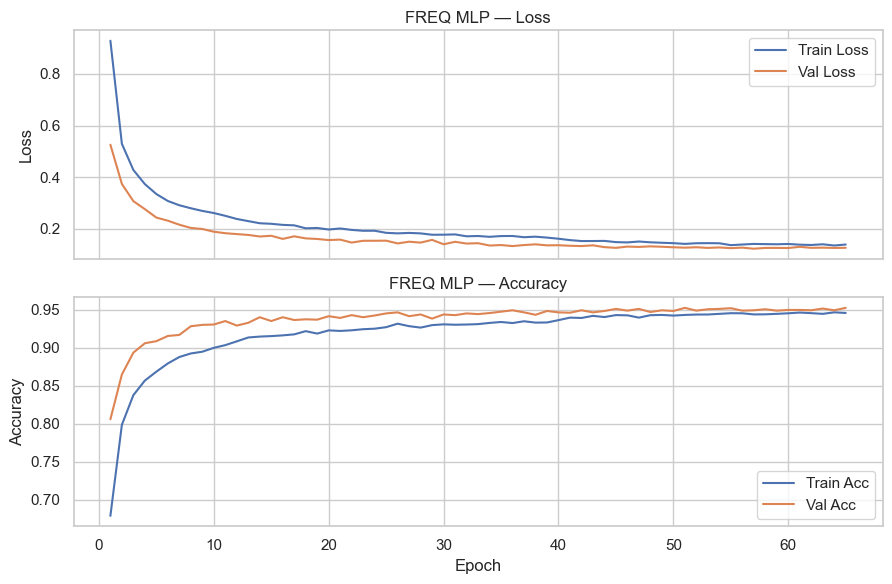

[FREQ SUPER] TEST acc=0.955  f1=0.955


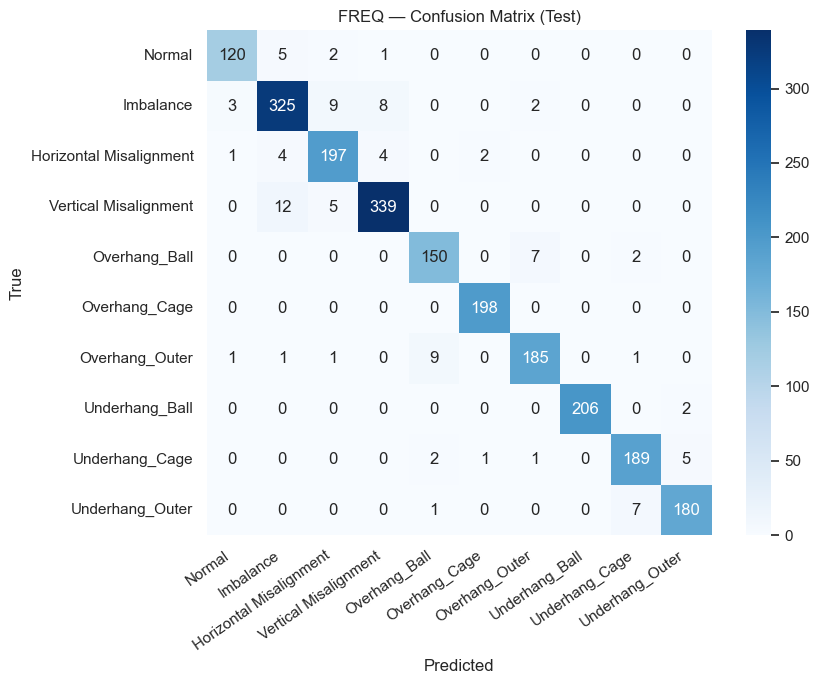


========== [TF] SUPER-CLASS MLP ==========
[ep001] tr_loss=1.4285 tr_acc=0.447 | val_loss=1.1316 val_acc=0.601
[ep002] tr_loss=1.1395 tr_acc=0.567 | val_loss=0.9899 val_acc=0.642
[ep003] tr_loss=1.0315 tr_acc=0.607 | val_loss=0.9015 val_acc=0.668
[ep004] tr_loss=0.9614 tr_acc=0.630 | val_loss=0.8398 val_acc=0.684
[ep005] tr_loss=0.9133 tr_acc=0.646 | val_loss=0.8131 val_acc=0.684
[ep006] tr_loss=0.8636 tr_acc=0.665 | val_loss=0.7544 val_acc=0.712
[ep007] tr_loss=0.8249 tr_acc=0.681 | val_loss=0.7252 val_acc=0.718
[ep008] tr_loss=0.7906 tr_acc=0.694 | val_loss=0.6820 val_acc=0.740
[ep009] tr_loss=0.7555 tr_acc=0.707 | val_loss=0.6548 val_acc=0.738
[ep010] tr_loss=0.7269 tr_acc=0.717 | val_loss=0.6214 val_acc=0.755
[ep011] tr_loss=0.7030 tr_acc=0.725 | val_loss=0.5970 val_acc=0.766
[ep012] tr_loss=0.6837 tr_acc=0.732 | val_loss=0.5714 val_acc=0.779
[ep013] tr_loss=0.6640 tr_acc=0.741 | val_loss=0.5502 val_acc=0.793
[ep014] tr_loss=0.6485 tr_acc=0.747 | val_loss=0.5312 val_acc=0.794
[ep0

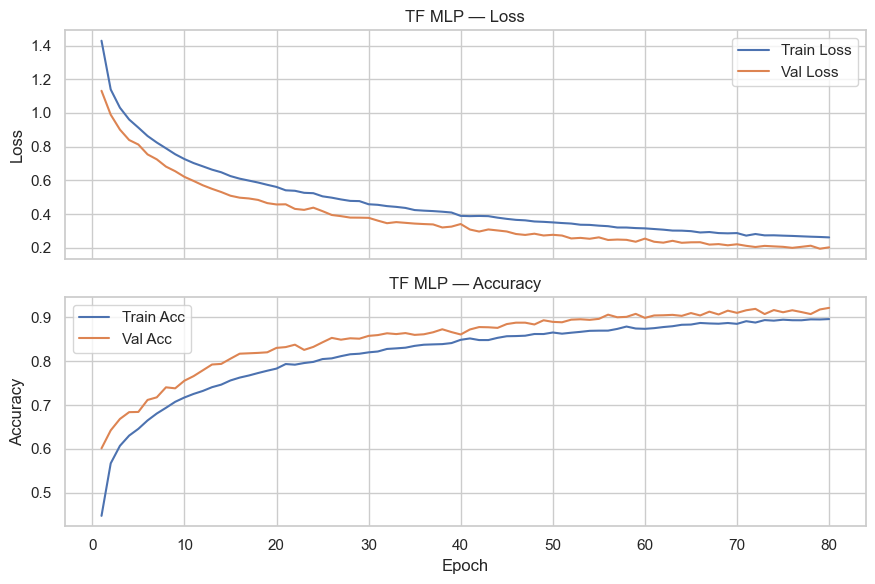

[TF SUPER] TEST acc=0.918  f1=0.922


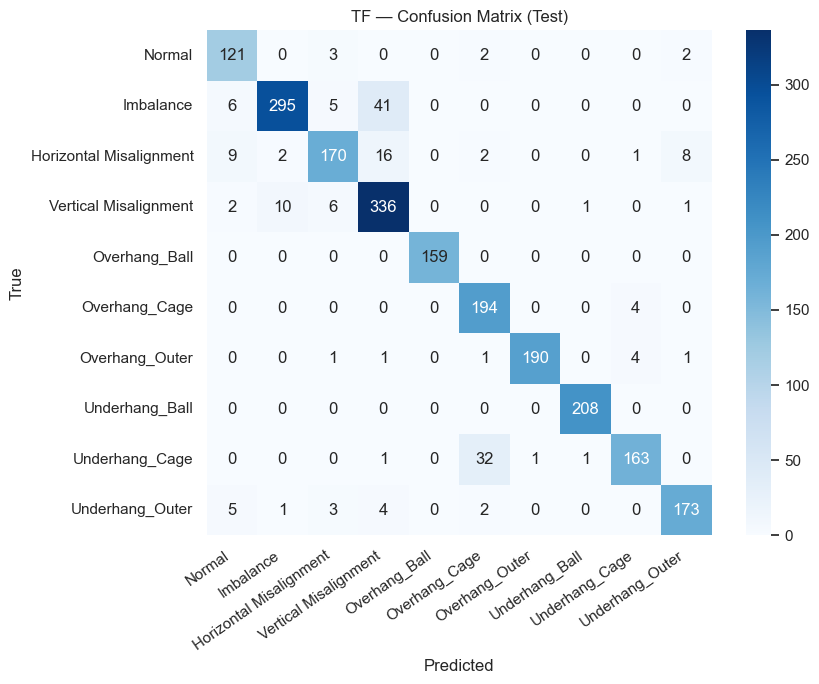


All requested models saved to: E:\ali\PY Projects\MaFaulDa 1\models\mlp_per_view


In [4]:
# -*- coding: utf-8 -*-
"""
Train 3 MLPs (time/freq/tf) on SELECTED features (LightGBM only for feature ranking).
Now also:
  • Plots Train vs Val Loss/Accuracy per view
  • Plots Confusion Matrix per view

Super-class task (10 classes):
  Normal, Imbalance, HM, VM,
  Overhang_Ball/Cage/Outer, Underhang_Ball/Cage/Outer
"""

import os, json, random
from pathlib import Path
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import joblib

# =========================
# CONFIG
# =========================
FEATURE_DIR = r"E:\ali\PY Projects\MaFaulDa 1\features"
SAVE_DIR    = r"E:\ali\PY Projects\MaFaulDa 1\models\mlp_per_view"
RANDOM_STATE= 42

# ---- toggles ----
TRAIN_VIEWS = {"time":1, "freq":1, "tf":1}   # pick which MLPs to train (0/1)
TRAIN_SUB   = 0                               # (kept for compatibility; not used for plots here)

# ---- selection size per view (Top-K features by LightGBM importance) ----
TOPK = {"time": 4, "freq": 4, "tf": 4}

# ---- data split ----
TEST_SIZE = 0.2
VAL_SIZE  = 0.5     # of temp => 10% val, 10% test

# ---- training ----
BATCH = 32
EPOCHS = 80
LR = 3e-4
WD = 1e-4
PATIENCE = 8
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
torch.backends.cudnn.benchmark = True

# ---- plots ----
sns.set_theme(style="whitegrid", font_scale=1.0)
CMAP = "Blues"

# =========================
# LABELS
# =========================
MEGA_CLASSES = [
    "Normal", "Imbalance", "Horizontal Misalignment", "Vertical Misalignment",
    "Overhang_Ball", "Overhang_Cage", "Overhang_Outer",
    "Underhang_Ball", "Underhang_Cage", "Underhang_Outer"
]
mega2id = {c:i for i,c in enumerate(MEGA_CLASSES)}

def to_mega(super_class: str, subtype: str) -> str:
    if super_class == "Overhang":
        return {"ball_fault":"Overhang_Ball",
                "cage_fault":"Overhang_Cage",
                "outer_race":"Overhang_Outer"}[subtype]
    if super_class == "Underhang":
        return {"ball_fault":"Underhang_Ball",
                "cage_fault":"Underhang_Cage",
                "outer_race":"Underhang_Outer"}[subtype]
    return super_class

# =========================
# IO helpers
# =========================
def load_view_table(feature_dir: Path, view: str):
    csv_name = {"time":"time_features.csv","freq":"freq_features.csv","tf":"tf_features.csv"}[view]
    df = pd.read_csv(feature_dir/csv_name)
    df = df[df["super_class"].notna()].reset_index(drop=True)
    prefix = {"time":"t_","freq":"f_","tf":"tf_"}[view]
    feat_cols = [c for c in df.columns if c.startswith(prefix)]
    X = df[feat_cols].copy()
    meta = df[["filepath","super_class","subtype"]].copy()
    y_mega = meta.apply(lambda r: mega2id[to_mega(r["super_class"], r["subtype"])], axis=1).to_numpy(int)
    return X, y_mega, meta, feat_cols

def split_once(y, test_size=TEST_SIZE, val_size=VAL_SIZE, rs=RANDOM_STATE):
    idx = np.arange(len(y))
    i_tr, i_tmp, y_tr, y_tmp = train_test_split(idx, y, test_size=test_size, random_state=rs, stratify=y)
    i_va, i_te, y_va, y_te = train_test_split(i_tmp, y_tmp, test_size=val_size, random_state=rs, stratify=y_tmp)
    return i_tr, i_va, i_te

# =========================
# Feature selection by LightGBM (train set only)
# =========================
def select_topk_features(X_df: pd.DataFrame, y: np.ndarray, k: int, view: str):
    lgbm = lgb.LGBMClassifier(
        n_estimators=600, learning_rate=0.05, num_leaves=96,
        subsample=0.9, colsample_bytree=0.8,
        random_state=RANDOM_STATE, n_jobs=-1, verbose=-1
    )
    lgbm.fit(X_df, y)
    imp = lgbm.feature_importances_
    order = np.argsort(-imp)
    k = min(k, len(order))
    top_cols = X_df.columns[order[:k]].tolist()
    return top_cols, imp[order[:k]]

# =========================
# Torch MLP
# =========================
class MLP(nn.Module):
    def __init__(self, in_dim: int, n_classes: int):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, 512), nn.ReLU(inplace=True), nn.Dropout(0.25),
            nn.Linear(512, 256),    nn.ReLU(inplace=True), nn.Dropout(0.25),
            nn.Linear(256, 128),    nn.ReLU(inplace=True), nn.Dropout(0.15),
            nn.Linear(128, n_classes)
        )
    def forward(self, x): return self.net(x)

def train_mlp(Xtr, ytr, Xva, yva, n_classes, save_path):
    scaler = StandardScaler()
    Xtr = scaler.fit_transform(Xtr)
    Xva = scaler.transform(Xva)

    ds_tr = TensorDataset(torch.from_numpy(Xtr).float(), torch.from_numpy(ytr).long())
    ds_va = TensorDataset(torch.from_numpy(Xva).float(), torch.from_numpy(yva).long())
    dl_tr = DataLoader(ds_tr, batch_size=BATCH, shuffle=True, drop_last=False)
    dl_va = DataLoader(ds_va, batch_size=BATCH*2, shuffle=False, drop_last=False)

    model = MLP(Xtr.shape[1], n_classes).to(DEVICE)
    opt = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=WD)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, mode="min", factor=0.5, patience=3)
    crit = nn.CrossEntropyLoss()

    best = {"loss": 1e9, "state": None, "epoch": -1}
    bad = 0
    hist = {"tr_loss": [], "va_loss": [], "tr_acc": [], "va_acc": []}

    for ep in range(1, EPOCHS+1):
        # train
        model.train()
        tr_loss, tr_n, tr_correct = 0.0, 0, 0
        for xb, yb in dl_tr:
            xb, yb = xb.to(DEVICE), yb.to(DEVICE)
            opt.zero_grad(set_to_none=True)
            logits = model(xb)
            loss = crit(logits, yb)
            loss.backward()
            opt.step()
            tr_loss += loss.item()*yb.size(0)
            tr_n += yb.size(0)
            tr_correct += (logits.argmax(1)==yb).sum().item()

        # val
        model.eval()
        va_loss, va_n, va_correct = 0.0, 0, 0
        with torch.no_grad():
            for xb, yb in dl_va:
                xb, yb = xb.to(DEVICE), yb.to(DEVICE)
                logits = model(xb)
                loss = crit(logits, yb)
                va_loss += loss.item()*yb.size(0)
                va_n += yb.size(0)
                va_correct += (logits.argmax(1)==yb).sum().item()

        tr_loss /= tr_n; va_loss /= va_n
        tr_acc = tr_correct/tr_n; va_acc = va_correct/va_n
        hist["tr_loss"].append(tr_loss); hist["va_loss"].append(va_loss)
        hist["tr_acc"].append(tr_acc);   hist["va_acc"].append(va_acc)
        scheduler.step(va_loss)

        print(f"[ep{ep:03d}] tr_loss={tr_loss:.4f} tr_acc={tr_acc:.3f} | val_loss={va_loss:.4f} val_acc={va_acc:.3f}")

        if va_loss < best["loss"]:
            best = {"loss": va_loss, "epoch": ep, "state": model.state_dict()}
            bad = 0
        else:
            bad += 1
            if bad >= PATIENCE:
                print(f"Early stop at ep{ep}, best ep{best['epoch']} val_loss={best['loss']:.4f}")
                break

    # save scaler + model
    torch.save(best["state"], save_path)
    return scaler, best["state"], hist

def eval_mlp(Xte, yte, scaler, state, in_dim, n_classes):
    Xte = scaler.transform(Xte)
    ds = TensorDataset(torch.from_numpy(Xte).float(), torch.from_numpy(yte).long())
    dl = DataLoader(ds, batch_size=BATCH*2, shuffle=False)

    model = MLP(in_dim, n_classes).to(DEVICE)
    model.load_state_dict(state)
    model.eval()

    all_logits, all_y = [], []
    with torch.no_grad():
        for xb, yb in dl:
            xb = xb.to(DEVICE)
            logits = model(xb)
            all_logits.append(logits.cpu().numpy())
            all_y.append(yb.numpy())
    logits = np.vstack(all_logits)
    ytrue  = np.concatenate(all_y)
    yhat   = logits.argmax(1)
    acc = accuracy_score(ytrue, yhat)
    f1  = f1_score(ytrue, yhat, average="macro")
    return acc, f1, yhat, logits

# =========================
# Plot helpers
# =========================
def plot_curves(hist: dict, title: str):
    epochs = np.arange(1, len(hist["tr_loss"])+1)
    fig, axs = plt.subplots(2, 1, figsize=(9, 6), sharex=True)
    # Loss
    axs[0].plot(epochs, hist["tr_loss"], label="Train Loss")
    axs[0].plot(epochs, hist["va_loss"], label="Val Loss")
    axs[0].set_ylabel("Loss"); axs[0].set_title(title + " — Loss")
    axs[0].legend()
    # Acc
    axs[1].plot(epochs, hist["tr_acc"], label="Train Acc")
    axs[1].plot(epochs, hist["va_acc"], label="Val Acc")
    axs[1].set_xlabel("Epoch"); axs[1].set_ylabel("Accuracy"); axs[1].set_title(title + " — Accuracy")
    axs[1].legend()
    plt.tight_layout()
    plt.show()

def plot_confusion(y_true, y_pred, title: str):
    cm = confusion_matrix(y_true, y_pred, labels=np.arange(len(MEGA_CLASSES)))
    fig, ax = plt.subplots(figsize=(9, 7))
    sns.heatmap(cm, annot=True, fmt="d", cmap=CMAP,
                xticklabels=MEGA_CLASSES, yticklabels=MEGA_CLASSES,
                cbar=True, square=True, ax=ax)
    ax.set_xlabel("Predicted")
    ax.set_ylabel("True")
    ax.set_title(title)
    plt.xticks(rotation=35, ha="right")
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

# =========================
# MAIN LOOP
# =========================
def main():
    random.seed(RANDOM_STATE); np.random.seed(RANDOM_STATE)
    feat_dir = Path(FEATURE_DIR)
    out_dir  = Path(SAVE_DIR); out_dir.mkdir(parents=True, exist_ok=True)

    # Load (share split across views)
    views_data = {}
    for view in ["time","freq","tf"]:
        X, y_mega, meta, feat_cols = load_view_table(feat_dir, view)
        views_data[view] = {"X":X, "y":y_mega, "meta":meta, "cols":feat_cols}
    n = len(views_data["freq"]["y"])
    assert all(len(views_data[v]["y"])==n for v in ["time","freq","tf"])

    i_tr,i_va,i_te = split_once(views_data["freq"]["y"])
    (out_dir/"split_indices_super.json").write_text(
        json.dumps({"train":i_tr.tolist(), "val":i_va.tolist(), "test":i_te.tolist()}, indent=2),
        encoding="utf-8"
    )

    for view in ["time","freq","tf"]:
        if not TRAIN_VIEWS[view]:
            print(f"Skip {view} (toggle off).")
            continue

        print(f"\n========== [{view.upper()}] SUPER-CLASS MLP ==========")
        X = views_data[view]["X"]; y = views_data[view]["y"]
        Xtr, Xva, Xte = X.iloc[i_tr], X.iloc[i_va], X.iloc[i_te]
        ytr, yva, yte = y[i_tr], y[i_va], y[i_te]

        # LightGBM selection (train only)
        top_cols, _ = select_topk_features(Xtr, ytr, TOPK[view], view)
        (out_dir/f"{view}_super_selected_cols.json").write_text(
            json.dumps({"feature_cols": top_cols}, indent=2), encoding="utf-8"
        )

        # Train + curves
        Xtr_sel = Xtr[top_cols].to_numpy(np.float32)
        Xva_sel = Xva[top_cols].to_numpy(np.float32)
        Xte_sel = Xte[top_cols].to_numpy(np.float32)

        scaler, best_state, hist = train_mlp(
            Xtr_sel, ytr, Xva_sel, yva,
            n_classes=len(MEGA_CLASSES),
            save_path=out_dir/f"{view}_super_mlp.pt"
        )
        plot_curves(hist, title=f"{view.upper()} MLP")

        # Eval + confusion matrix
        acc, f1, yhat, logits = eval_mlp(
            Xte_sel, yte, scaler, best_state,
            in_dim=Xtr_sel.shape[1], n_classes=len(MEGA_CLASSES)
        )
        print(f"[{view.upper()} SUPER] TEST acc={acc:.3f}  f1={f1:.3f}")
        plot_confusion(yte, yhat, title=f"{view.upper()} — Confusion Matrix (Test)")

        # Save artifacts
        joblib.dump(scaler, out_dir/f"{view}_super_scaler.joblib")
        (out_dir/f"{view}_super_meta.json").write_text(
            json.dumps({"in_dim": Xtr_sel.shape[1], "classes": MEGA_CLASSES}, indent=2), encoding="utf-8"
        )

    print("\nAll requested models saved to:", out_dir)

if __name__ == "__main__":
    main()


C:\Users\ali\AppData\Local\Temp\ipykernel_127052\1979669885.py:94: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(feature_dir/csv_name)
C:\Users\ali\AppData\Local\Temp\ipykernel_127052\1979669885.py:94: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(feature_dir/csv_name)


Split sizes: 17503 2188 2188

========== [TIME] 10-class MLP ==========


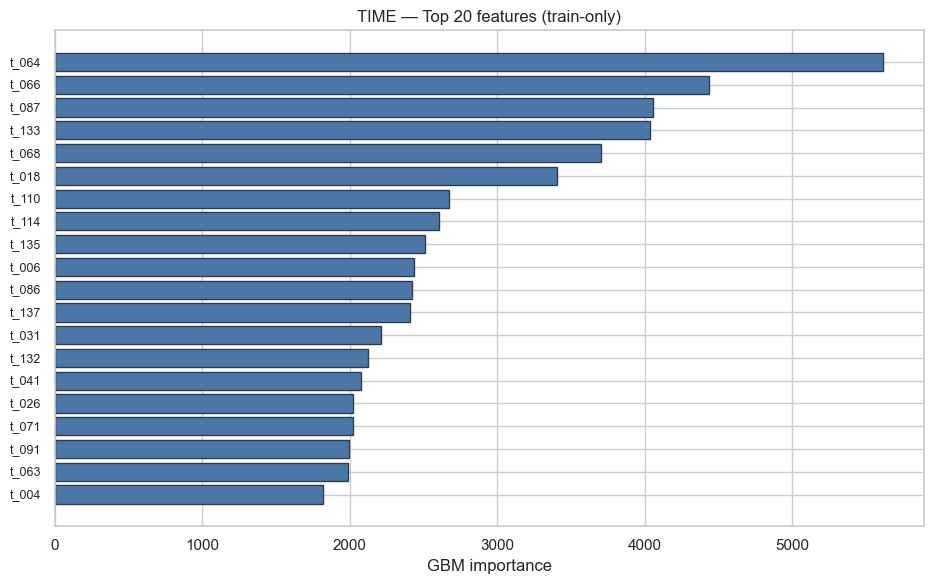

time: selected 3 features.
[ep001] tr_loss=1.2992 tr_acc=0.478 | val_loss=0.9438 val_acc=0.630
[ep002] tr_loss=0.9239 tr_acc=0.625 | val_loss=0.7440 val_acc=0.705
[ep003] tr_loss=0.7990 tr_acc=0.675 | val_loss=0.6749 val_acc=0.739
[ep004] tr_loss=0.7365 tr_acc=0.698 | val_loss=0.6192 val_acc=0.750
[ep005] tr_loss=0.6993 tr_acc=0.715 | val_loss=0.6115 val_acc=0.756
[ep006] tr_loss=0.6725 tr_acc=0.722 | val_loss=0.5693 val_acc=0.774
[ep007] tr_loss=0.6525 tr_acc=0.730 | val_loss=0.5543 val_acc=0.774
[ep008] tr_loss=0.6373 tr_acc=0.738 | val_loss=0.5505 val_acc=0.776
[ep009] tr_loss=0.6202 tr_acc=0.744 | val_loss=0.5380 val_acc=0.784
[ep010] tr_loss=0.6023 tr_acc=0.753 | val_loss=0.5263 val_acc=0.788
[ep011] tr_loss=0.5908 tr_acc=0.755 | val_loss=0.5176 val_acc=0.799
[ep012] tr_loss=0.5835 tr_acc=0.761 | val_loss=0.5102 val_acc=0.796
[ep013] tr_loss=0.5831 tr_acc=0.764 | val_loss=0.5057 val_acc=0.793
[ep014] tr_loss=0.5696 tr_acc=0.764 | val_loss=0.4987 val_acc=0.794
[ep015] tr_loss=0.566

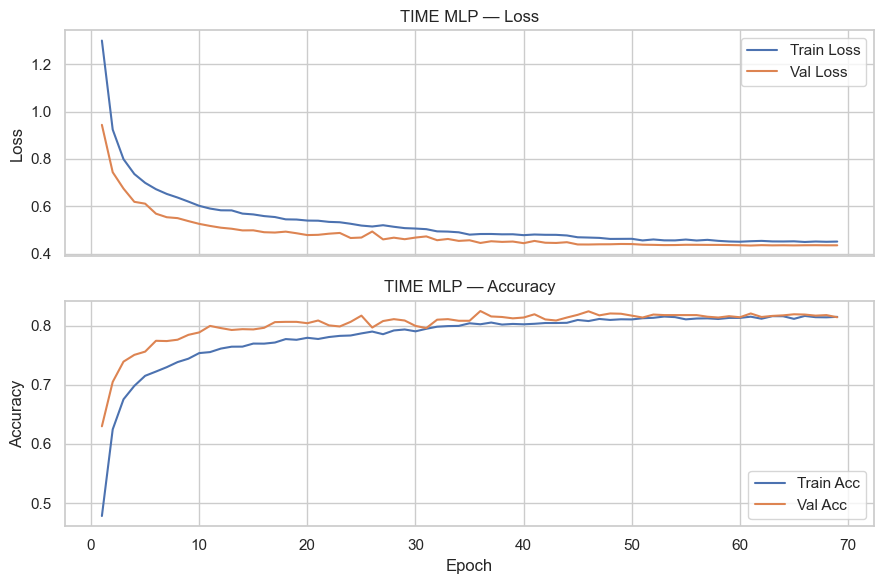

[TIME] TEST acc=0.8250  macro-F1=0.8211


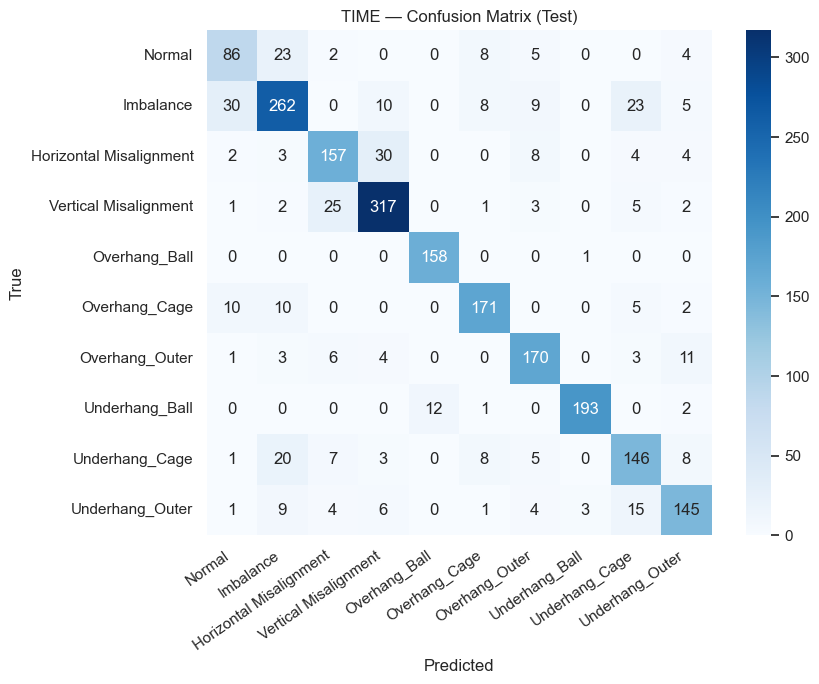


========== [FREQ] 10-class MLP ==========


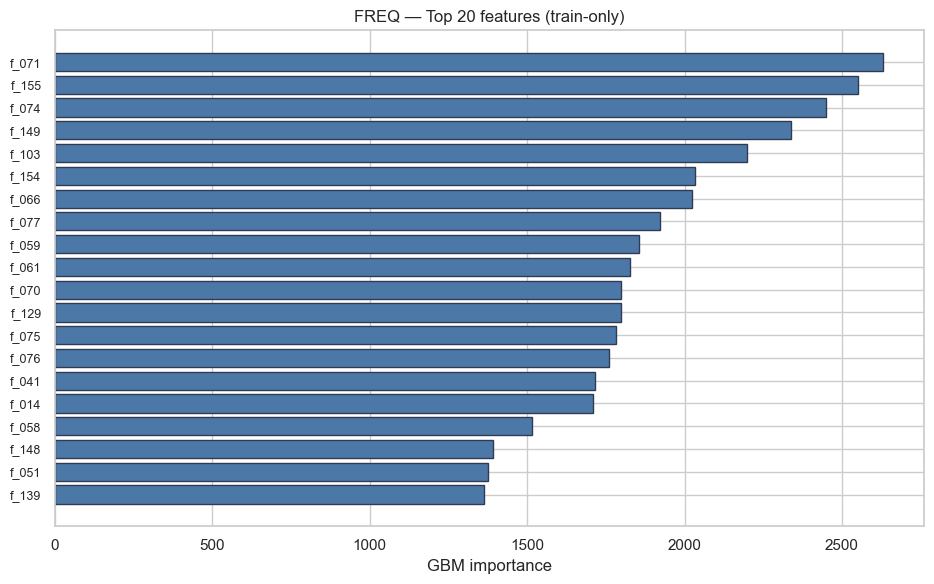

freq: selected 3 features.
[ep001] tr_loss=0.9648 tr_acc=0.644 | val_loss=0.6268 val_acc=0.748
[ep002] tr_loss=0.6605 tr_acc=0.735 | val_loss=0.5521 val_acc=0.770
[ep003] tr_loss=0.5901 tr_acc=0.762 | val_loss=0.4639 val_acc=0.810
[ep004] tr_loss=0.5471 tr_acc=0.773 | val_loss=0.4682 val_acc=0.809
[ep005] tr_loss=0.5142 tr_acc=0.789 | val_loss=0.4210 val_acc=0.837
[ep006] tr_loss=0.4917 tr_acc=0.799 | val_loss=0.4099 val_acc=0.835
[ep007] tr_loss=0.4776 tr_acc=0.806 | val_loss=0.3907 val_acc=0.837
[ep008] tr_loss=0.4639 tr_acc=0.811 | val_loss=0.3861 val_acc=0.845
[ep009] tr_loss=0.4578 tr_acc=0.814 | val_loss=0.3880 val_acc=0.847
[ep010] tr_loss=0.4428 tr_acc=0.821 | val_loss=0.4027 val_acc=0.840
[ep011] tr_loss=0.4339 tr_acc=0.822 | val_loss=0.3740 val_acc=0.851
[ep012] tr_loss=0.4309 tr_acc=0.822 | val_loss=0.3522 val_acc=0.861
[ep013] tr_loss=0.4171 tr_acc=0.828 | val_loss=0.3557 val_acc=0.852
[ep014] tr_loss=0.4210 tr_acc=0.829 | val_loss=0.3479 val_acc=0.857
[ep015] tr_loss=0.406

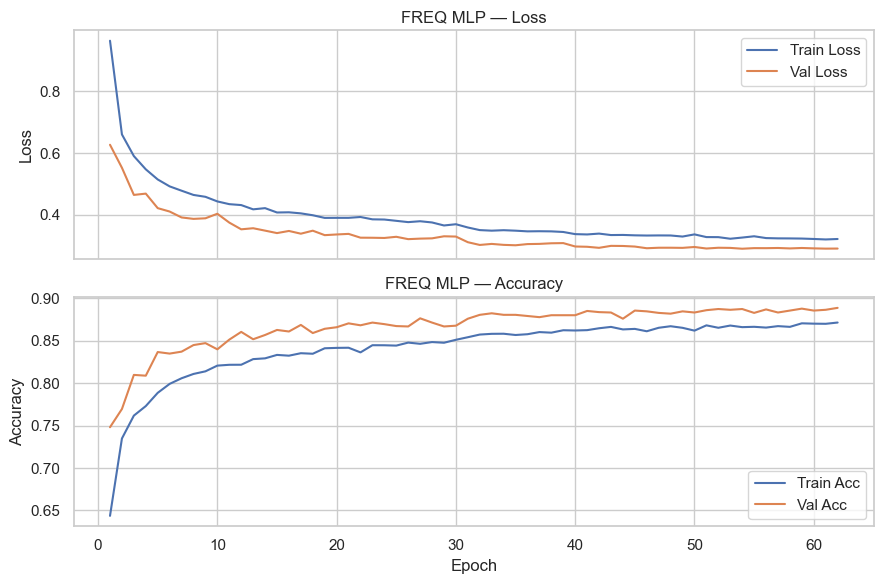

[FREQ] TEST acc=0.8752  macro-F1=0.8615


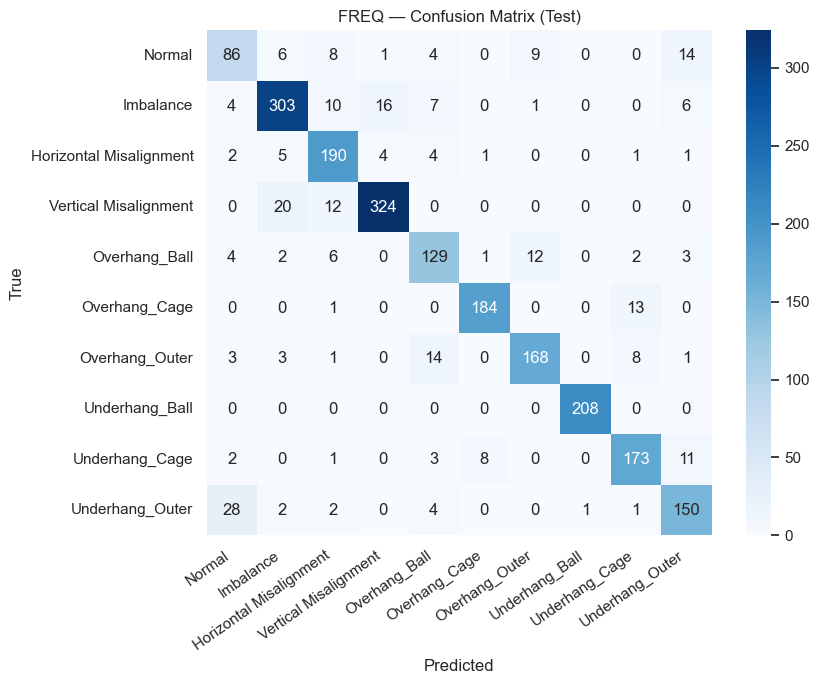


========== [TF] 10-class MLP ==========


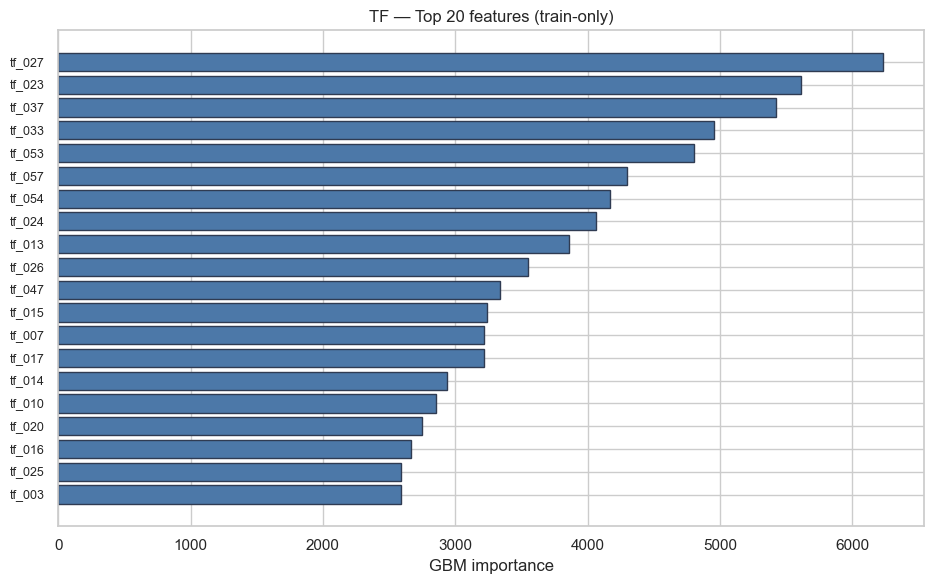

tf: selected 3 features.
[ep001] tr_loss=1.4274 tr_acc=0.442 | val_loss=1.1851 val_acc=0.552
[ep002] tr_loss=1.2013 tr_acc=0.530 | val_loss=1.0607 val_acc=0.612
[ep003] tr_loss=1.1173 tr_acc=0.564 | val_loss=1.0285 val_acc=0.579
[ep004] tr_loss=1.0326 tr_acc=0.595 | val_loss=0.9085 val_acc=0.656
[ep005] tr_loss=0.9744 tr_acc=0.616 | val_loss=0.8797 val_acc=0.659
[ep006] tr_loss=0.9366 tr_acc=0.628 | val_loss=0.8254 val_acc=0.680
[ep007] tr_loss=0.9058 tr_acc=0.648 | val_loss=0.8027 val_acc=0.683
[ep008] tr_loss=0.8777 tr_acc=0.659 | val_loss=0.7709 val_acc=0.698
[ep009] tr_loss=0.8520 tr_acc=0.663 | val_loss=0.7727 val_acc=0.699
[ep010] tr_loss=0.8334 tr_acc=0.672 | val_loss=0.7335 val_acc=0.710
[ep011] tr_loss=0.8178 tr_acc=0.681 | val_loss=0.7175 val_acc=0.713
[ep012] tr_loss=0.7963 tr_acc=0.690 | val_loss=0.7271 val_acc=0.712
[ep013] tr_loss=0.7952 tr_acc=0.689 | val_loss=0.7097 val_acc=0.720
[ep014] tr_loss=0.7799 tr_acc=0.694 | val_loss=0.6956 val_acc=0.725
[ep015] tr_loss=0.7699 

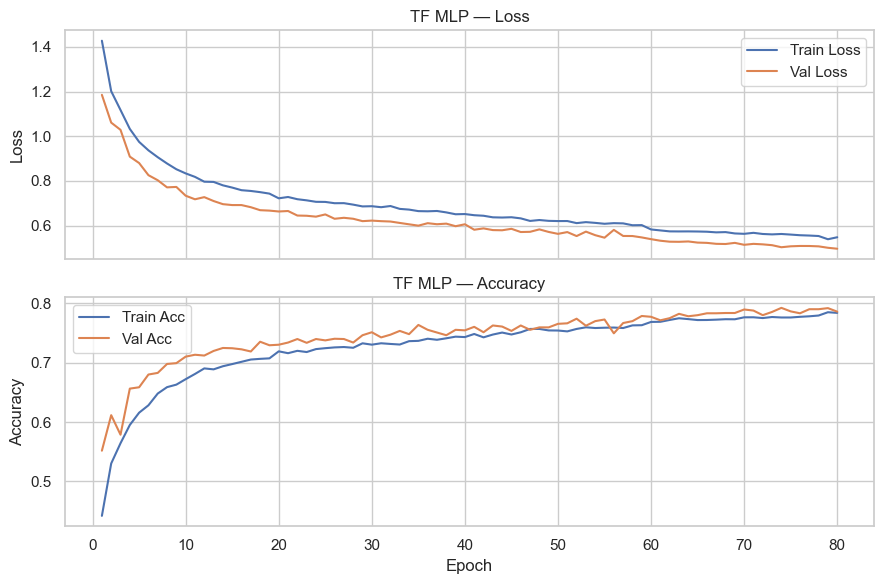

[TF] TEST acc=0.8067  macro-F1=0.8109


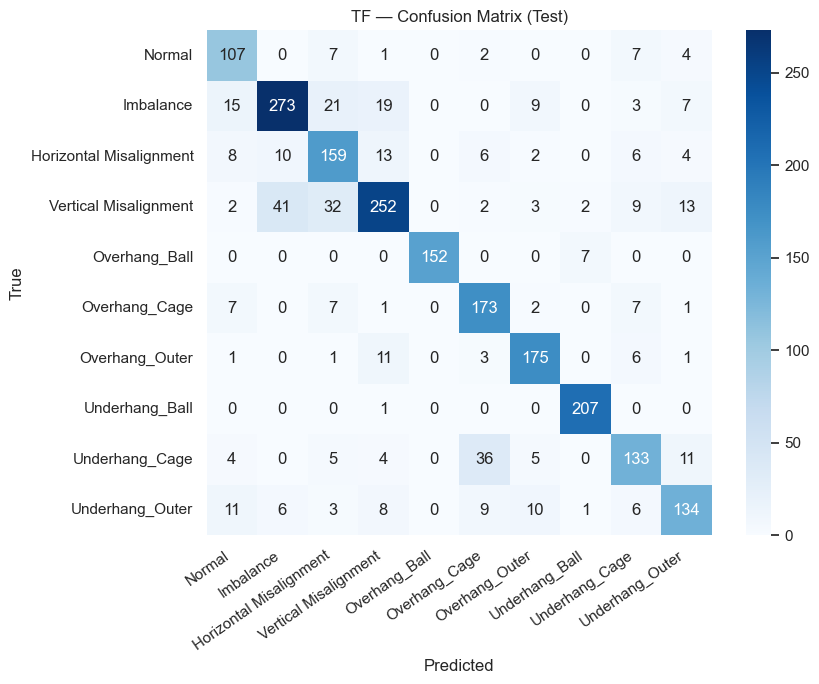


========== Decision-level Fusion (equal weights) ==========
[FUSION/Decision] TEST acc=0.9813  macro-F1=0.9809


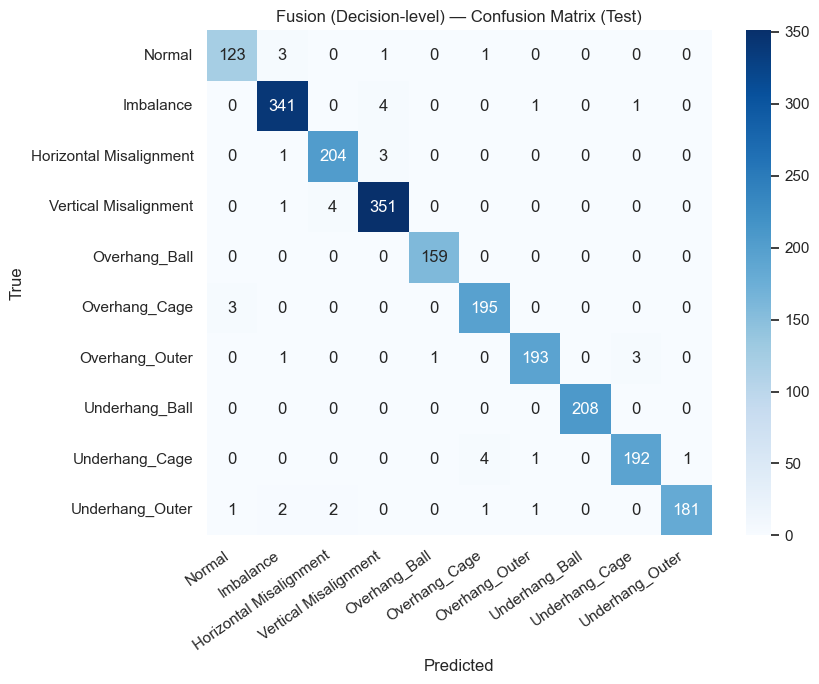


========== Feature-level Fusion (concatenate selected features) ==========


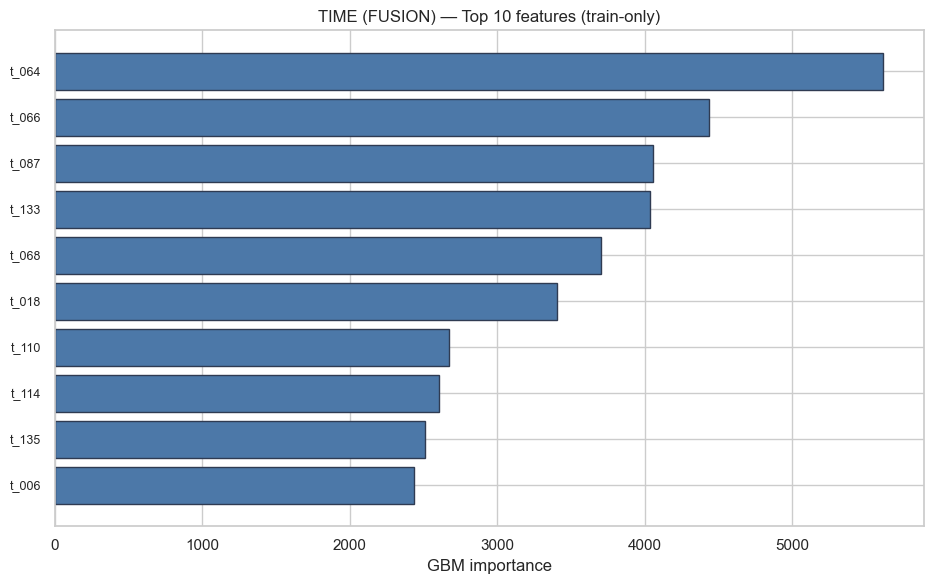

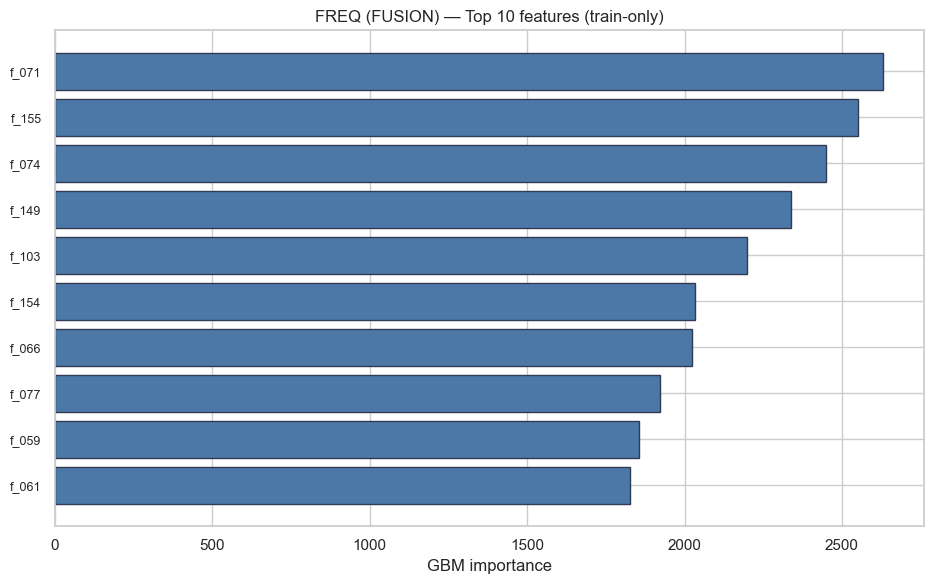

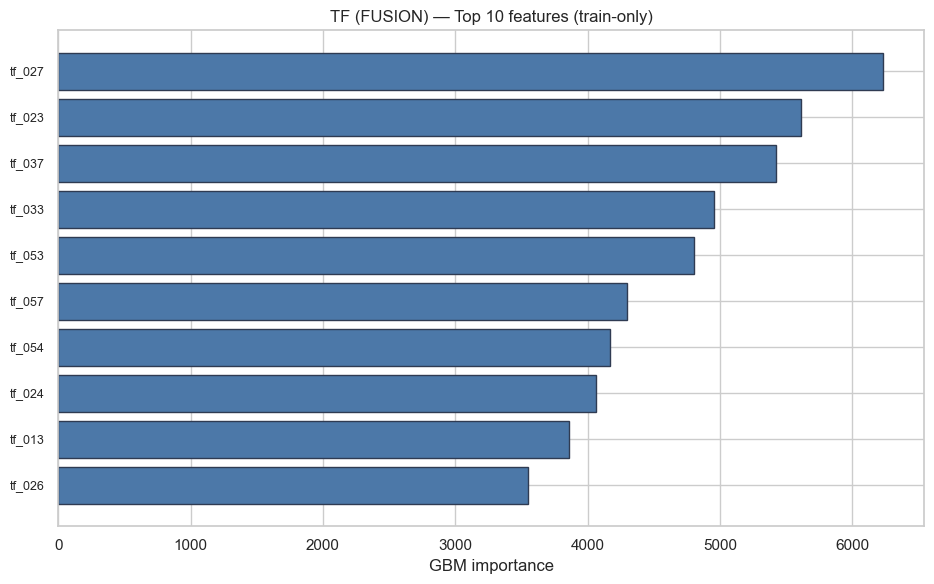

Selected features per view for fusion: {'time': 3, 'freq': 3, 'tf': 3}
[ep001] tr_loss=0.5190 tr_acc=0.827 | val_loss=0.1042 val_acc=0.973
[ep002] tr_loss=0.1202 tr_acc=0.960 | val_loss=0.0638 val_acc=0.979
[ep003] tr_loss=0.0782 tr_acc=0.973 | val_loss=0.0373 val_acc=0.988
[ep004] tr_loss=0.0597 tr_acc=0.978 | val_loss=0.0291 val_acc=0.989
[ep005] tr_loss=0.0431 tr_acc=0.985 | val_loss=0.0247 val_acc=0.990
[ep006] tr_loss=0.0402 tr_acc=0.986 | val_loss=0.0179 val_acc=0.994
[ep007] tr_loss=0.0343 tr_acc=0.989 | val_loss=0.0181 val_acc=0.994
[ep008] tr_loss=0.0267 tr_acc=0.991 | val_loss=0.0126 val_acc=0.995
[ep009] tr_loss=0.0233 tr_acc=0.992 | val_loss=0.0108 val_acc=0.997
[ep010] tr_loss=0.0254 tr_acc=0.991 | val_loss=0.0210 val_acc=0.992
[ep011] tr_loss=0.0231 tr_acc=0.993 | val_loss=0.0087 val_acc=0.998
[ep012] tr_loss=0.0209 tr_acc=0.993 | val_loss=0.0127 val_acc=0.995
[ep013] tr_loss=0.0164 tr_acc=0.995 | val_loss=0.0103 val_acc=0.996
[ep014] tr_loss=0.0207 tr_acc=0.993 | val_los

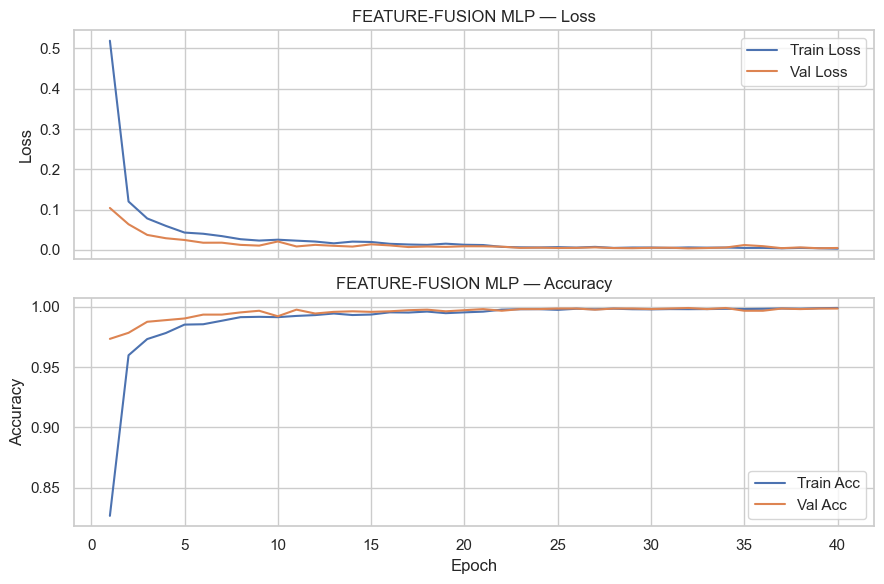

[FUSION/Feature] TEST acc=0.9995  macro-F1=0.9995


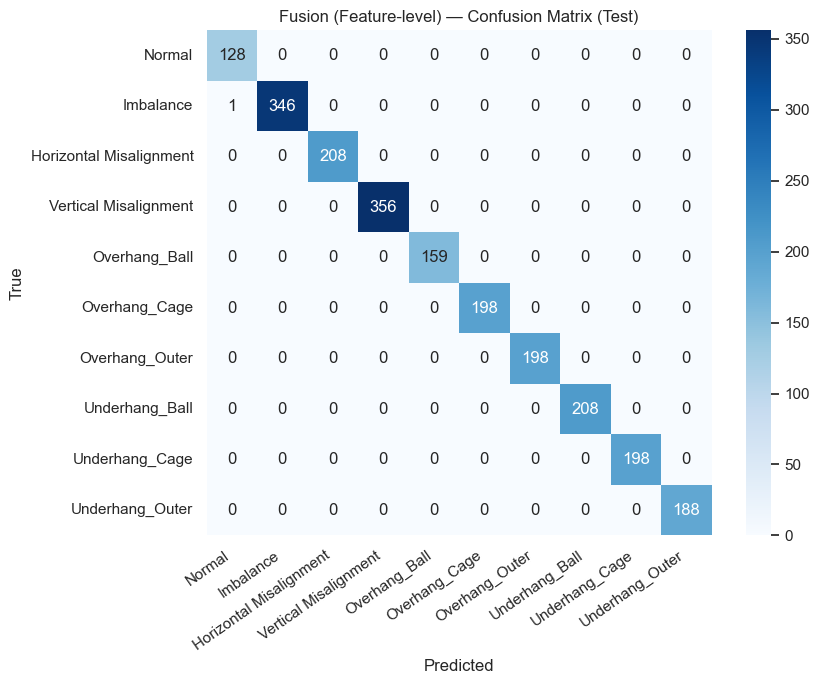

In [5]:
# -*- coding: utf-8 -*-
"""
Per-view MLPs (time / freq / tf) for 10-class classification.
- LightGBM used ONLY for feature selection (train split).
- Shows inline matplotlib figures in console:
    * Top-20 GBM feature importances (per view)
    * Train vs Val loss & accuracy curves (per view)
    * Confusion matrix (per view)
    * Optional decision-level fusion confusion matrix
    * Optional feature-level fusion training & evaluation

Assumes feature CSVs exist in FEATURE_DIR:
  - time_features.csv  (t_*)
  - freq_features.csv  (f_*)
  - tf_features.csv    (tf_*)
"""

import json, random
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from sklearn.preprocessing import StandardScaler

import lightgbm as lgb
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

# =========================
# CONFIG
# =========================
FEATURE_DIR = r"E:\ali\PY Projects\MaFaulDa 1\features"
RANDOM_STATE = 42

# Train which views?
TRAIN_VIEWS = {"time": 1, "freq": 1, "tf": 1}

# Evaluate decision-level fusion of available trained views?
DO_FUSION = 1   # 0/1

# (NEW) Train a feature-level fusion model?
DO_FEATURE_FUSION = 1  # 0/1

# Feature selection Top-K per view for single-view models
TOPK = {"time": 3, "freq": 3, "tf": 3}

# (NEW) Feature selection Top-K per view for FEATURE-LEVEL fusion
TOPK_FUSION = {"time": 3, "freq": 3, "tf": 3}

# Splits
TEST_SIZE = 0.2
VAL_SIZE  = 0.5    # 10% val, 10% test (after temp split)

# Training hyperparams
BATCH    = 128
EPOCHS   = 80
LR       = 12e-4
WD       = 1e-4
PATIENCE = 8
DEVICE   = "cuda" if torch.cuda.is_available() else "cpu"
torch.backends.cudnn.benchmark = True

# Plot style
CMAP = "viridis"
BAR_COLOR = "#4C78A8"
BAR_EDGE  = "#2F3B52"

# =========================
# LABELS (10-way)
# =========================
MEGA_CLASSES = [
    "Normal", "Imbalance", "Horizontal Misalignment", "Vertical Misalignment",
    "Overhang_Ball", "Overhang_Cage", "Overhang_Outer",
    "Underhang_Ball", "Underhang_Cage", "Underhang_Outer"
]
mega2id = {c:i for i,c in enumerate(MEGA_CLASSES)}

def to_mega(super_class: str, subtype: str) -> str:
    if super_class == "Overhang":
        return {"ball_fault":"Overhang_Ball","cage_fault":"Overhang_Cage","outer_race":"Overhang_Outer"}[subtype]
    if super_class == "Underhang":
        return {"ball_fault":"Underhang_Ball","cage_fault":"Underhang_Cage","outer_race":"Underhang_Outer"}[subtype]
    return super_class

# =========================
# Data helpers
# =========================
def load_view_table(feature_dir: Path, view: str):
    csv_name = {"time":"time_features.csv","freq":"freq_features.csv","tf":"tf_features.csv"}[view]
    df = pd.read_csv(feature_dir/csv_name)
    df = df[df["super_class"].notna()].reset_index(drop=True)
    prefix = {"time":"t_","freq":"f_","tf":"tf_"}[view]
    feat_cols = [c for c in df.columns if c.startswith(prefix)]
    X = df[feat_cols].copy()
    meta = df[["filepath","super_class","subtype"]].copy()
    y_mega = meta.apply(lambda r: mega2id[to_mega(r["super_class"], r["subtype"])], axis=1).to_numpy(int)
    return X, y_mega, feat_cols

def split_once(y, test_size=TEST_SIZE, val_size=VAL_SIZE, rs=RANDOM_STATE):
    idx = np.arange(len(y))
    i_tr, i_tmp, y_tr, y_tmp = train_test_split(idx, y, test_size=test_size, random_state=rs, stratify=y)
    i_va, i_te, y_va, y_te = train_test_split(i_tmp, y_tmp, test_size=val_size, random_state=rs, stratify=y_tmp)
    return i_tr, i_va, i_te

# =========================
# GBM Feature selection (train-only) + importance plot
# =========================
def gbm_select_and_plot(Xtr_df: pd.DataFrame, ytr: np.ndarray, k: int, view: str, topn_plot: int = 20):
    gbm = lgb.LGBMClassifier(
        n_estimators=600, learning_rate=0.05, num_leaves=96,
        subsample=0.9, colsample_bytree=0.8,
        random_state=RANDOM_STATE, n_jobs=-1,
        verbose=-1
    )
    gbm.fit(Xtr_df, ytr)
    importances = gbm.feature_importances_
    names = np.array(Xtr_df.columns)
    order = np.argsort(-importances)

    # --- plot Top-N importances (horizontal bar) ---
    topn = min(topn_plot, len(order))
    top_feats = names[order[:topn]]
    top_vals  = importances[order[:topn]]

    fig, ax = plt.subplots(figsize=(9.5, 6))
    ypos = np.arange(topn)
    ax.barh(ypos, top_vals, color=BAR_COLOR, edgecolor=BAR_EDGE)
    ax.set_yticks(ypos); ax.set_yticklabels(top_feats, fontsize=9)
    ax.invert_yaxis()
    ax.set_xlabel("GBM importance")
    ax.set_title(f"{view.upper()} — Top {topn} features (train-only)")
    plt.tight_layout()
    plt.show()

    # return Top-K for training
    k = min(k, len(order))
    return names[order[:k]].tolist()

# =========================
# Torch MLP
# =========================
class MLP(nn.Module):
    def __init__(self, in_dim: int, n_classes: int):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, 512), nn.ReLU(inplace=True), nn.Dropout(0.25),
            nn.Linear(512, 256),    nn.ReLU(inplace=True), nn.Dropout(0.25),
            nn.Linear(256, 128),    nn.ReLU(inplace=True), nn.Dropout(0.15),
            nn.Linear(128, n_classes)
        )
    def forward(self, x): return self.net(x)

def train_mlp(Xtr, ytr, Xva, yva, n_classes):
    """Train with history for plotting. Returns: scaler, best_state, history dict"""
    scaler = StandardScaler()
    Xtr = scaler.fit_transform(Xtr)
    Xva = scaler.transform(Xva)

    ds_tr = TensorDataset(torch.from_numpy(Xtr).float(), torch.from_numpy(ytr).long())
    ds_va = TensorDataset(torch.from_numpy(Xva).float(), torch.from_numpy(yva).long())
    dl_tr = DataLoader(ds_tr, batch_size=BATCH, shuffle=True)
    dl_va = DataLoader(ds_va, batch_size=BATCH*2, shuffle=False)

    model = MLP(Xtr.shape[1], n_classes).to(DEVICE)
    opt = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=WD)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, mode="min", factor=0.5, patience=3)
    crit = nn.CrossEntropyLoss()

    best = {"loss": 1e9, "state": None, "epoch": -1}
    bad = 0
    hist = {"tr_loss": [], "va_loss": [], "tr_acc": [], "va_acc": []}

    for ep in range(1, EPOCHS+1):
        # train
        model.train()
        tr_loss, tr_n, tr_correct = 0.0, 0, 0
        for xb, yb in dl_tr:
            xb, yb = xb.to(DEVICE), yb.to(DEVICE)
            opt.zero_grad(set_to_none=True)
            logits = model(xb)
            loss = crit(logits, yb)
            loss.backward(); opt.step()
            tr_loss += loss.item()*yb.size(0); tr_n += yb.size(0)
            tr_correct += (logits.argmax(1)==yb).sum().item()
        tr_loss /= tr_n; tr_acc = tr_correct / tr_n

        # val
        model.eval()
        va_loss, va_n, va_correct = 0.0, 0, 0
        with torch.no_grad():
            for xb, yb in dl_va:
                xb, yb = xb.to(DEVICE), yb.to(DEVICE)
                logits = model(xb)
                loss = crit(logits, yb)
                va_loss += loss.item()*yb.size(0); va_n += yb.size(0)
                va_correct += (logits.argmax(1)==yb).sum().item()
        va_loss /= va_n; va_acc = va_correct / va_n

        hist["tr_loss"].append(tr_loss); hist["va_loss"].append(va_loss)
        hist["tr_acc"].append(tr_acc);   hist["va_acc"].append(va_acc)
        scheduler.step(va_loss)
        print(f"[ep{ep:03d}] tr_loss={tr_loss:.4f} tr_acc={tr_acc:.3f} | val_loss={va_loss:.4f} val_acc={va_acc:.3f}")

        if va_loss < best["loss"]:
            best = {"loss": va_loss, "epoch": ep, "state": model.state_dict()}
            bad = 0
        else:
            bad += 1
            if bad >= PATIENCE:
                print(f"Early stop at ep{ep}, best ep{best['epoch']} val_loss={best['loss']:.4f}")
                break

    return scaler, best["state"], hist

def plot_curves(hist: dict, title: str):
    epochs = np.arange(1, len(hist["tr_loss"])+1)
    fig, axs = plt.subplots(2, 1, figsize=(9, 6), sharex=True)
    axs[0].plot(epochs, hist["tr_loss"], label="Train Loss")
    axs[0].plot(epochs, hist["va_loss"], label="Val Loss")
    axs[0].set_ylabel("Loss"); axs[0].set_title(title + " — Loss"); axs[0].legend()
    axs[1].plot(epochs, hist["tr_acc"], label="Train Acc")
    axs[1].plot(epochs, hist["va_acc"], label="Val Acc")
    axs[1].set_xlabel("Epoch"); axs[1].set_ylabel("Accuracy"); axs[1].set_title(title + " — Accuracy")
    axs[1].legend()
    plt.tight_layout(); plt.show()

def eval_logits(X, y, scaler, state):
    Xs = scaler.transform(X)
    ds = TensorDataset(torch.from_numpy(Xs).float(), torch.from_numpy(y).long())
    dl = DataLoader(ds, batch_size=BATCH*2, shuffle=False)

    model = MLP(Xs.shape[1], len(MEGA_CLASSES)).to(DEVICE)
    model.load_state_dict(state); model.eval()

    all_logits, all_y = [], []
    with torch.no_grad():
        for xb, yb in dl:
            xb = xb.to(DEVICE)
            logits = model(xb)
            all_logits.append(logits.cpu().numpy())
            all_y.append(yb.numpy())
    logits = np.vstack(all_logits)
    ytrue  = np.concatenate(all_y)
    yhat   = logits.argmax(1)
    acc = accuracy_score(ytrue, yhat)
    f1  = f1_score(ytrue, yhat, average="macro")
    return acc, f1, yhat, logits

def plot_confusion(y_true, y_pred, title: str):
    cm = confusion_matrix(y_true, y_pred, labels=np.arange(len(MEGA_CLASSES)))
    fig, ax = plt.subplots(figsize=(9, 7))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=MEGA_CLASSES, yticklabels=MEGA_CLASSES,
                cbar=True, square=True, ax=ax)
    ax.set_xlabel("Predicted"); ax.set_ylabel("True"); ax.set_title(title)
    plt.xticks(rotation=35, ha="right"); plt.yticks(rotation=0)
    plt.tight_layout(); plt.show()

# =========================
# (NEW) Feature-level Fusion helpers
# =========================
def build_feature_fusion_matrices(data, i_tr, i_va, i_te, topk_map):
    """
    Select Top-K per view (train-only) and return concatenated matrices for fusion.
    Returns: (Xtr_concat, Xva_concat, Xte_concat, selected_info)
             selected_info: dict view -> list of selected column names
    """
    selected = {}
    blocks_tr, blocks_va, blocks_te = [], [], []
    for view in ["time","freq","tf"]:
        if not TRAIN_VIEWS[view]:
            continue
        X = data[view]["X"]; y = data[view]["y"]
        Xtr, Xva, Xte = X.iloc[i_tr], X.iloc[i_va], X.iloc[i_te]
        ytr = y[i_tr]

        # Fit GBM on train of this view and pick Top-K for fusion
        k = topk_map[view]
        cols = gbm_select_and_plot(Xtr, ytr, k=k, view=f"{view} (fusion)", topn_plot=min(20, max(10, k)))
        selected[view] = cols

        # Slice and collect blocks
        blocks_tr.append(Xtr[cols].to_numpy(np.float32))
        blocks_va.append(Xva[cols].to_numpy(np.float32))
        blocks_te.append(Xte[cols].to_numpy(np.float32))

    # Concatenate along feature dimension
    Xtr_concat = np.concatenate(blocks_tr, axis=1)
    Xva_concat = np.concatenate(blocks_va, axis=1)
    Xte_concat = np.concatenate(blocks_te, axis=1)
    return Xtr_concat, Xva_concat, Xte_concat, selected

# =========================
# MAIN
# =========================
def main():
    random.seed(RANDOM_STATE); np.random.seed(RANDOM_STATE)
    feat_dir = Path(FEATURE_DIR)

    # Load all views once to share the same split indices
    data = {}
    for view in ["time","freq","tf"]:
        X, y, cols = load_view_table(feat_dir, view)
        data[view] = {"X":X, "y":y, "cols":cols}
    n = len(data["freq"]["y"])
    assert all(len(data[v]["y"])==n for v in ["time","freq","tf"])

    # Shared stratified split (by mega class)
    i_tr, i_va, i_te = split_once(data["freq"]["y"])
    print("Split sizes:", len(i_tr), len(i_va), len(i_te))

    # ---------- Single-view training (kept as before) ----------
    per_view = {}
    for view in ["time","freq","tf"]:
        if not TRAIN_VIEWS[view]:
            print(f"Skip {view} (toggle off).")
            continue

        print(f"\n========== [{view.upper()}] 10-class MLP ==========")
        X = data[view]["X"]; y = data[view]["y"]
        Xtr, Xva, Xte = X.iloc[i_tr], X.iloc[i_va], X.iloc[i_te]
        ytr, yva, yte = y[i_tr], y[i_va], y[i_te]

        # 1) GBM selection (train-only) + show Top-20
        top_cols = gbm_select_and_plot(Xtr, ytr, k=TOPK[view], view=view, topn_plot=20)
        print(f"{view}: selected {len(top_cols)} features.")

        # 2) Train MLP + show curves
        Xtr_sel = Xtr[top_cols].to_numpy(np.float32)
        Xva_sel = Xva[top_cols].to_numpy(np.float32)
        Xte_sel = Xte[top_cols].to_numpy(np.float32)

        scaler, state, hist = train_mlp(Xtr_sel, ytr, Xva_sel, yva, n_classes=len(MEGA_CLASSES))
        plot_curves(hist, title=f"{view.upper()} MLP")

        # 3) Test + show confusion matrix
        acc, f1, yhat, logits = eval_logits(Xte_sel, yte, scaler, state)
        print(f"[{view.upper()}] TEST acc={acc:.4f}  macro-F1={f1:.4f}")
        plot_confusion(yte, yhat, title=f"{view.upper()} — Confusion Matrix (Test)")

        per_view[view] = {"yte": yte, "logits": logits}

    # ---------- Decision-level Fusion ----------
    if DO_FUSION:
        active = [v for v in ["time","freq","tf"] if v in per_view]
        if len(active) >= 2:
            print("\n========== Decision-level Fusion (equal weights) ==========")
            probs_list = []
            ref_y = None
            for v in active:
                logits = per_view[v]["logits"]
                yte    = per_view[v]["yte"]
                if ref_y is None:
                    ref_y = yte
                else:
                    assert np.all(ref_y == yte), "Mismatched test alignment across views."
                p = np.exp(logits - logits.max(axis=1, keepdims=True))
                p = p / p.sum(axis=1, keepdims=True)
                probs_list.append(p)
            P = np.mean(probs_list, axis=0)  # equal weights
            yhat = P.argmax(1)
            acc = accuracy_score(ref_y, yhat)
            f1  = f1_score(ref_y, yhat, average="macro")
            print(f"[FUSION/Decision] TEST acc={acc:.4f}  macro-F1={f1:.4f}")
            plot_confusion(ref_y, yhat, title="Fusion (Decision-level) — Confusion Matrix (Test)")
        else:
            print("\n[FUSION] Need at least two trained views; skipped.")

    # ---------- (NEW) Feature-level Fusion ----------
    if DO_FEATURE_FUSION:
        print("\n========== Feature-level Fusion (concatenate selected features) ==========")
        # Build concatenated matrices using Top-K per view (train-only selection)
        Xtr_cat, Xva_cat, Xte_cat, selected = build_feature_fusion_matrices(
            data, i_tr, i_va, i_te, topk_map=TOPK_FUSION
        )
        print("Selected features per view for fusion:", {k: len(v) for k,v in selected.items()})
        # Labels (same for all views)
        ytr, yva, yte = data["freq"]["y"][i_tr], data["freq"]["y"][i_va], data["freq"]["y"][i_te]

        # Train a single MLP on concatenated features
        scaler, state, hist = train_mlp(Xtr_cat, ytr, Xva_cat, yva, n_classes=len(MEGA_CLASSES))
        plot_curves(hist, title="FEATURE-FUSION MLP")

        # Evaluate
        acc, f1, yhat, _ = eval_logits(Xte_cat, yte, scaler, state)
        print(f"[FUSION/Feature] TEST acc={acc:.4f}  macro-F1={f1:.4f}")
        plot_confusion(yte, yhat, title="Fusion (Feature-level) — Confusion Matrix (Test)")

if __name__ == "__main__":
    main()


C:\Users\ali\AppData\Local\Temp\ipykernel_127052\1979669885.py:94: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(feature_dir/csv_name)
C:\Users\ali\AppData\Local\Temp\ipykernel_127052\1979669885.py:94: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(feature_dir/csv_name)


Split sizes: 17503 2188 2188

========== [TIME] 10-class MLP ==========


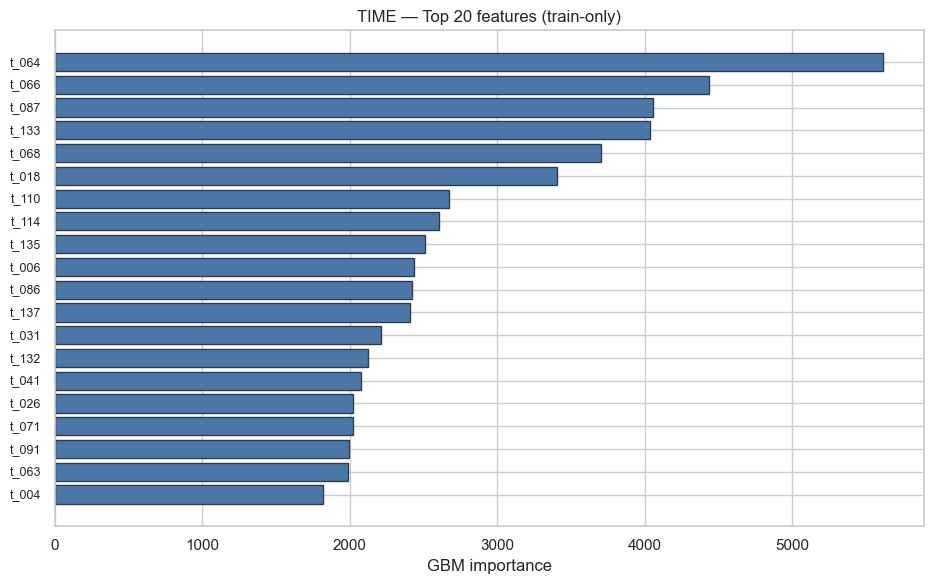

time: selected 3 features.
[ep001] tr_loss=1.2812 tr_acc=0.493 | val_loss=0.9393 val_acc=0.643
[ep002] tr_loss=0.9082 tr_acc=0.629 | val_loss=0.7293 val_acc=0.702
[ep003] tr_loss=0.7824 tr_acc=0.680 | val_loss=0.6738 val_acc=0.726
[ep004] tr_loss=0.7338 tr_acc=0.697 | val_loss=0.6216 val_acc=0.739
[ep005] tr_loss=0.7000 tr_acc=0.713 | val_loss=0.5891 val_acc=0.753
[ep006] tr_loss=0.6696 tr_acc=0.727 | val_loss=0.5682 val_acc=0.781
[ep007] tr_loss=0.6424 tr_acc=0.738 | val_loss=0.5562 val_acc=0.783
[ep008] tr_loss=0.6382 tr_acc=0.738 | val_loss=0.5350 val_acc=0.792
[ep009] tr_loss=0.6170 tr_acc=0.747 | val_loss=0.5279 val_acc=0.790
[ep010] tr_loss=0.5995 tr_acc=0.753 | val_loss=0.5178 val_acc=0.790
[ep011] tr_loss=0.5976 tr_acc=0.757 | val_loss=0.5169 val_acc=0.793
[ep012] tr_loss=0.5874 tr_acc=0.759 | val_loss=0.5058 val_acc=0.793
[ep013] tr_loss=0.5766 tr_acc=0.766 | val_loss=0.4976 val_acc=0.802
[ep014] tr_loss=0.5660 tr_acc=0.768 | val_loss=0.4934 val_acc=0.795
[ep015] tr_loss=0.560

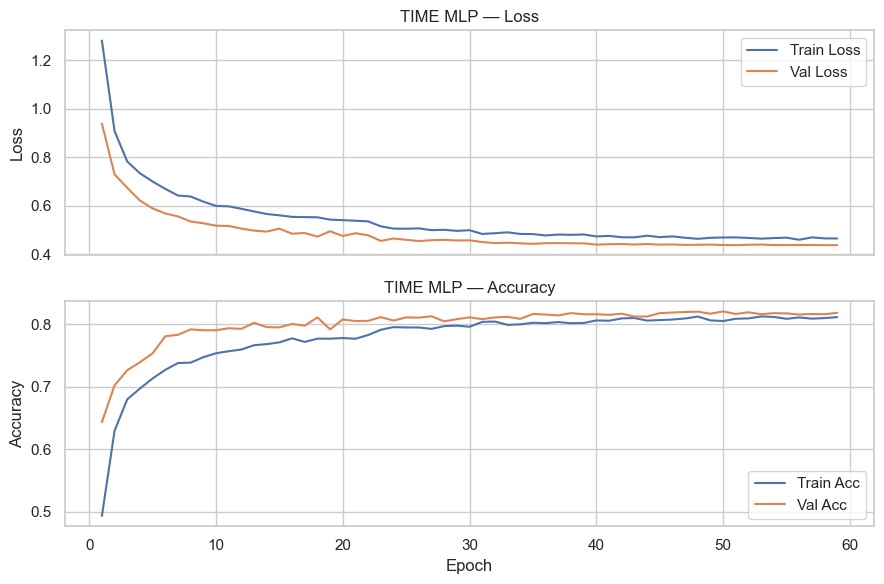

[TIME] TEST acc=0.8250  macro-F1=0.8222


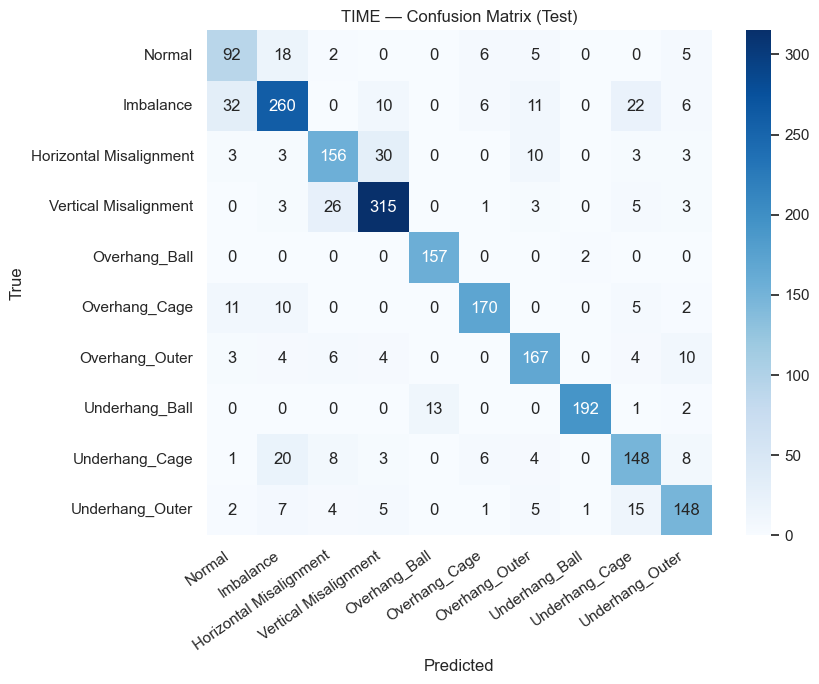


========== [FREQ] 10-class MLP ==========


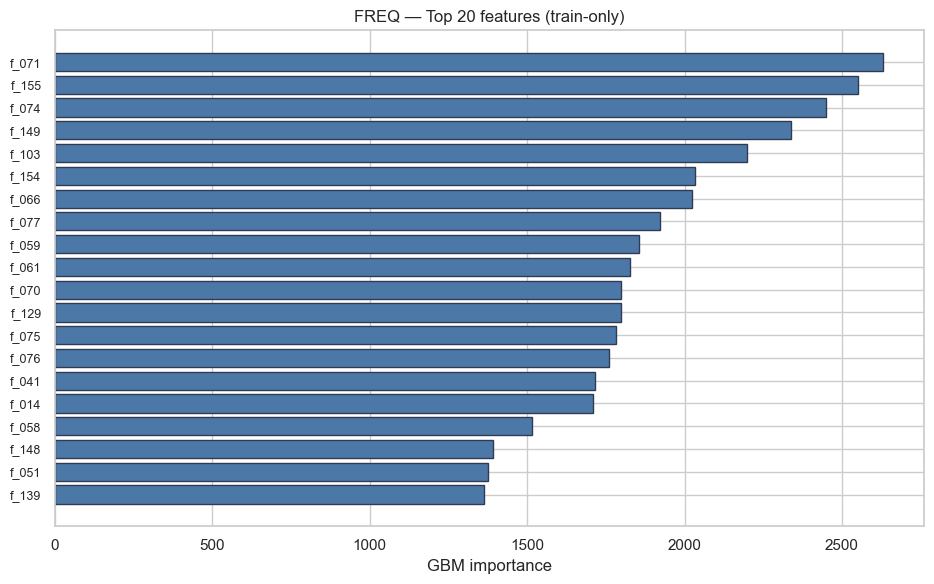

freq: selected 3 features.
[ep001] tr_loss=0.9430 tr_acc=0.652 | val_loss=0.6316 val_acc=0.752
[ep002] tr_loss=0.6616 tr_acc=0.732 | val_loss=0.5491 val_acc=0.778
[ep003] tr_loss=0.5851 tr_acc=0.761 | val_loss=0.4943 val_acc=0.797
[ep004] tr_loss=0.5365 tr_acc=0.781 | val_loss=0.4651 val_acc=0.810
[ep005] tr_loss=0.5162 tr_acc=0.791 | val_loss=0.4285 val_acc=0.828
[ep006] tr_loss=0.4957 tr_acc=0.795 | val_loss=0.4146 val_acc=0.831
[ep007] tr_loss=0.4765 tr_acc=0.804 | val_loss=0.4108 val_acc=0.833
[ep008] tr_loss=0.4632 tr_acc=0.808 | val_loss=0.3893 val_acc=0.844
[ep009] tr_loss=0.4472 tr_acc=0.815 | val_loss=0.3785 val_acc=0.842
[ep010] tr_loss=0.4441 tr_acc=0.815 | val_loss=0.3661 val_acc=0.847
[ep011] tr_loss=0.4360 tr_acc=0.820 | val_loss=0.3719 val_acc=0.855
[ep012] tr_loss=0.4329 tr_acc=0.823 | val_loss=0.3664 val_acc=0.856
[ep013] tr_loss=0.4189 tr_acc=0.829 | val_loss=0.3590 val_acc=0.852
[ep014] tr_loss=0.4087 tr_acc=0.833 | val_loss=0.3591 val_acc=0.851
[ep015] tr_loss=0.412

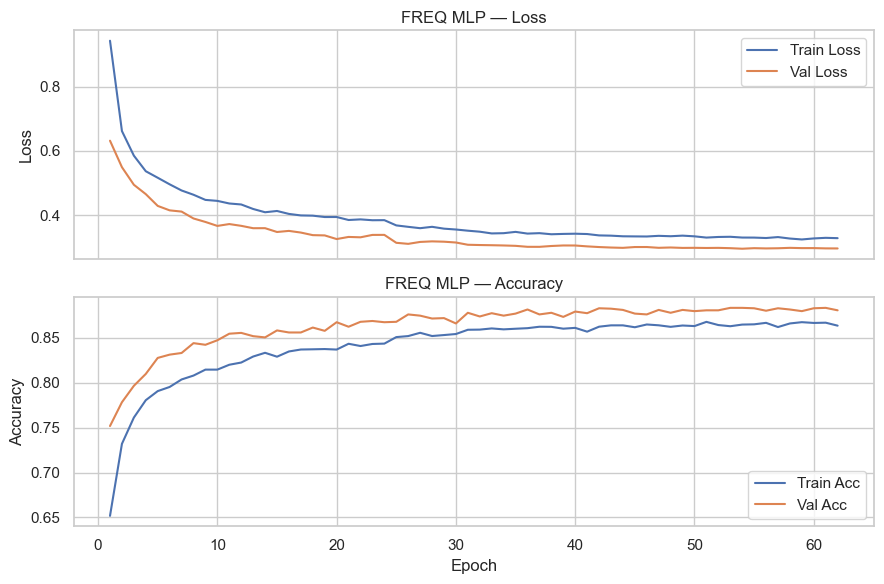

[FREQ] TEST acc=0.8720  macro-F1=0.8569


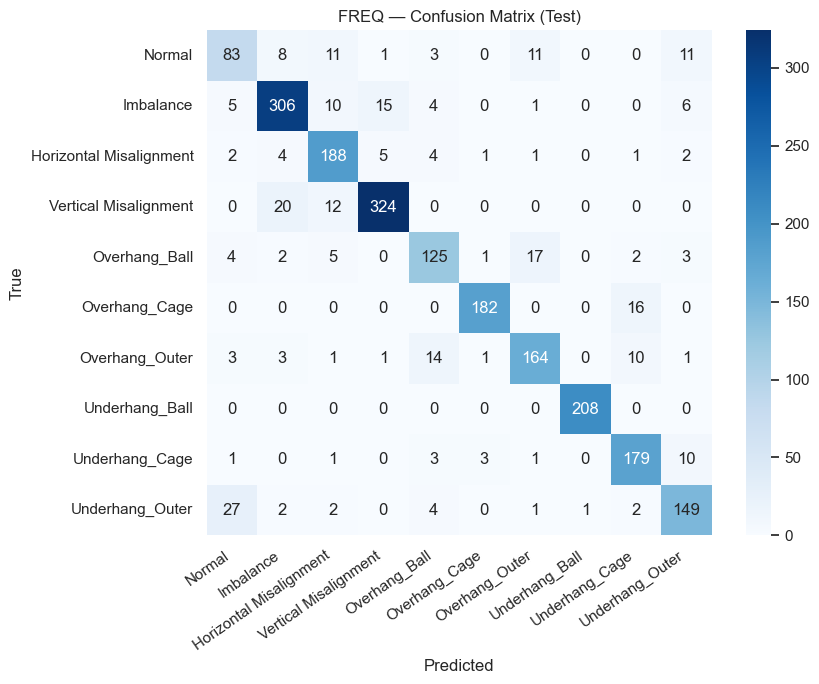


========== [TF] 10-class MLP ==========


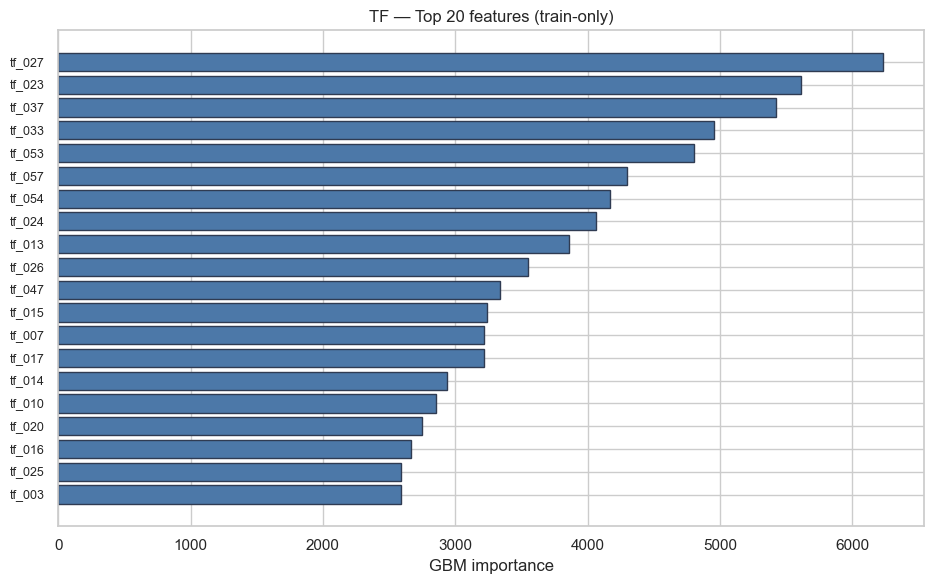

tf: selected 3 features.
[ep001] tr_loss=1.4187 tr_acc=0.445 | val_loss=1.1573 val_acc=0.578
[ep002] tr_loss=1.1887 tr_acc=0.534 | val_loss=1.0500 val_acc=0.617
[ep003] tr_loss=1.0926 tr_acc=0.575 | val_loss=0.9710 val_acc=0.616
[ep004] tr_loss=1.0220 tr_acc=0.598 | val_loss=0.9247 val_acc=0.638
[ep005] tr_loss=0.9663 tr_acc=0.617 | val_loss=0.8778 val_acc=0.663
[ep006] tr_loss=0.9249 tr_acc=0.635 | val_loss=0.8259 val_acc=0.673
[ep007] tr_loss=0.8972 tr_acc=0.647 | val_loss=0.8203 val_acc=0.676
[ep008] tr_loss=0.8738 tr_acc=0.656 | val_loss=0.7849 val_acc=0.694
[ep009] tr_loss=0.8521 tr_acc=0.663 | val_loss=0.7519 val_acc=0.706
[ep010] tr_loss=0.8290 tr_acc=0.676 | val_loss=0.7727 val_acc=0.696
[ep011] tr_loss=0.8175 tr_acc=0.680 | val_loss=0.7308 val_acc=0.704
[ep012] tr_loss=0.8000 tr_acc=0.689 | val_loss=0.7032 val_acc=0.718
[ep013] tr_loss=0.7913 tr_acc=0.692 | val_loss=0.7162 val_acc=0.717
[ep014] tr_loss=0.7792 tr_acc=0.697 | val_loss=0.7099 val_acc=0.719
[ep015] tr_loss=0.7715 

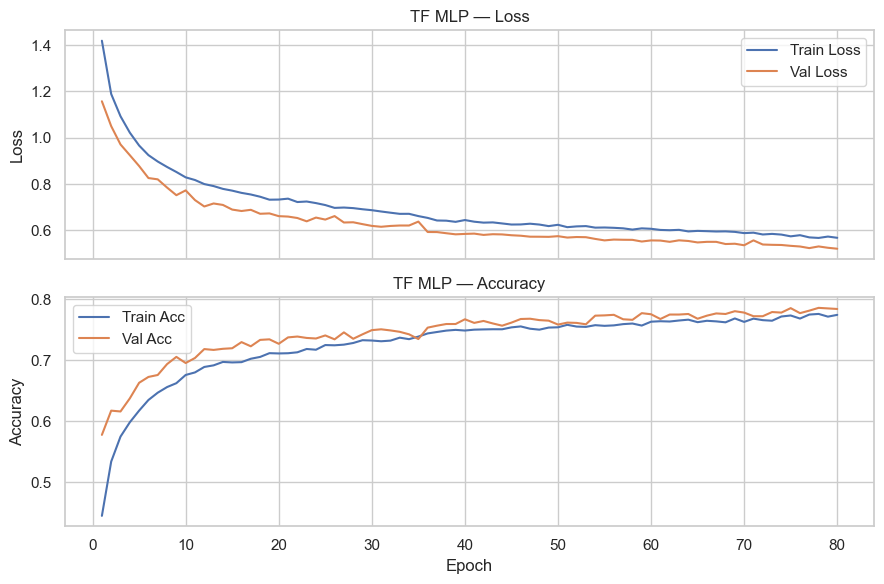

[TF] TEST acc=0.7902  macro-F1=0.7965


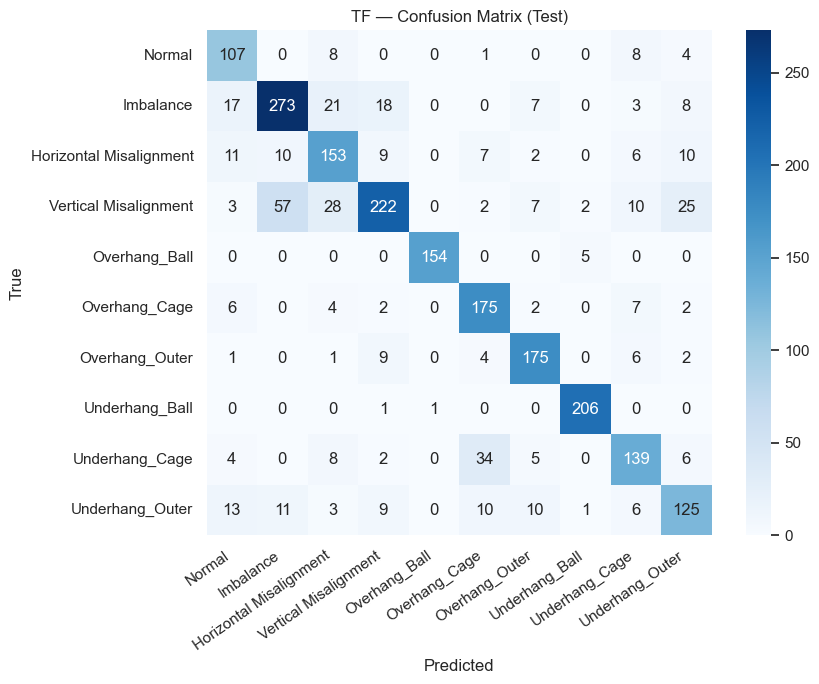


========== Decision-level Fusion (equal weights) ==========
[FUSION/Decision] TEST acc=0.9785  macro-F1=0.9783


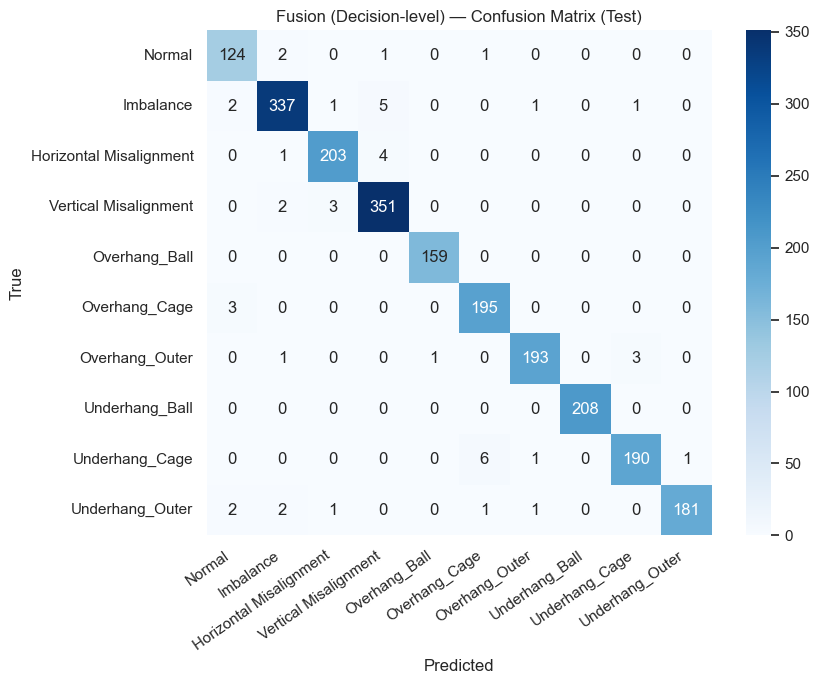


========== Feature-level Fusion (concatenate selected features) ==========


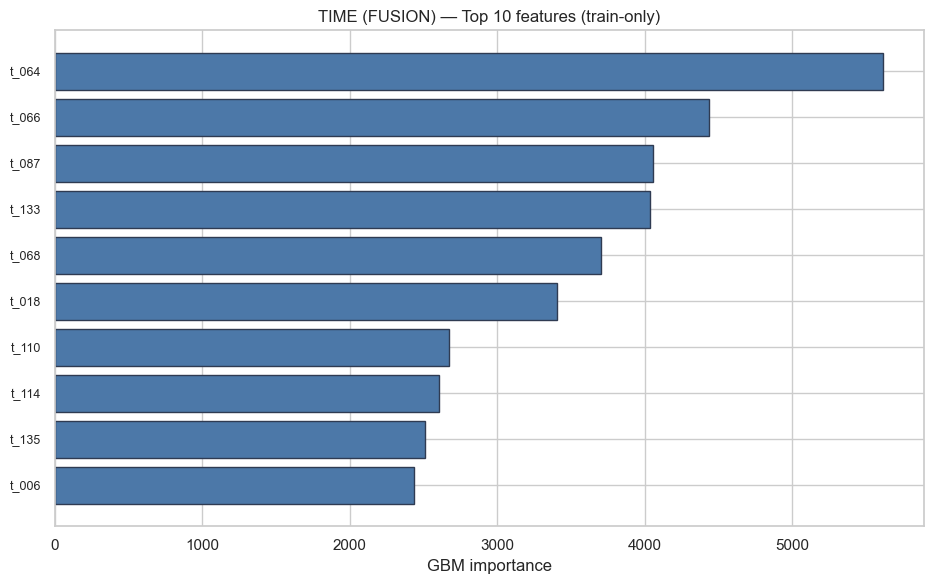

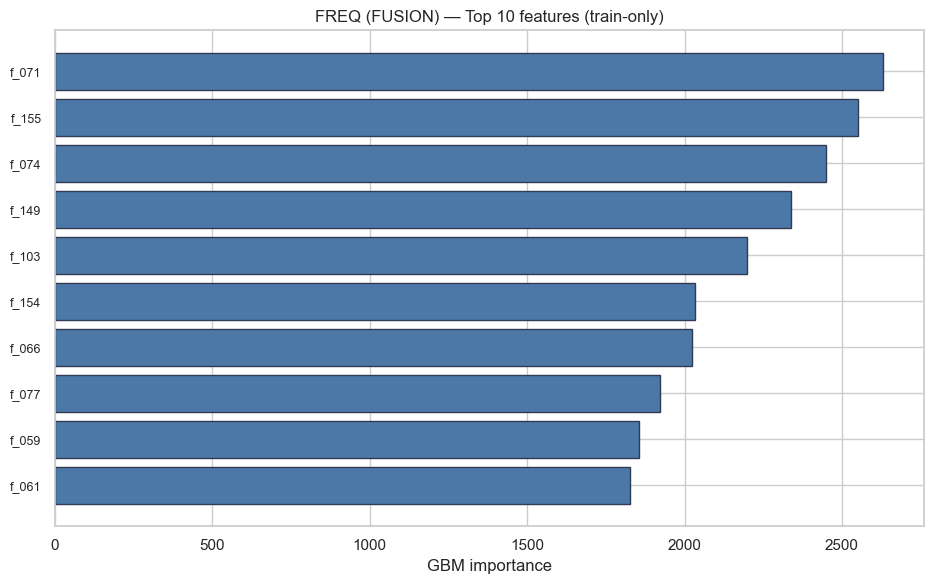

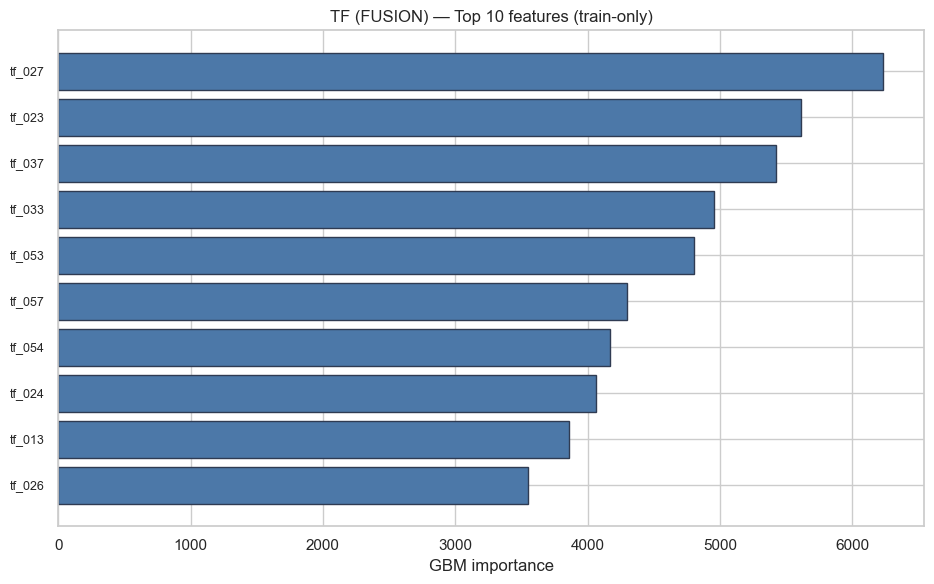

Selected features per view for fusion: {'time': 3, 'freq': 3, 'tf': 3}
[ep001] tr_loss=0.5263 tr_acc=0.816 | val_loss=0.1258 val_acc=0.954
[ep002] tr_loss=0.1225 tr_acc=0.959 | val_loss=0.0556 val_acc=0.984
[ep003] tr_loss=0.0750 tr_acc=0.974 | val_loss=0.0512 val_acc=0.984
[ep004] tr_loss=0.0559 tr_acc=0.981 | val_loss=0.0288 val_acc=0.989
[ep005] tr_loss=0.0469 tr_acc=0.984 | val_loss=0.0265 val_acc=0.990
[ep006] tr_loss=0.0350 tr_acc=0.988 | val_loss=0.0205 val_acc=0.995
[ep007] tr_loss=0.0330 tr_acc=0.989 | val_loss=0.0160 val_acc=0.996
[ep008] tr_loss=0.0273 tr_acc=0.991 | val_loss=0.0107 val_acc=0.998
[ep009] tr_loss=0.0247 tr_acc=0.991 | val_loss=0.0123 val_acc=0.997
[ep010] tr_loss=0.0217 tr_acc=0.993 | val_loss=0.0182 val_acc=0.993
[ep011] tr_loss=0.0210 tr_acc=0.993 | val_loss=0.0132 val_acc=0.996
[ep012] tr_loss=0.0206 tr_acc=0.993 | val_loss=0.0154 val_acc=0.996
[ep013] tr_loss=0.0147 tr_acc=0.995 | val_loss=0.0095 val_acc=0.997
[ep014] tr_loss=0.0125 tr_acc=0.996 | val_los

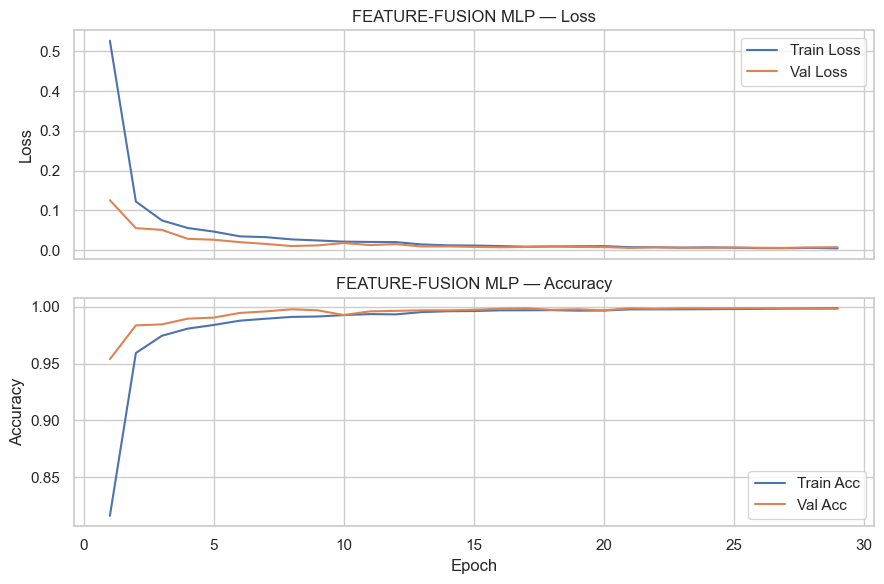

[FUSION/Feature] TEST acc=0.9991  macro-F1=0.9991


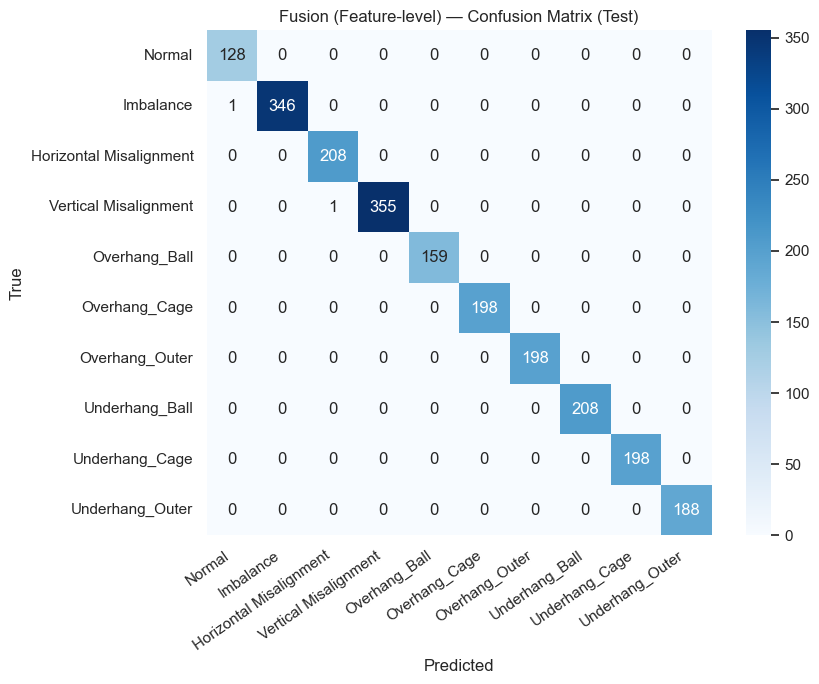

In [6]:
# -*- coding: utf-8 -*-
"""
Per-view MLPs (time / freq / tf) for 10-class classification.
- LightGBM used ONLY for feature selection (train split).
- Shows inline matplotlib figures in console:
    * Top-20 GBM feature importances (per view)
    * Train vs Val loss & accuracy curves (per view)
    * Confusion matrix (per view)
    * Optional decision-level fusion confusion matrix
    * Optional feature-level fusion training & evaluation

Assumes feature CSVs exist in FEATURE_DIR:
  - time_features.csv  (t_*)
  - freq_features.csv  (f_*)
  - tf_features.csv    (tf_*)
"""

import json, random
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from sklearn.preprocessing import StandardScaler

import lightgbm as lgb
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

# =========================
# CONFIG
# =========================
FEATURE_DIR = r"E:\ali\PY Projects\MaFaulDa 1\features"
RANDOM_STATE = 42

# Train which views?
TRAIN_VIEWS = {"time": 1, "freq": 1, "tf": 1}

# Evaluate decision-level fusion of available trained views?
DO_FUSION = 1   # 0/1

# (NEW) Train a feature-level fusion model?
DO_FEATURE_FUSION = 1  # 0/1

# Feature selection Top-K per view for single-view models
TOPK = {"time": 3, "freq": 3, "tf": 3}

# (NEW) Feature selection Top-K per view for FEATURE-LEVEL fusion
TOPK_FUSION = {"time": 3, "freq": 3, "tf": 3}

# Splits
TEST_SIZE = 0.2
VAL_SIZE  = 0.5    # 10% val, 10% test (after temp split)

# Training hyperparams
BATCH    = 128
EPOCHS   = 80
LR       = 12e-4
WD       = 1e-4
PATIENCE = 8
DEVICE   = "cuda" if torch.cuda.is_available() else "cpu"
torch.backends.cudnn.benchmark = True

# Plot style
CMAP = "viridis"
BAR_COLOR = "#4C78A8"
BAR_EDGE  = "#2F3B52"

# =========================
# LABELS (10-way)
# =========================
MEGA_CLASSES = [
    "Normal", "Imbalance", "Horizontal Misalignment", "Vertical Misalignment",
    "Overhang_Ball", "Overhang_Cage", "Overhang_Outer",
    "Underhang_Ball", "Underhang_Cage", "Underhang_Outer"
]
mega2id = {c:i for i,c in enumerate(MEGA_CLASSES)}

def to_mega(super_class: str, subtype: str) -> str:
    if super_class == "Overhang":
        return {"ball_fault":"Overhang_Ball","cage_fault":"Overhang_Cage","outer_race":"Overhang_Outer"}[subtype]
    if super_class == "Underhang":
        return {"ball_fault":"Underhang_Ball","cage_fault":"Underhang_Cage","outer_race":"Underhang_Outer"}[subtype]
    return super_class

# =========================
# Data helpers
# =========================
def load_view_table(feature_dir: Path, view: str):
    csv_name = {"time":"time_features.csv","freq":"freq_features.csv","tf":"tf_features.csv"}[view]
    df = pd.read_csv(feature_dir/csv_name)
    df = df[df["super_class"].notna()].reset_index(drop=True)
    prefix = {"time":"t_","freq":"f_","tf":"tf_"}[view]
    feat_cols = [c for c in df.columns if c.startswith(prefix)]
    X = df[feat_cols].copy()
    meta = df[["filepath","super_class","subtype"]].copy()
    y_mega = meta.apply(lambda r: mega2id[to_mega(r["super_class"], r["subtype"])], axis=1).to_numpy(int)
    return X, y_mega, feat_cols

def split_once(y, test_size=TEST_SIZE, val_size=VAL_SIZE, rs=RANDOM_STATE):
    idx = np.arange(len(y))
    i_tr, i_tmp, y_tr, y_tmp = train_test_split(idx, y, test_size=test_size, random_state=rs, stratify=y)
    i_va, i_te, y_va, y_te = train_test_split(i_tmp, y_tmp, test_size=val_size, random_state=rs, stratify=y_tmp)
    return i_tr, i_va, i_te

# =========================
# GBM Feature selection (train-only) + importance plot
# =========================
def gbm_select_and_plot(Xtr_df: pd.DataFrame, ytr: np.ndarray, k: int, view: str, topn_plot: int = 20):
    gbm = lgb.LGBMClassifier(
        n_estimators=600, learning_rate=0.05, num_leaves=96,
        subsample=0.9, colsample_bytree=0.8,
        random_state=RANDOM_STATE, n_jobs=-1,
        verbose=-1
    )
    gbm.fit(Xtr_df, ytr)
    importances = gbm.feature_importances_
    names = np.array(Xtr_df.columns)
    order = np.argsort(-importances)

    # --- plot Top-N importances (horizontal bar) ---
    topn = min(topn_plot, len(order))
    top_feats = names[order[:topn]]
    top_vals  = importances[order[:topn]]

    fig, ax = plt.subplots(figsize=(9.5, 6))
    ypos = np.arange(topn)
    ax.barh(ypos, top_vals, color=BAR_COLOR, edgecolor=BAR_EDGE)
    ax.set_yticks(ypos); ax.set_yticklabels(top_feats, fontsize=9)
    ax.invert_yaxis()
    ax.set_xlabel("GBM importance")
    ax.set_title(f"{view.upper()} — Top {topn} features (train-only)")
    plt.tight_layout()
    plt.show()

    # return Top-K for training
    k = min(k, len(order))
    return names[order[:k]].tolist()

# =========================
# Torch MLP
# =========================
class MLP(nn.Module):
    def __init__(self, in_dim: int, n_classes: int):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, 512), nn.ReLU(inplace=True), nn.Dropout(0.25),
            nn.Linear(512, 256),    nn.ReLU(inplace=True), nn.Dropout(0.25),
            nn.Linear(256, 128),    nn.ReLU(inplace=True), nn.Dropout(0.15),
            nn.Linear(128, n_classes)
        )
    def forward(self, x): return self.net(x)

def train_mlp(Xtr, ytr, Xva, yva, n_classes):
    """Train with history for plotting. Returns: scaler, best_state, history dict"""
    scaler = StandardScaler()
    Xtr = scaler.fit_transform(Xtr)
    Xva = scaler.transform(Xva)

    ds_tr = TensorDataset(torch.from_numpy(Xtr).float(), torch.from_numpy(ytr).long())
    ds_va = TensorDataset(torch.from_numpy(Xva).float(), torch.from_numpy(yva).long())
    dl_tr = DataLoader(ds_tr, batch_size=BATCH, shuffle=True)
    dl_va = DataLoader(ds_va, batch_size=BATCH*2, shuffle=False)

    model = MLP(Xtr.shape[1], n_classes).to(DEVICE)
    opt = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=WD)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, mode="min", factor=0.5, patience=3)
    crit = nn.CrossEntropyLoss()

    best = {"loss": 1e9, "state": None, "epoch": -1}
    bad = 0
    hist = {"tr_loss": [], "va_loss": [], "tr_acc": [], "va_acc": []}

    for ep in range(1, EPOCHS+1):
        # train
        model.train()
        tr_loss, tr_n, tr_correct = 0.0, 0, 0
        for xb, yb in dl_tr:
            xb, yb = xb.to(DEVICE), yb.to(DEVICE)
            opt.zero_grad(set_to_none=True)
            logits = model(xb)
            loss = crit(logits, yb)
            loss.backward(); opt.step()
            tr_loss += loss.item()*yb.size(0); tr_n += yb.size(0)
            tr_correct += (logits.argmax(1)==yb).sum().item()
        tr_loss /= tr_n; tr_acc = tr_correct / tr_n

        # val
        model.eval()
        va_loss, va_n, va_correct = 0.0, 0, 0
        with torch.no_grad():
            for xb, yb in dl_va:
                xb, yb = xb.to(DEVICE), yb.to(DEVICE)
                logits = model(xb)
                loss = crit(logits, yb)
                va_loss += loss.item()*yb.size(0); va_n += yb.size(0)
                va_correct += (logits.argmax(1)==yb).sum().item()
        va_loss /= va_n; va_acc = va_correct / va_n

        hist["tr_loss"].append(tr_loss); hist["va_loss"].append(va_loss)
        hist["tr_acc"].append(tr_acc);   hist["va_acc"].append(va_acc)
        scheduler.step(va_loss)
        print(f"[ep{ep:03d}] tr_loss={tr_loss:.4f} tr_acc={tr_acc:.3f} | val_loss={va_loss:.4f} val_acc={va_acc:.3f}")

        if va_loss < best["loss"]:
            best = {"loss": va_loss, "epoch": ep, "state": model.state_dict()}
            bad = 0
        else:
            bad += 1
            if bad >= PATIENCE:
                print(f"Early stop at ep{ep}, best ep{best['epoch']} val_loss={best['loss']:.4f}")
                break

    return scaler, best["state"], hist

def plot_curves(hist: dict, title: str):
    epochs = np.arange(1, len(hist["tr_loss"])+1)
    fig, axs = plt.subplots(2, 1, figsize=(9, 6), sharex=True)
    axs[0].plot(epochs, hist["tr_loss"], label="Train Loss")
    axs[0].plot(epochs, hist["va_loss"], label="Val Loss")
    axs[0].set_ylabel("Loss"); axs[0].set_title(title + " — Loss"); axs[0].legend()
    axs[1].plot(epochs, hist["tr_acc"], label="Train Acc")
    axs[1].plot(epochs, hist["va_acc"], label="Val Acc")
    axs[1].set_xlabel("Epoch"); axs[1].set_ylabel("Accuracy"); axs[1].set_title(title + " — Accuracy")
    axs[1].legend()
    plt.tight_layout(); plt.show()

def eval_logits(X, y, scaler, state):
    Xs = scaler.transform(X)
    ds = TensorDataset(torch.from_numpy(Xs).float(), torch.from_numpy(y).long())
    dl = DataLoader(ds, batch_size=BATCH*2, shuffle=False)

    model = MLP(Xs.shape[1], len(MEGA_CLASSES)).to(DEVICE)
    model.load_state_dict(state); model.eval()

    all_logits, all_y = [], []
    with torch.no_grad():
        for xb, yb in dl:
            xb = xb.to(DEVICE)
            logits = model(xb)
            all_logits.append(logits.cpu().numpy())
            all_y.append(yb.numpy())
    logits = np.vstack(all_logits)
    ytrue  = np.concatenate(all_y)
    yhat   = logits.argmax(1)
    acc = accuracy_score(ytrue, yhat)
    f1  = f1_score(ytrue, yhat, average="macro")
    return acc, f1, yhat, logits

def plot_confusion(y_true, y_pred, title: str):
    cm = confusion_matrix(y_true, y_pred, labels=np.arange(len(MEGA_CLASSES)))
    fig, ax = plt.subplots(figsize=(9, 7))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=MEGA_CLASSES, yticklabels=MEGA_CLASSES,
                cbar=True, square=True, ax=ax)
    ax.set_xlabel("Predicted"); ax.set_ylabel("True"); ax.set_title(title)
    plt.xticks(rotation=35, ha="right"); plt.yticks(rotation=0)
    plt.tight_layout(); plt.show()

# =========================
# (NEW) Feature-level Fusion helpers
# =========================
def build_feature_fusion_matrices(data, i_tr, i_va, i_te, topk_map):
    """
    Select Top-K per view (train-only) and return concatenated matrices for fusion.
    Returns: (Xtr_concat, Xva_concat, Xte_concat, selected_info)
             selected_info: dict view -> list of selected column names
    """
    selected = {}
    blocks_tr, blocks_va, blocks_te = [], [], []
    for view in ["time","freq","tf"]:
        if not TRAIN_VIEWS[view]:
            continue
        X = data[view]["X"]; y = data[view]["y"]
        Xtr, Xva, Xte = X.iloc[i_tr], X.iloc[i_va], X.iloc[i_te]
        ytr = y[i_tr]

        # Fit GBM on train of this view and pick Top-K for fusion
        k = topk_map[view]
        cols = gbm_select_and_plot(Xtr, ytr, k=k, view=f"{view} (fusion)", topn_plot=min(20, max(10, k)))
        selected[view] = cols

        # Slice and collect blocks
        blocks_tr.append(Xtr[cols].to_numpy(np.float32))
        blocks_va.append(Xva[cols].to_numpy(np.float32))
        blocks_te.append(Xte[cols].to_numpy(np.float32))

    # Concatenate along feature dimension
    Xtr_concat = np.concatenate(blocks_tr, axis=1)
    Xva_concat = np.concatenate(blocks_va, axis=1)
    Xte_concat = np.concatenate(blocks_te, axis=1)
    return Xtr_concat, Xva_concat, Xte_concat, selected

# =========================
# MAIN
# =========================
def main():
    random.seed(RANDOM_STATE); np.random.seed(RANDOM_STATE)
    feat_dir = Path(FEATURE_DIR)

    # Load all views once to share the same split indices
    data = {}
    for view in ["time","freq","tf"]:
        X, y, cols = load_view_table(feat_dir, view)
        data[view] = {"X":X, "y":y, "cols":cols}
    n = len(data["freq"]["y"])
    assert all(len(data[v]["y"])==n for v in ["time","freq","tf"])

    # Shared stratified split (by mega class)
    i_tr, i_va, i_te = split_once(data["freq"]["y"])
    print("Split sizes:", len(i_tr), len(i_va), len(i_te))

    # ---------- Single-view training (kept as before) ----------
    per_view = {}
    for view in ["time","freq","tf"]:
        if not TRAIN_VIEWS[view]:
            print(f"Skip {view} (toggle off).")
            continue

        print(f"\n========== [{view.upper()}] 10-class MLP ==========")
        X = data[view]["X"]; y = data[view]["y"]
        Xtr, Xva, Xte = X.iloc[i_tr], X.iloc[i_va], X.iloc[i_te]
        ytr, yva, yte = y[i_tr], y[i_va], y[i_te]

        # 1) GBM selection (train-only) + show Top-20
        top_cols = gbm_select_and_plot(Xtr, ytr, k=TOPK[view], view=view, topn_plot=20)
        print(f"{view}: selected {len(top_cols)} features.")

        # 2) Train MLP + show curves
        Xtr_sel = Xtr[top_cols].to_numpy(np.float32)
        Xva_sel = Xva[top_cols].to_numpy(np.float32)
        Xte_sel = Xte[top_cols].to_numpy(np.float32)

        scaler, state, hist = train_mlp(Xtr_sel, ytr, Xva_sel, yva, n_classes=len(MEGA_CLASSES))
        plot_curves(hist, title=f"{view.upper()} MLP")

        # 3) Test + show confusion matrix
        acc, f1, yhat, logits = eval_logits(Xte_sel, yte, scaler, state)
        print(f"[{view.upper()}] TEST acc={acc:.4f}  macro-F1={f1:.4f}")
        plot_confusion(yte, yhat, title=f"{view.upper()} — Confusion Matrix (Test)")

        per_view[view] = {"yte": yte, "logits": logits}

    # ---------- Decision-level Fusion ----------
    if DO_FUSION:
        active = [v for v in ["time","freq","tf"] if v in per_view]
        if len(active) >= 2:
            print("\n========== Decision-level Fusion (equal weights) ==========")
            probs_list = []
            ref_y = None
            for v in active:
                logits = per_view[v]["logits"]
                yte    = per_view[v]["yte"]
                if ref_y is None:
                    ref_y = yte
                else:
                    assert np.all(ref_y == yte), "Mismatched test alignment across views."
                p = np.exp(logits - logits.max(axis=1, keepdims=True))
                p = p / p.sum(axis=1, keepdims=True)
                probs_list.append(p)
            P = np.mean(probs_list, axis=0)  # equal weights
            yhat = P.argmax(1)
            acc = accuracy_score(ref_y, yhat)
            f1  = f1_score(ref_y, yhat, average="macro")
            print(f"[FUSION/Decision] TEST acc={acc:.4f}  macro-F1={f1:.4f}")
            plot_confusion(ref_y, yhat, title="Fusion (Decision-level) — Confusion Matrix (Test)")
        else:
            print("\n[FUSION] Need at least two trained views; skipped.")

    # ---------- (NEW) Feature-level Fusion ----------
    if DO_FEATURE_FUSION:
        print("\n========== Feature-level Fusion (concatenate selected features) ==========")
        # Build concatenated matrices using Top-K per view (train-only selection)
        Xtr_cat, Xva_cat, Xte_cat, selected = build_feature_fusion_matrices(
            data, i_tr, i_va, i_te, topk_map=TOPK_FUSION
        )
        print("Selected features per view for fusion:", {k: len(v) for k,v in selected.items()})
        # Labels (same for all views)
        ytr, yva, yte = data["freq"]["y"][i_tr], data["freq"]["y"][i_va], data["freq"]["y"][i_te]

        # Train a single MLP on concatenated features
        scaler, state, hist = train_mlp(Xtr_cat, ytr, Xva_cat, yva, n_classes=len(MEGA_CLASSES))
        plot_curves(hist, title="FEATURE-FUSION MLP")

        # Evaluate
        acc, f1, yhat, _ = eval_logits(Xte_cat, yte, scaler, state)
        print(f"[FUSION/Feature] TEST acc={acc:.4f}  macro-F1={f1:.4f}")
        plot_confusion(yte, yhat, title="Fusion (Feature-level) — Confusion Matrix (Test)")

if __name__ == "__main__":
    main()


train -> X:(11264, 60)  y:(11264,)
  val -> X:(1408, 60)  y:(1408,)
 test -> X:(1472, 60)  y:(1472,)
[saved] Features & meta saved under: E:\ali\PY Projects\MaFaulDa 1\prepared\mic_only

Feature dimension (mic-only): 60

=== Train LightGBM (mic-only) ===


e:\Program Files\Codes\Spyder\env1\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LGBM] TEST acc=0.5931  macro-F1=0.4704


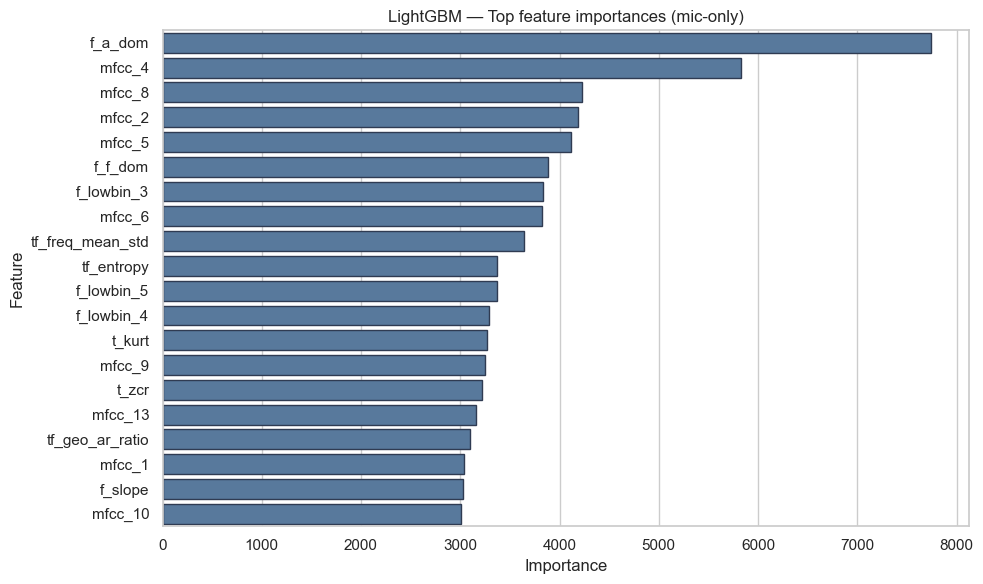

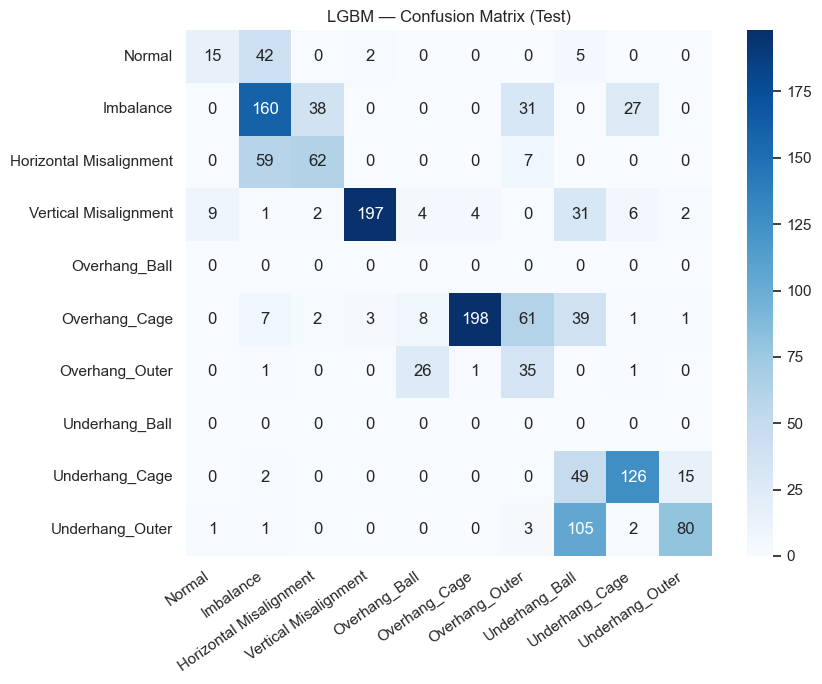


=== Train MLP (mic-only) ===
[MLP ep001] tr_loss=1.4788 tr_acc=0.454 | val_loss=1.3535 val_acc=0.449
[MLP ep002] tr_loss=0.7361 tr_acc=0.735 | val_loss=1.2846 val_acc=0.509
[MLP ep003] tr_loss=0.5000 tr_acc=0.819 | val_loss=1.2539 val_acc=0.549
[MLP ep004] tr_loss=0.3895 tr_acc=0.860 | val_loss=1.3005 val_acc=0.559
[MLP ep005] tr_loss=0.3215 tr_acc=0.882 | val_loss=1.1500 val_acc=0.622
[MLP ep006] tr_loss=0.2762 tr_acc=0.900 | val_loss=1.2765 val_acc=0.586
[MLP ep007] tr_loss=0.2575 tr_acc=0.909 | val_loss=1.1441 val_acc=0.621
[MLP ep008] tr_loss=0.2159 tr_acc=0.924 | val_loss=1.1575 val_acc=0.613
[MLP ep009] tr_loss=0.1952 tr_acc=0.930 | val_loss=1.3125 val_acc=0.607
[MLP ep010] tr_loss=0.1789 tr_acc=0.935 | val_loss=1.3511 val_acc=0.570
[MLP ep011] tr_loss=0.1653 tr_acc=0.939 | val_loss=1.2934 val_acc=0.614
[MLP ep012] tr_loss=0.1424 tr_acc=0.950 | val_loss=1.4332 val_acc=0.598
[MLP ep013] tr_loss=0.1300 tr_acc=0.955 | val_loss=1.6015 val_acc=0.599
[MLP ep014] tr_loss=0.1231 tr_acc=

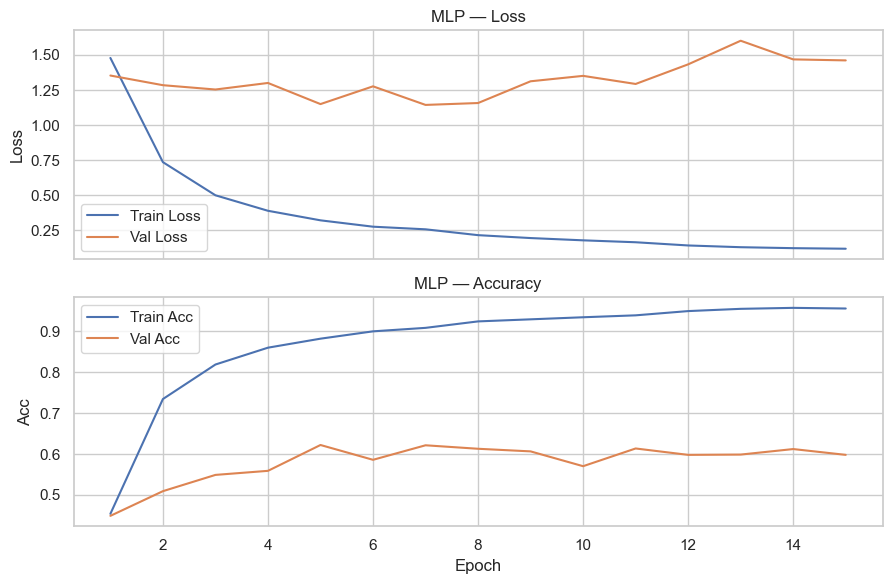

[MLP] TEST acc=0.6549  macro-F1=0.5063


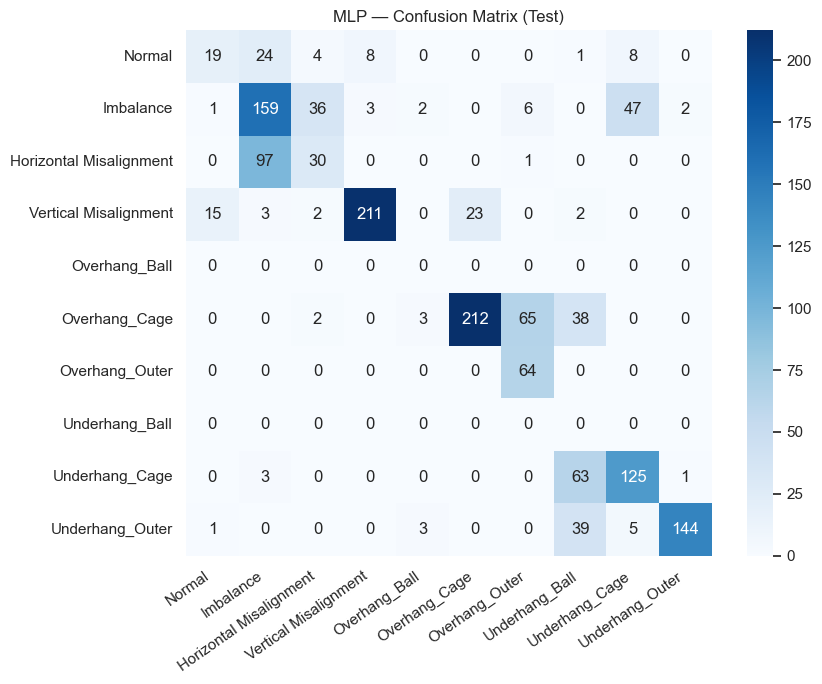

In [7]:
# -*- coding: utf-8 -*-
"""
Acoustic-only (microphone=last column) feature pipeline with saving:
- Read manifest -> per-file paths & labels
- Slice mic column into 5k windows (z-scored per window)
- Extract rich acoustic features (time + freq + TF + optional MFCC)
- SAVE features & labels & per-window metadata for train/val/test
- Train LightGBM (for importances) + MLP baseline
- Show: GBM Top-20 importances + confusion matrices (sns 'Blues')
"""

import os, math, json, warnings, random
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import signal
from scipy.stats import skew, kurtosis, entropy, iqr

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from sklearn.utils import shuffle as sk_shuffle

import lightgbm as lgb
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

# =========================
# CONFIG
# =========================
MANIFEST_CSV = r"E:\ali\PY Projects\MaFaulDa 1\MaFaulDa_subset_manifest.csv"

FS           = 50_000   # Hz (MaFaulDa)
WIN_LEN      = 5000     # samples per window
HOP          = 2500     # 50% overlap
MAX_WINS_PER_FILE = 64  # None = all

RANDOM_STATE = 42

# Save features/labels/meta?
SAVE_FEATURES = True
SAVE_DIR      = r"E:\ali\PY Projects\MaFaulDa 1\prepared\mic_only"

# Train switches
DO_LGBM = True
DO_MLP  = True

# MLP hyperparams
BATCH    = 32
EPOCHS   = 60
LR       = 3e-4
WD       = 1e-4
PATIENCE = 8
DEVICE   = "cuda" if torch.cuda.is_available() else "cpu"
torch.backends.cudnn.benchmark = True

# Plot style
sns.set_theme(style="whitegrid", font_scale=1.0)
CMAP = "Blues"  # seaborn-like

# =========================
# Labels (10 mega classes)
# =========================
MEGA_CLASSES = [
    "Normal", "Imbalance", "Horizontal Misalignment", "Vertical Misalignment",
    "Overhang_Ball", "Overhang_Cage", "Overhang_Outer",
    "Underhang_Ball", "Underhang_Cage", "Underhang_Outer"
]
mega2id = {c:i for i,c in enumerate(MEGA_CLASSES)}

def to_mega(super_class: str, subtype: str) -> str:
    if super_class == "Overhang":
        return {"ball_fault":"Overhang_Ball","cage_fault":"Overhang_Cage","outer_race":"Overhang_Outer"}[subtype]
    if super_class == "Underhang":
        return {"ball_fault":"Underhang_Ball","cage_fault":"Underhang_Cage","outer_race":"Underhang_Outer"}[subtype]
    return super_class

# =========================
# Optional MFCC dependency
# =========================
USE_MFCC = True
try:
    import librosa
except Exception:
    warnings.warn("librosa not found -> MFCC features will be disabled.")
    USE_MFCC = False

# =========================
# Feature helpers (1D mic window)
# =========================
def zscore(x):
    x = np.asarray(x, np.float32).ravel()
    return (x - x.mean()) / (x.std() + 1e-8)

def windows_1d(x, L=WIN_LEN, hop=HOP, limit=MAX_WINS_PER_FILE, return_starts=False):
    n = len(x)
    starts = np.arange(0, max(1, n - L + 1), hop, dtype=int)
    if limit is not None and len(starts) > limit:
        idx = np.linspace(0, len(starts)-1, num=limit, dtype=int)
        starts = starts[idx]
    win_list, start_list = [], []
    for s in starts:
        w = x[s:s+L]
        if len(w) == L:
            win_list.append(zscore(w))
            start_list.append(int(s))
    return (win_list, start_list) if return_starts else win_list

# ----- Time features -----
def time_feats(x):
    x = np.asarray(x, np.float32)
    feats = []
    mu = np.mean(x); sd = np.std(x, ddof=1) if x.size>1 else 0.0
    rms = np.sqrt(np.mean(x**2) + 1e-12)
    mn  = np.min(x); mx = np.max(x)
    p2p = mx - mn
    sk  = float(skew(x, bias=False)) if x.size>2 else 0.0
    ku  = float(kurtosis(x, fisher=False, bias=False)) if x.size>3 else 3.0
    mad = float(np.mean(np.abs(x - mu)))
    iqr_v = float(iqr(x)) if x.size>0 else 0.0
    # factors
    shape = rms / (np.mean(np.abs(x)) + 1e-12)
    crest = (np.max(np.abs(x)) + 1e-12) / (rms + 1e-12)
    impulse = (np.max(np.abs(x)) + 1e-12) / (np.mean(np.abs(x)) + 1e-12)
    margin  = (np.max(np.abs(x)) + 1e-12) / (np.mean(np.sqrt(np.abs(x))+1e-12) + 1e-12)
    # zero-cross & entropy
    zcr = float(np.mean(np.abs(np.diff(np.signbit(x)))))/2.0
    ax = np.abs(x); ax /= (ax.sum() + 1e-12)
    ent = float(-np.sum(ax * np.log(ax + 1e-12)))
    # derivatives & peaks
    dx = np.diff(x); vdx = float(np.var(dx)) if dx.size else 0.0
    idx,_ = signal.find_peaks(x, distance=5)
    n_peaks = int(idx.size)
    mean_peaks = float(np.mean(x[idx])) if idx.size else 0.0
    # Hjorth
    ddx = np.diff(dx)
    var_x  = np.var(x) + 1e-12
    var_dx = np.var(dx) + 1e-12
    var_ddx= np.var(ddx)+ 1e-12
    mobility   = math.sqrt(var_dx/var_x)
    complexity = math.sqrt(var_ddx/var_dx) / (mobility + 1e-12)

    feats += [mu, sd, rms, mn, mx, p2p, sk, ku, mad, iqr_v,
              shape, crest, impulse, margin, zcr, ent, vdx, n_peaks, mean_peaks,
              mobility, complexity]
    return feats

# ----- Frequency features -----
def rfft_mag(x): return np.abs(np.fft.rfft(x)) + 1e-12
def f_axis(nbins, fs=FS): return np.linspace(0, fs/2.0, num=nbins, endpoint=True)

def freq_feats(x):
    P = rfft_mag(x); f = f_axis(len(P), FS)
    feats = []
    # a few low-order bins (shape near DC)
    for i in range(1, 6):
        feats.append(float(P[i]) if i < len(P) else 0.0)
    # dominant
    k = int(np.argmax(P))
    f_dom = float(f[k]); a_dom = float(P[k])
    # moments & shape
    centroid = float((f*P).sum() / (P.sum()+1e-12))
    bandwidth= float(np.sqrt(np.sum(((f-centroid)**2)*P)/(P.sum()+1e-12)))
    roll85   = int(np.searchsorted(np.cumsum(P), 0.85*np.sum(P)))
    flatness = float(np.exp(np.mean(np.log(P))) / (np.mean(P)+1e-12))
    slope    = float(((np.arange(len(P))-len(P)/2.0) * (P - P.mean())).sum() / ((np.arange(len(P))-len(P)/2.0)**2).sum())
    entr     = float(-np.sum((P/P.sum()) * np.log(P/P.sum()+1e-12)))
    # bands
    low  = P[(f>=0)&(f<2000)].sum()
    mid  = P[(f>=2000)&(f<6000)].sum()
    high = P[(f>=6000)].sum()
    tot  = P.sum()+1e-12
    feats += [a_dom, f_dom, centroid, bandwidth, float(roll85), flatness, slope, entr,
              float(low/tot), float(mid/tot), float(high/tot)]
    return feats

# ----- Time-Frequency (spectrogram stats) -----
def tf_feats(x, fs=FS, nperseg=256, noverlap=128):
    f, t, S = signal.spectrogram(x, fs=fs, nperseg=nperseg, noverlap=noverlap,
                                 scaling='spectrum', mode='magnitude')
    P = (S**2).astype(np.float32)
    feats = []
    feats += [float(P.mean()), float(P.std()), float(P.max())]
    mid = P.shape[0]//2
    lowE  = float(P[:mid,:].sum()); highE = float(P[mid:,:].sum()) + 1e-12
    feats += [float(lowE/highE)]
    Pn = P/(P.sum()+1e-12)
    feats += [float(entropy(Pn.ravel()+1e-12))]
    feats += [float(P.sum(axis=0).std()), float(P.mean(axis=1).std())]
    geo = np.exp(np.mean(np.log(P + 1e-12))); ar = np.mean(P + 1e-12)
    feats += [float(geo/ar)]
    y = P.mean(axis=0); xax = np.arange(y.size); xax = xax - xax.mean(); y = y - y.mean()
    feats += [float((xax*y).sum() / ((xax**2).sum()+1e-12))]
    flat = P.ravel(); top3 = np.sort(flat)[-3:] if flat.size>=3 else flat
    feats += [float((top3/(flat.sum()+1e-12)).sum())]
    return feats

# ----- MFCC (optional) -----
def mfcc_feats(x, fs=FS, n_mfcc=13):
    if not USE_MFCC: return []
    M = librosa.feature.mfcc(y=x.astype(np.float32), sr=fs, n_mfcc=n_mfcc, n_mels=32)
    return [float(M.mean(axis=1)[i]) for i in range(n_mfcc)]

def acoustic_feature_vector(x):
    """Concatenate all acoustic features from a z-scored 1D window."""
    feats = []
    feats += time_feats(x)
    feats += freq_feats(x)
    feats += tf_feats(x)
    feats += mfcc_feats(x)   # may be empty if librosa missing
    return np.array(feats, np.float32)

def acoustic_feature_names():
    names = []
    # time
    names += ["t_mean","t_std","t_rms","t_min","t_max","t_p2p","t_skew","t_kurt",
              "t_mad","t_iqr","t_shape","t_crest","t_impulse","t_margin",
              "t_zcr","t_amp_entropy","t_dvar","t_npeaks","t_mean_peaks",
              "t_hjorth_mob","t_hjorth_comp"]
    # freq
    names += [f"f_lowbin_{i}" for i in range(1,6)]
    names += ["f_a_dom","f_f_dom","f_centroid","f_bw","f_roll85","f_flatness","f_slope","f_entropy",
              "f_low_ratio","f_mid_ratio","f_high_ratio"]
    # tf
    names += ["tf_mean","tf_std","tf_max","tf_low_high_ratio","tf_entropy",
              "tf_time_energy_std","tf_freq_mean_std","tf_geo_ar_ratio","tf_time_slope","tf_top3_ratio"]
    # mfcc
    if USE_MFCC:
        names += [f"mfcc_{i+1}" for i in range(13)]
    return names

# =========================
# Data building (+ saving)
# =========================
def build_and_save_dataset(manifest_csv: str, save_dir: Path = None):
    df = pd.read_csv(manifest_csv)
    df = df[df["super_class"].notna()].copy()
    files = df[["filepath","super_class","subtype"]].drop_duplicates()

    # split by FILE (no leakage)
    tr_f, tmp_f = train_test_split(files, test_size=0.2, random_state=RANDOM_STATE,
                                   stratify=files["super_class"])
    va_f, te_f  = train_test_split(tmp_f, test_size=0.5, random_state=RANDOM_STATE,
                                   stratify=tmp_f["super_class"])
    splits = {"train": tr_f.reset_index(drop=True),
              "val":   va_f.reset_index(drop=True),
              "test":  te_f.reset_index(drop=True)}

    feat_names = acoustic_feature_names()
    X_out, y_out, meta_out = {}, {}, {}

    for split, df_split in splits.items():
        Xs, ys, metas = [], [], []
        for _, row in df_split.iterrows():
            try:
                arr = pd.read_csv(row["filepath"], header=None).values
                x = arr[:, -1].astype(np.float32)  # last column = microphone
            except Exception as e:
                print("skip:", row["filepath"], "err:", e)
                continue

            y = mega2id[to_mega(row["super_class"], row["subtype"])]
            wins, starts = windows_1d(x, return_starts=True)
            for w, st in zip(wins, starts):
                Xs.append(acoustic_feature_vector(w))
                ys.append(y)
                metas.append({"filepath": row["filepath"], "start": st, "label": y})

        X_out[split]  = np.array(Xs, np.float32)
        y_out[split]  = np.array(ys, np.int64)
        meta_out[split] = pd.DataFrame(metas, columns=["filepath","start","label"])
        print(f"{split:>5} -> X:{X_out[split].shape}  y:{y_out[split].shape}")

    # ----- SAVE -----
    if save_dir is not None:
        save_dir.mkdir(parents=True, exist_ok=True)
        # npz (all splits in یک فایل)
        np.savez_compressed(
            save_dir / "mic_features_splits.npz",
            feature_names=np.array(feat_names, dtype=object),
            X_train=X_out["train"], y_train=y_out["train"],
            X_val=X_out["val"],     y_val=y_out["val"],
            X_test=X_out["test"],   y_test=y_out["test"]
        )
        # meta CSVs (به ازای هر split)
        for split in ["train","val","test"]:
            meta_out[split].to_csv(save_dir / f"mic_meta_{split}.csv", index=False)
        print(f"[saved] Features & meta saved under: {save_dir}")

    return X_out, y_out, feat_names, meta_out

# =========================
# LightGBM (baseline + importances)
# =========================
def train_eval_lgbm(Xtr, ytr, Xva, yva, Xte, yte, feat_names, top_importances=20):
    gbm = lgb.LGBMClassifier(
        n_estimators=700, learning_rate=0.06, num_leaves=96,
        subsample=0.9, colsample_bytree=0.8,
        random_state=RANDOM_STATE, n_jobs=-1, verbose=-1
    )
    gbm.fit(Xtr, ytr, eval_set=[(Xva, yva)], eval_metric="multi_logloss")
    # Test
    yhat = gbm.predict(Xte)
    acc = accuracy_score(yte, yhat); f1 = f1_score(yte, yhat, average="macro")
    print(f"[LGBM] TEST acc={acc:.4f}  macro-F1={f1:.4f}")

    # Plot Top-N importances
    imp = gbm.feature_importances_
    order = np.argsort(-imp)
    topn = min(top_importances, len(order))
    top_names = [feat_names[i] if i < len(feat_names) else f"f_{i}" for i in order[:topn]]
    plt.figure(figsize=(10,6))
    sns.barplot(x=imp[order[:topn]], y=top_names, color="#4C78A8", edgecolor="#2F3B52")
    plt.title("LightGBM — Top feature importances (mic-only)")
    plt.xlabel("Importance"); plt.ylabel("Feature")
    plt.tight_layout(); plt.show()

    # Confusion matrix
    cm = confusion_matrix(yte, yhat, labels=np.arange(len(MEGA_CLASSES)))
    plt.figure(figsize=(9,7))
    sns.heatmap(cm, annot=True, fmt="d", cmap=CMAP,
                xticklabels=MEGA_CLASSES, yticklabels=MEGA_CLASSES,
                square=True, cbar=True)
    plt.xticks(rotation=35, ha="right"); plt.yticks(rotation=0)
    plt.title("LGBM — Confusion Matrix (Test)")
    plt.tight_layout(); plt.show()

    return gbm

# =========================
# MLP model
# =========================
class MLP(nn.Module):
    def __init__(self, in_dim: int, n_classes: int):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, 512), nn.ReLU(inplace=True), nn.Dropout(0.25),
            nn.Linear(512, 256),    nn.ReLU(inplace=True), nn.Dropout(0.25),
            nn.Linear(256, 128),    nn.ReLU(inplace=True), nn.Dropout(0.15),
            nn.Linear(128, n_classes)
        )
    def forward(self, x): return self.net(x)

def train_eval_mlp(Xtr, ytr, Xva, yva, Xte, yte):
    scaler = StandardScaler()
    Xtr = scaler.fit_transform(Xtr); Xva = scaler.transform(Xva); Xte_s = scaler.transform(Xte)

    ds_tr = TensorDataset(torch.from_numpy(Xtr).float(), torch.from_numpy(ytr).long())
    ds_va = TensorDataset(torch.from_numpy(Xva).float(), torch.from_numpy(yva).long())
    dl_tr = DataLoader(ds_tr, batch_size=BATCH, shuffle=True)
    dl_va = DataLoader(ds_va, batch_size=BATCH*2, shuffle=False)

    model = MLP(Xtr.shape[1], len(MEGA_CLASSES)).to(DEVICE)
    opt = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=WD)
    sched = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, mode="min", factor=0.5, patience=3)
    crit = nn.CrossEntropyLoss()

    best = {"loss": 1e9, "state": None, "epoch": -1}
    bad = 0
    hist = {"tr_loss":[], "va_loss":[], "tr_acc":[], "va_acc":[]}

    for ep in range(1, EPOCHS+1):
        model.train()
        tr_loss=tr_n=tr_corr=0
        for xb, yb in dl_tr:
            xb, yb = xb.to(DEVICE), yb.to(DEVICE)
            opt.zero_grad(set_to_none=True)
            logits = model(xb)
            loss = crit(logits, yb)
            loss.backward(); opt.step()
            tr_loss += loss.item()*yb.size(0); tr_n += yb.size(0)
            tr_corr += (logits.argmax(1)==yb).sum().item()
        tr_loss /= tr_n; tr_acc = tr_corr/tr_n

        model.eval()
        va_loss=va_n=va_corr=0
        with torch.no_grad():
            for xb, yb in dl_va:
                xb, yb = xb.to(DEVICE), yb.to(DEVICE)
                logits = model(xb); loss = crit(logits, yb)
                va_loss += loss.item()*yb.size(0); va_n += yb.size(0)
                va_corr += (logits.argmax(1)==yb).sum().item()
        va_loss /= va_n; va_acc = va_corr/va_n
        hist["tr_loss"].append(tr_loss); hist["va_loss"].append(va_loss)
        hist["tr_acc"].append(tr_acc);   hist["va_acc"].append(va_acc)
        sched.step(va_loss)
        print(f"[MLP ep{ep:03d}] tr_loss={tr_loss:.4f} tr_acc={tr_acc:.3f} | val_loss={va_loss:.4f} val_acc={va_acc:.3f}")

        if va_loss < best["loss"]:
            best = {"loss": va_loss, "epoch": ep, "state": model.state_dict()}
            bad = 0
        else:
            bad += 1
            if bad >= PATIENCE:
                print(f"Early stop at ep{ep}, best ep{best['epoch']} val_loss={best['loss']:.4f}")
                break

    # curves
    epochs = np.arange(1, len(hist["tr_loss"])+1)
    fig, axs = plt.subplots(2,1, figsize=(9,6), sharex=True)
    axs[0].plot(epochs, hist["tr_loss"], label="Train Loss")
    axs[0].plot(epochs, hist["va_loss"], label="Val Loss")
    axs[0].set_title("MLP — Loss"); axs[0].set_ylabel("Loss"); axs[0].legend()
    axs[1].plot(epochs, hist["tr_acc"], label="Train Acc")
    axs[1].plot(epochs, hist["va_acc"], label="Val Acc")
    axs[1].set_title("MLP — Accuracy"); axs[1].set_xlabel("Epoch"); axs[1].set_ylabel("Acc"); axs[1].legend()
    plt.tight_layout(); plt.show()

    # test
    model.load_state_dict(best["state"]); model.eval()
    with torch.no_grad():
        logits = model(torch.from_numpy(Xte_s).float().to(DEVICE)).cpu().numpy()
    yhat = logits.argmax(1)
    acc = accuracy_score(yte, yhat); f1 = f1_score(yte, yhat, average="macro")
    print(f"[MLP] TEST acc={acc:.4f}  macro-F1={f1:.4f}")

    cm = confusion_matrix(yte, yhat, labels=np.arange(len(MEGA_CLASSES)))
    plt.figure(figsize=(9,7))
    sns.heatmap(cm, annot=True, fmt="d", cmap=CMAP,
                xticklabels=MEGA_CLASSES, yticklabels=MEGA_CLASSES,
                square=True, cbar=True)
    plt.xticks(rotation=35, ha="right"); plt.yticks(rotation=0)
    plt.title("MLP — Confusion Matrix (Test)")
    plt.tight_layout(); plt.show()

    return model, scaler

# =========================
# MAIN
# =========================
def main():
    random.seed(RANDOM_STATE); np.random.seed(RANDOM_STATE)

    save_dir = Path(SAVE_DIR) if SAVE_FEATURES else None
    X_splits, y_splits, feat_names, meta_splits = build_and_save_dataset(MANIFEST_CSV, save_dir)

    # Shuffle within split (اختیاری)
    for k in X_splits.keys():
        X_splits[k], y_splits[k] = sk_shuffle(X_splits[k], y_splits[k], random_state=RANDOM_STATE)

    # Train/Val/Test arrays
    Xtr, ytr = X_splits["train"], y_splits["train"]
    Xva, yva = X_splits["val"],   y_splits["val"]
    Xte, yte = X_splits["test"],  y_splits["test"]

    print("\nFeature dimension (mic-only):", Xtr.shape[1])

    if DO_LGBM:
        print("\n=== Train LightGBM (mic-only) ===")
        _ = train_eval_lgbm(Xtr, ytr, Xva, yva, Xte, yte, feat_names, top_importances=20)

    if DO_MLP:
        print("\n=== Train MLP (mic-only) ===")
        _ = train_eval_mlp(Xtr, ytr, Xva, yva, Xte, yte)

if __name__ == "__main__":
    main()


train -> X:(5632, 60)  y:(5632,)
  val -> X:(704, 60)  y:(704,)
 test -> X:(736, 60)  y:(736,)

Feature dimension: 60


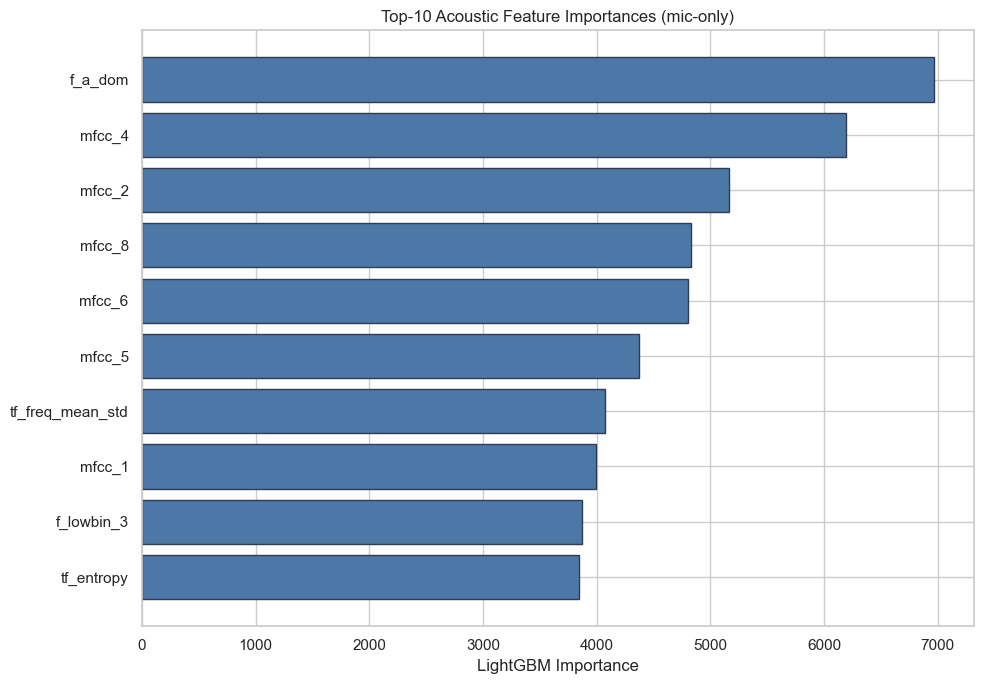


Top feature ranking:
 1. f_a_dom               imp=6971
 2. mfcc_4                imp=6191
 3. mfcc_2                imp=5163
 4. mfcc_8                imp=4831
 5. mfcc_6                imp=4807
 6. mfcc_5                imp=4370
 7. tf_freq_mean_std      imp=4071
 8. mfcc_1                imp=3993
 9. f_lowbin_3            imp=3873
10. tf_entropy            imp=3842


e:\Program Files\Codes\Spyder\env1\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
e:\Program Files\Codes\Spyder\env1\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[GBM sanity] train_acc=1.000  val_acc=0.423

Sample window for visualization:
  file: E:\ali\PY Projects\MaFaulDa Dataset Full 12GB\overhang\ball_fault\35g\25.6.csv
  start: 22500
  true class: Overhang_Ball


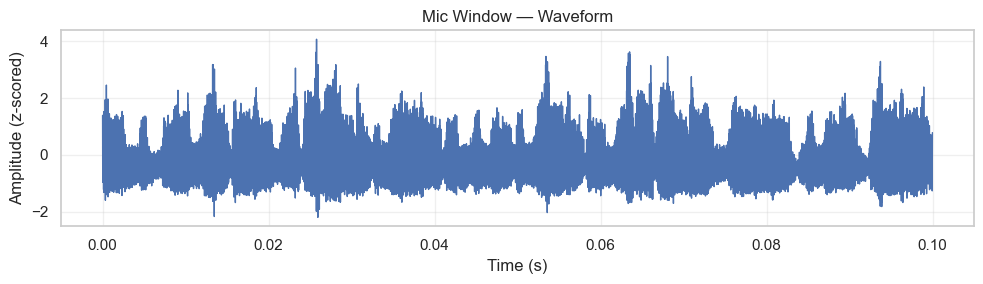

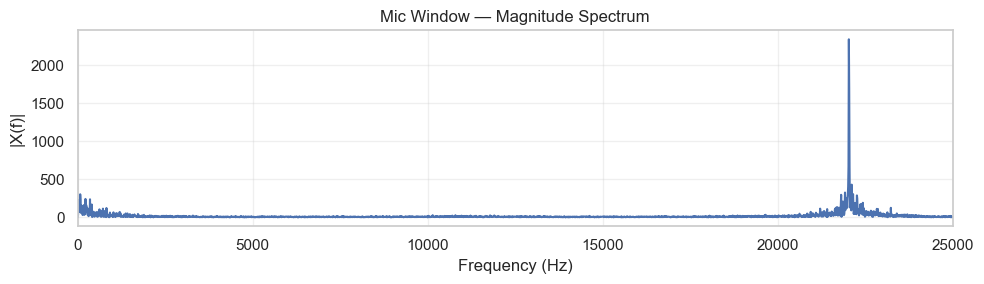

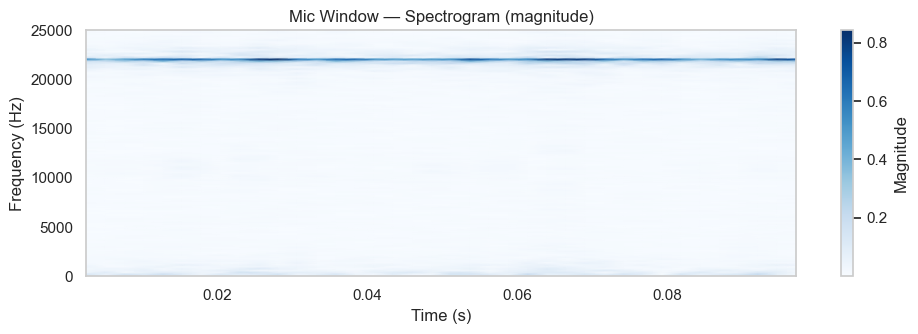

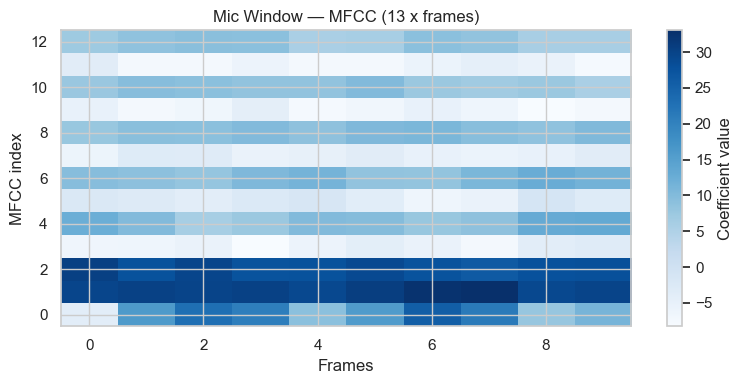

In [8]:
# -*- coding: utf-8 -*-
"""
Acoustic feature ranking + sample visualizations (mic = last column):
- Build mic windows (5k samples, 50% overlap) from manifest
- Extract acoustic features (time, freq, TF, optional MFCC)
- Rank features with LightGBM (train split only) and plot Top-N
- Show a single random window's:
    * waveform
    * magnitude spectrum
    * spectrogram
    * MFCC heatmap (if librosa is installed)
"""

import os, math, json, warnings, random
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import signal
from scipy.stats import skew, kurtosis, entropy, iqr
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.utils import shuffle as sk_shuffle
import lightgbm as lgb

# =========================
# CONFIG
# =========================
MANIFEST_CSV = r"E:\ali\PY Projects\MaFaulDa 1\MaFaulDa_subset_manifest.csv"

FS           = 50_000     # MaFaulDa sampling rate (Hz)
WIN_LEN      = 5000       # window length (samples)
HOP          = 2500       # hop (samples, 50% overlap)
MAX_WINS_PER_FILE = 32    # limit per file to keep things light (None = all)
RANDOM_STATE = 42

TOP_IMPORTANCES = 10     # how many features to display in ranking barplot

sns.set_theme(style="whitegrid", font_scale=1.0)
CMAP = "Blues"

# =========================
# Label space (10 mega-classes)
# =========================
MEGA_CLASSES = [
    "Normal", "Imbalance", "Horizontal Misalignment", "Vertical Misalignment",
    "Overhang_Ball", "Overhang_Cage", "Overhang_Outer",
    "Underhang_Ball", "Underhang_Cage", "Underhang_Outer"
]
mega2id = {c:i for i,c in enumerate(MEGA_CLASSES)}

def to_mega(super_class: str, subtype: str) -> str:
    if super_class == "Overhang":
        return {"ball_fault":"Overhang_Ball","cage_fault":"Overhang_Cage","outer_race":"Overhang_Outer"}[subtype]
    if super_class == "Underhang":
        return {"ball_fault":"Underhang_Ball","cage_fault":"Underhang_Cage","outer_race":"Underhang_Outer"}[subtype]
    return super_class

# =========================
# Optional MFCC dependency
# =========================
USE_MFCC = True
try:
    import librosa
except Exception:
    warnings.warn("librosa not found -> MFCC features will be disabled.")
    USE_MFCC = False

# =========================
# Windowing / Normalization
# =========================
def zscore(x):
    x = np.asarray(x, np.float32).ravel()
    return (x - x.mean()) / (x.std() + 1e-8)

def windows_1d(x, L=WIN_LEN, hop=HOP, limit=MAX_WINS_PER_FILE, return_starts=False):
    n = len(x)
    starts = np.arange(0, max(1, n - L + 1), hop, dtype=int)
    if limit is not None and len(starts) > limit:
        idx = np.linspace(0, len(starts)-1, num=limit, dtype=int)
        starts = starts[idx]
    out, st_list = [], []
    for s in starts:
        w = x[s:s+L]
        if len(w) == L:
            out.append(zscore(w))
            st_list.append(int(s))
    return (out, st_list) if return_starts else out

# =========================
# Feature definitions (1D window)
# =========================
def time_feats(x):
    x = np.asarray(x, np.float32)
    feats = []
    mu = np.mean(x); sd = np.std(x, ddof=1) if x.size>1 else 0.0
    rms = np.sqrt(np.mean(x**2) + 1e-12)
    mn  = np.min(x); mx = np.max(x)
    p2p = mx - mn
    sk  = float(skew(x, bias=False)) if x.size>2 else 0.0
    ku  = float(kurtosis(x, fisher=False, bias=False)) if x.size>3 else 3.0
    mad = float(np.mean(np.abs(x - mu)))
    iqr_v = float(iqr(x)) if x.size>0 else 0.0
    # factors
    shape = rms / (np.mean(np.abs(x)) + 1e-12)
    crest = (np.max(np.abs(x)) + 1e-12) / (rms + 1e-12)
    impulse = (np.max(np.abs(x)) + 1e-12) / (np.mean(np.abs(x)) + 1e-12)
    margin  = (np.max(np.abs(x)) + 1e-12) / (np.mean(np.sqrt(np.abs(x))+1e-12) + 1e-12)
    # zero-cross & amplitude entropy
    zcr = float(np.mean(np.abs(np.diff(np.signbit(x)))))/2.0
    ax = np.abs(x); ax /= (ax.sum() + 1e-12)
    ent = float(-np.sum(ax * np.log(ax + 1e-12)))
    # derivative stats & peaks
    dx = np.diff(x); vdx = float(np.var(dx)) if dx.size else 0.0
    idx,_ = signal.find_peaks(x, distance=5)
    n_peaks = int(idx.size)
    mean_peaks = float(np.mean(x[idx])) if idx.size else 0.0
    # Hjorth
    ddx = np.diff(dx)
    var_x  = np.var(x) + 1e-12
    var_dx = np.var(dx) + 1e-12
    var_ddx= np.var(ddx)+ 1e-12
    mobility   = math.sqrt(var_dx/var_x)
    complexity = math.sqrt(var_ddx/var_dx) / (mobility + 1e-12)
    feats += [mu, sd, rms, mn, mx, p2p, sk, ku, mad, iqr_v,
              shape, crest, impulse, margin, zcr, ent, vdx, n_peaks, mean_peaks,
              mobility, complexity]
    return feats

def rfft_mag(x): return np.abs(np.fft.rfft(x)) + 1e-12
def f_axis(nbins, fs=FS): return np.linspace(0, fs/2.0, num=nbins, endpoint=True)

def freq_feats(x):
    P = rfft_mag(x); f = f_axis(len(P), FS)
    feats = []
    # low-order bins (near DC shape)
    for i in range(1, 6):
        feats.append(float(P[i]) if i < len(P) else 0.0)
    # dominant peak
    k = int(np.argmax(P))
    f_dom = float(f[k]); a_dom = float(P[k])
    # moments & shape
    centroid = float((f*P).sum() / (P.sum()+1e-12))
    bandwidth= float(np.sqrt(np.sum(((f-centroid)**2)*P)/(P.sum()+1e-12)))
    roll85   = int(np.searchsorted(np.cumsum(P), 0.85*np.sum(P)))
    flatness = float(np.exp(np.mean(np.log(P))) / (np.mean(P)+1e-12))
    slope    = float(((np.arange(len(P))-len(P)/2.0) * (P - P.mean())).sum() /
                     ((np.arange(len(P))-len(P)/2.0)**2).sum())
    entr     = float(-np.sum((P/P.sum()) * np.log(P/P.sum()+1e-12)))
    # bands
    low  = P[(f>=0)&(f<2000)].sum()
    mid  = P[(f>=2000)&(f<6000)].sum()
    high = P[(f>=6000)].sum()
    tot  = P.sum()+1e-12
    feats += [a_dom, f_dom, centroid, bandwidth, float(roll85), flatness, slope, entr,
              float(low/tot), float(mid/tot), float(high/tot)]
    return feats

def tf_feats(x, fs=FS, nperseg=256, noverlap=128):
    f, t, S = signal.spectrogram(x, fs=fs, nperseg=nperseg, noverlap=noverlap,
                                 scaling='spectrum', mode='magnitude')
    P = (S**2).astype(np.float32)
    feats = []
    feats += [float(P.mean()), float(P.std()), float(P.max())]
    mid = P.shape[0]//2
    lowE  = float(P[:mid,:].sum()); highE = float(P[mid:,:].sum()) + 1e-12
    feats += [float(lowE/highE)]
    Pn = P/(P.sum()+1e-12)
    feats += [float(entropy(Pn.ravel()+1e-12))]
    feats += [float(P.sum(axis=0).std()), float(P.mean(axis=1).std())]
    geo = np.exp(np.mean(np.log(P + 1e-12))); ar = np.mean(P + 1e-12)
    feats += [float(geo/ar)]
    y = P.mean(axis=0); xax = np.arange(y.size); xax = xax - xax.mean(); y = y - y.mean()
    feats += [float((xax*y).sum() / ((xax**2).sum()+1e-12))]
    flat = P.ravel(); top3 = np.sort(flat)[-3:] if flat.size>=3 else flat
    feats += [float((top3/(flat.sum()+1e-12)).sum())]
    return feats

def mfcc_feats(x, fs=FS, n_mfcc=13):
    if not USE_MFCC: return []
    M = librosa.feature.mfcc(y=x.astype(np.float32), sr=fs, n_mfcc=n_mfcc, n_mels=32)
    return [float(M.mean(axis=1)[i]) for i in range(n_mfcc)]

def acoustic_feature_vector(x):
    feats = []
    feats += time_feats(x)
    feats += freq_feats(x)
    feats += tf_feats(x)
    feats += mfcc_feats(x)   # may be empty if librosa missing
    return np.array(feats, np.float32)

def acoustic_feature_names():
    names = []
    # time
    names += ["t_mean","t_std","t_rms","t_min","t_max","t_p2p","t_skew","t_kurt",
              "t_mad","t_iqr","t_shape","t_crest","t_impulse","t_margin",
              "t_zcr","t_amp_entropy","t_dvar","t_npeaks","t_mean_peaks",
              "t_hjorth_mob","t_hjorth_comp"]
    # freq
    names += [f"f_lowbin_{i}" for i in range(1,6)]
    names += ["f_a_dom","f_f_dom","f_centroid","f_bw","f_roll85","f_flatness","f_slope","f_entropy",
              "f_low_ratio","f_mid_ratio","f_high_ratio"]
    # tf
    names += ["tf_mean","tf_std","tf_max","tf_low_high_ratio","tf_entropy",
              "tf_time_energy_std","tf_freq_mean_std","tf_geo_ar_ratio","tf_time_slope","tf_top3_ratio"]
    # mfcc
    if USE_MFCC:
        names += [f"mfcc_{i+1}" for i in range(13)]
    return names

# =========================
# Dataset build (mic only)
# =========================
def build_dataset(manifest_csv: str):
    df = pd.read_csv(manifest_csv)
    df = df[df["super_class"].notna()].copy()
    files = df[["filepath","super_class","subtype"]].drop_duplicates()

    # split by file (avoid leakage)
    tr_f, tmp_f = train_test_split(files, test_size=0.2, random_state=RANDOM_STATE,
                                   stratify=files["super_class"])
    va_f, te_f  = train_test_split(tmp_f, test_size=0.5, random_state=RANDOM_STATE,
                                   stratify=tmp_f["super_class"])
    splits = {"train":tr_f, "val":va_f, "test":te_f}

    feat_names = acoustic_feature_names()
    X_out, y_out = {}, {}
    # also collect a few raw windows for plotting (from val)
    plot_pool = []

    for split, df_split in splits.items():
        Xs, ys = [], []
        for _, row in df_split.iterrows():
            try:
                arr = pd.read_csv(row["filepath"], header=None).values
                x = arr[:, -1].astype(np.float32)  # microphone = last column
            except Exception as e:
                print("skip:", row["filepath"], "err:", e)
                continue
            y = mega2id[to_mega(row["super_class"], row["subtype"])]
            wins, starts = windows_1d(x, return_starts=True)
            for w, st in zip(wins, starts):
                Xs.append(acoustic_feature_vector(w))
                ys.append(y)
                if split == "val" and len(plot_pool) < 200:  # keep a small pool for random visualization
                    plot_pool.append((w, row["filepath"], st, y))

        X_out[split] = np.array(Xs, np.float32)
        y_out[split] = np.array(ys, np.int64)
        print(f"{split:>5} -> X:{X_out[split].shape}  y:{y_out[split].shape}")

    return X_out, y_out, feat_names, plot_pool

# =========================
# Feature ranking (LightGBM on train)
# =========================
def rank_features_gbm(Xtr, ytr, feat_names, topn=TOP_IMPORTANCES):
    gbm = lgb.LGBMClassifier(
        n_estimators=600, learning_rate=0.05, num_leaves=96,
        subsample=0.9, colsample_bytree=0.8,
        random_state=RANDOM_STATE, n_jobs=-1, verbose=-1
    )
    gbm.fit(Xtr, ytr)
    imp = gbm.feature_importances_
    order = np.argsort(-imp)
    topn = min(topn, len(order))

    names = np.array(feat_names)
    top_names = names[order[:topn]]
    top_vals  = imp[order[:topn]]

    # Plot barh
    fig, ax = plt.subplots(figsize=(10, 7))
    ypos = np.arange(topn)
    ax.barh(ypos, top_vals, color="#4C78A8", edgecolor="#2F3B52")
    ax.set_yticks(ypos)
    ax.set_yticklabels(top_names)
    ax.invert_yaxis()
    ax.set_xlabel("LightGBM Importance")
    ax.set_title(f"Top-{topn} Acoustic Feature Importances (mic-only)")
    plt.tight_layout()
    plt.show()

    # Print ranked list (top 25)
    print("\nTop feature ranking:")
    for i, (n, v) in enumerate(zip(top_names, top_vals), 1):
        print(f"{i:2d}. {n:20s}  imp={v}")

    return gbm, order, imp

# =========================
# Sample visualizations for ONE random window
# =========================
def show_sample_views(window, fs=FS):
    x = window.astype(np.float32)

    # 1) Waveform
    t = np.arange(len(x))/fs
    fig, ax = plt.subplots(figsize=(10,3))
    ax.plot(t, x, linewidth=1.0)
    ax.set_title("Mic Window — Waveform")
    ax.set_xlabel("Time (s)")
    ax.set_ylabel("Amplitude (z-scored)")
    ax.grid(True, alpha=0.3)
    plt.tight_layout(); plt.show()

    # 2) Magnitude Spectrum
    X = np.abs(np.fft.rfft(x))
    f = np.fft.rfftfreq(len(x), d=1.0/fs)
    fig, ax = plt.subplots(figsize=(10,3))
    ax.plot(f, X)
    ax.set_xlim(0, fs/2)
    ax.set_title("Mic Window — Magnitude Spectrum")
    ax.set_xlabel("Frequency (Hz)")
    ax.set_ylabel("|X(f)|")
    ax.grid(True, alpha=0.3)
    plt.tight_layout(); plt.show()

    # 3) Spectrogram
    f_sp, t_sp, S = signal.spectrogram(x, fs=fs, nperseg=256, noverlap=128, scaling='spectrum', mode='magnitude')
    fig, ax = plt.subplots(figsize=(10,3.5))
    pcm = ax.pcolormesh(t_sp, f_sp, S, shading='gouraud', cmap=CMAP)
    ax.set_title("Mic Window — Spectrogram (magnitude)")
    ax.set_xlabel("Time (s)")
    ax.set_ylabel("Frequency (Hz)")
    fig.colorbar(pcm, ax=ax, label="Magnitude")
    plt.tight_layout(); plt.show()

    # 4) MFCC heatmap (if librosa available)
    if USE_MFCC:
        M = librosa.feature.mfcc(y=x, sr=fs, n_mfcc=13, n_mels=32)
        fig, ax = plt.subplots(figsize=(8,4))
        im = ax.imshow(M, aspect="auto", origin="lower", cmap=CMAP)
        ax.set_title("Mic Window — MFCC (13 x frames)")
        ax.set_xlabel("Frames")
        ax.set_ylabel("MFCC index")
        fig.colorbar(im, ax=ax, label="Coefficient value")
        plt.tight_layout(); plt.show()
    else:
        print("[INFO] librosa not available -> MFCC heatmap skipped.")

# =========================
# MAIN
# =========================
def main():
    random.seed(RANDOM_STATE); np.random.seed(RANDOM_STATE)

    # Build mic features from manifest
    Xsplits, ysplits, feat_names, plot_pool = build_dataset(MANIFEST_CSV)
    # Shuffle (within split)
    for k in Xsplits.keys():
        Xsplits[k], ysplits[k] = sk_shuffle(Xsplits[k], ysplits[k], random_state=RANDOM_STATE)

    Xtr, ytr = Xsplits["train"], ysplits["train"]
    Xva, yva = Xsplits["val"],   ysplits["val"]
    Xte, yte = Xsplits["test"],  ysplits["test"]

    print("\nFeature dimension:", Xtr.shape[1])

    # Rank features using LightGBM on TRAIN ONLY
    gbm, order, imp = rank_features_gbm(Xtr, ytr, feat_names, topn=TOP_IMPORTANCES)

    # Quick train/val accuracy (optional sanity check)
    tr_acc = accuracy_score(ytr, gbm.predict(Xtr))
    va_acc = accuracy_score(yva, gbm.predict(Xva))
    print(f"[GBM sanity] train_acc={tr_acc:.3f}  val_acc={va_acc:.3f}")

    # Sample visualizations from ONE random validation window
    if len(plot_pool) == 0:
        print("[WARN] No validation windows collected for plotting.")
        return

    w, fp, st, y = random.choice(plot_pool)
    print(f"\nSample window for visualization:\n  file: {fp}\n  start: {st}\n  true class: {MEGA_CLASSES[y]}")
    show_sample_views(w, fs=FS)

if __name__ == "__main__":
    main()
